# Analytics - Product Quality

#### Date: 2024/08

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2024/01
##### Professor: Hilmer Neri

##### Members:

- Cairo Florenço
- Marcus Vinícius
- Gustavo Feitosa
- Edilson Ribeiro
- Caio Magalhães
- Matheus de Siqueira
- Vinicius Alves
- Eduardo Lopes
- Guilherme Rogelin
- Lucas Braun
- Eliseu Kadesh
- Daniel Vinicius



### LIBRARIES

In [35]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [36]:
%config InlineBackend.figure_format ='retina'
sns.set_theme(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [37]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [38]:
# Set your repo major name here
repo_name = 'fga-eps-mds-2024.1-PrintGo-'

# Add your repos here
repos_language = {
    'PrinterService': 'ts',
    'ContractService': 'ts',
    'FrontEnd': 'js',
    'ApiGateway': 'ts',
    'UserService': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [40]:
# Maybe you should change this path to your own path
import os
import re

sonar_files = glob('./analytics-raw-data/*.json')
#sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

for file in sonar_files:
    wrong_date = re.findall(r"[a-z]-(\d+-\d+-\d+-\d+-\d+)-[a-z]", file)
    if len(wrong_date) > 0:
        print(re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))
        os.rename(file, re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))

sonar_files = glob('./analytics-raw-data/*.json')
print(sonar_files)
#sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

['./analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-08-19-2024-08-07-20-1.0.6.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-PrinterService-09-04-2024-19-00-01-2.0.8.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-08-22-2024-16-39-26-1.0.11.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-PrinterService-08-29-2024-17-50-55-2.0.5.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-PrinterService-09-03-2024-18-09-29-2.0.6.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-08-28-2024-23-59-57-2.0.4.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-07-31-2024-22-13-58-1.0.1.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-08-27-2024-17-44-28-2.0.2.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-09-02-2024-13-38-24-2.0.7.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-FrontEnd-09-01-2024-18-09-59-2.0.6.json', './analytics-raw-data/fga-eps-mds-2024.1-PrintGo-PrinterService-07-31-

## Create DataFrame

#### Unmarshall json

In [41]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [42]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [43]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [44]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [45]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [46]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[5]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)
        
    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [47]:
file_component_df = create_component_df(sonar_files)
file_component_df = file_component_df[~file_component_df.path.str.contains("__init__") & 
                                      ~file_component_df.path.str.contains("staticfiles") &
                                      ~file_component_df.repository.str.contains("2023")]
file_component_df.repository.unique()
print(file_component_df.repository.unique())

['fga-eps-mds-2024.1-PrintGo-ApiGateway'
 'fga-eps-mds-2024.1-PrintGo-ContractService'
 'fga-eps-mds-2024.1-PrintGo-FrontEnd'
 'fga-eps-mds-2024.1-PrintGo-PrinterService'
 'fga-eps-mds-2024.1-PrintGo-UserService']


### Create dataframe per repository

In [48]:
repos_dataframes = []

for repo in repos_language.keys():
    print(repo)
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

PrinterService
ContractService
FrontEnd
ApiGateway
UserService


## Measure calculations according to Q-Rapids quality model

In [49]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [50]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [51]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [52]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [53]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [54]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [55]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [56]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [57]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

/tmp/ipykernel_36/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
/tmp/ipykernel_36/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
/tmp/ipykernel_36/1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
/tmp/ipykernel_36/1

## Data visualization

In this area you will need to plot the metrics of each repository.

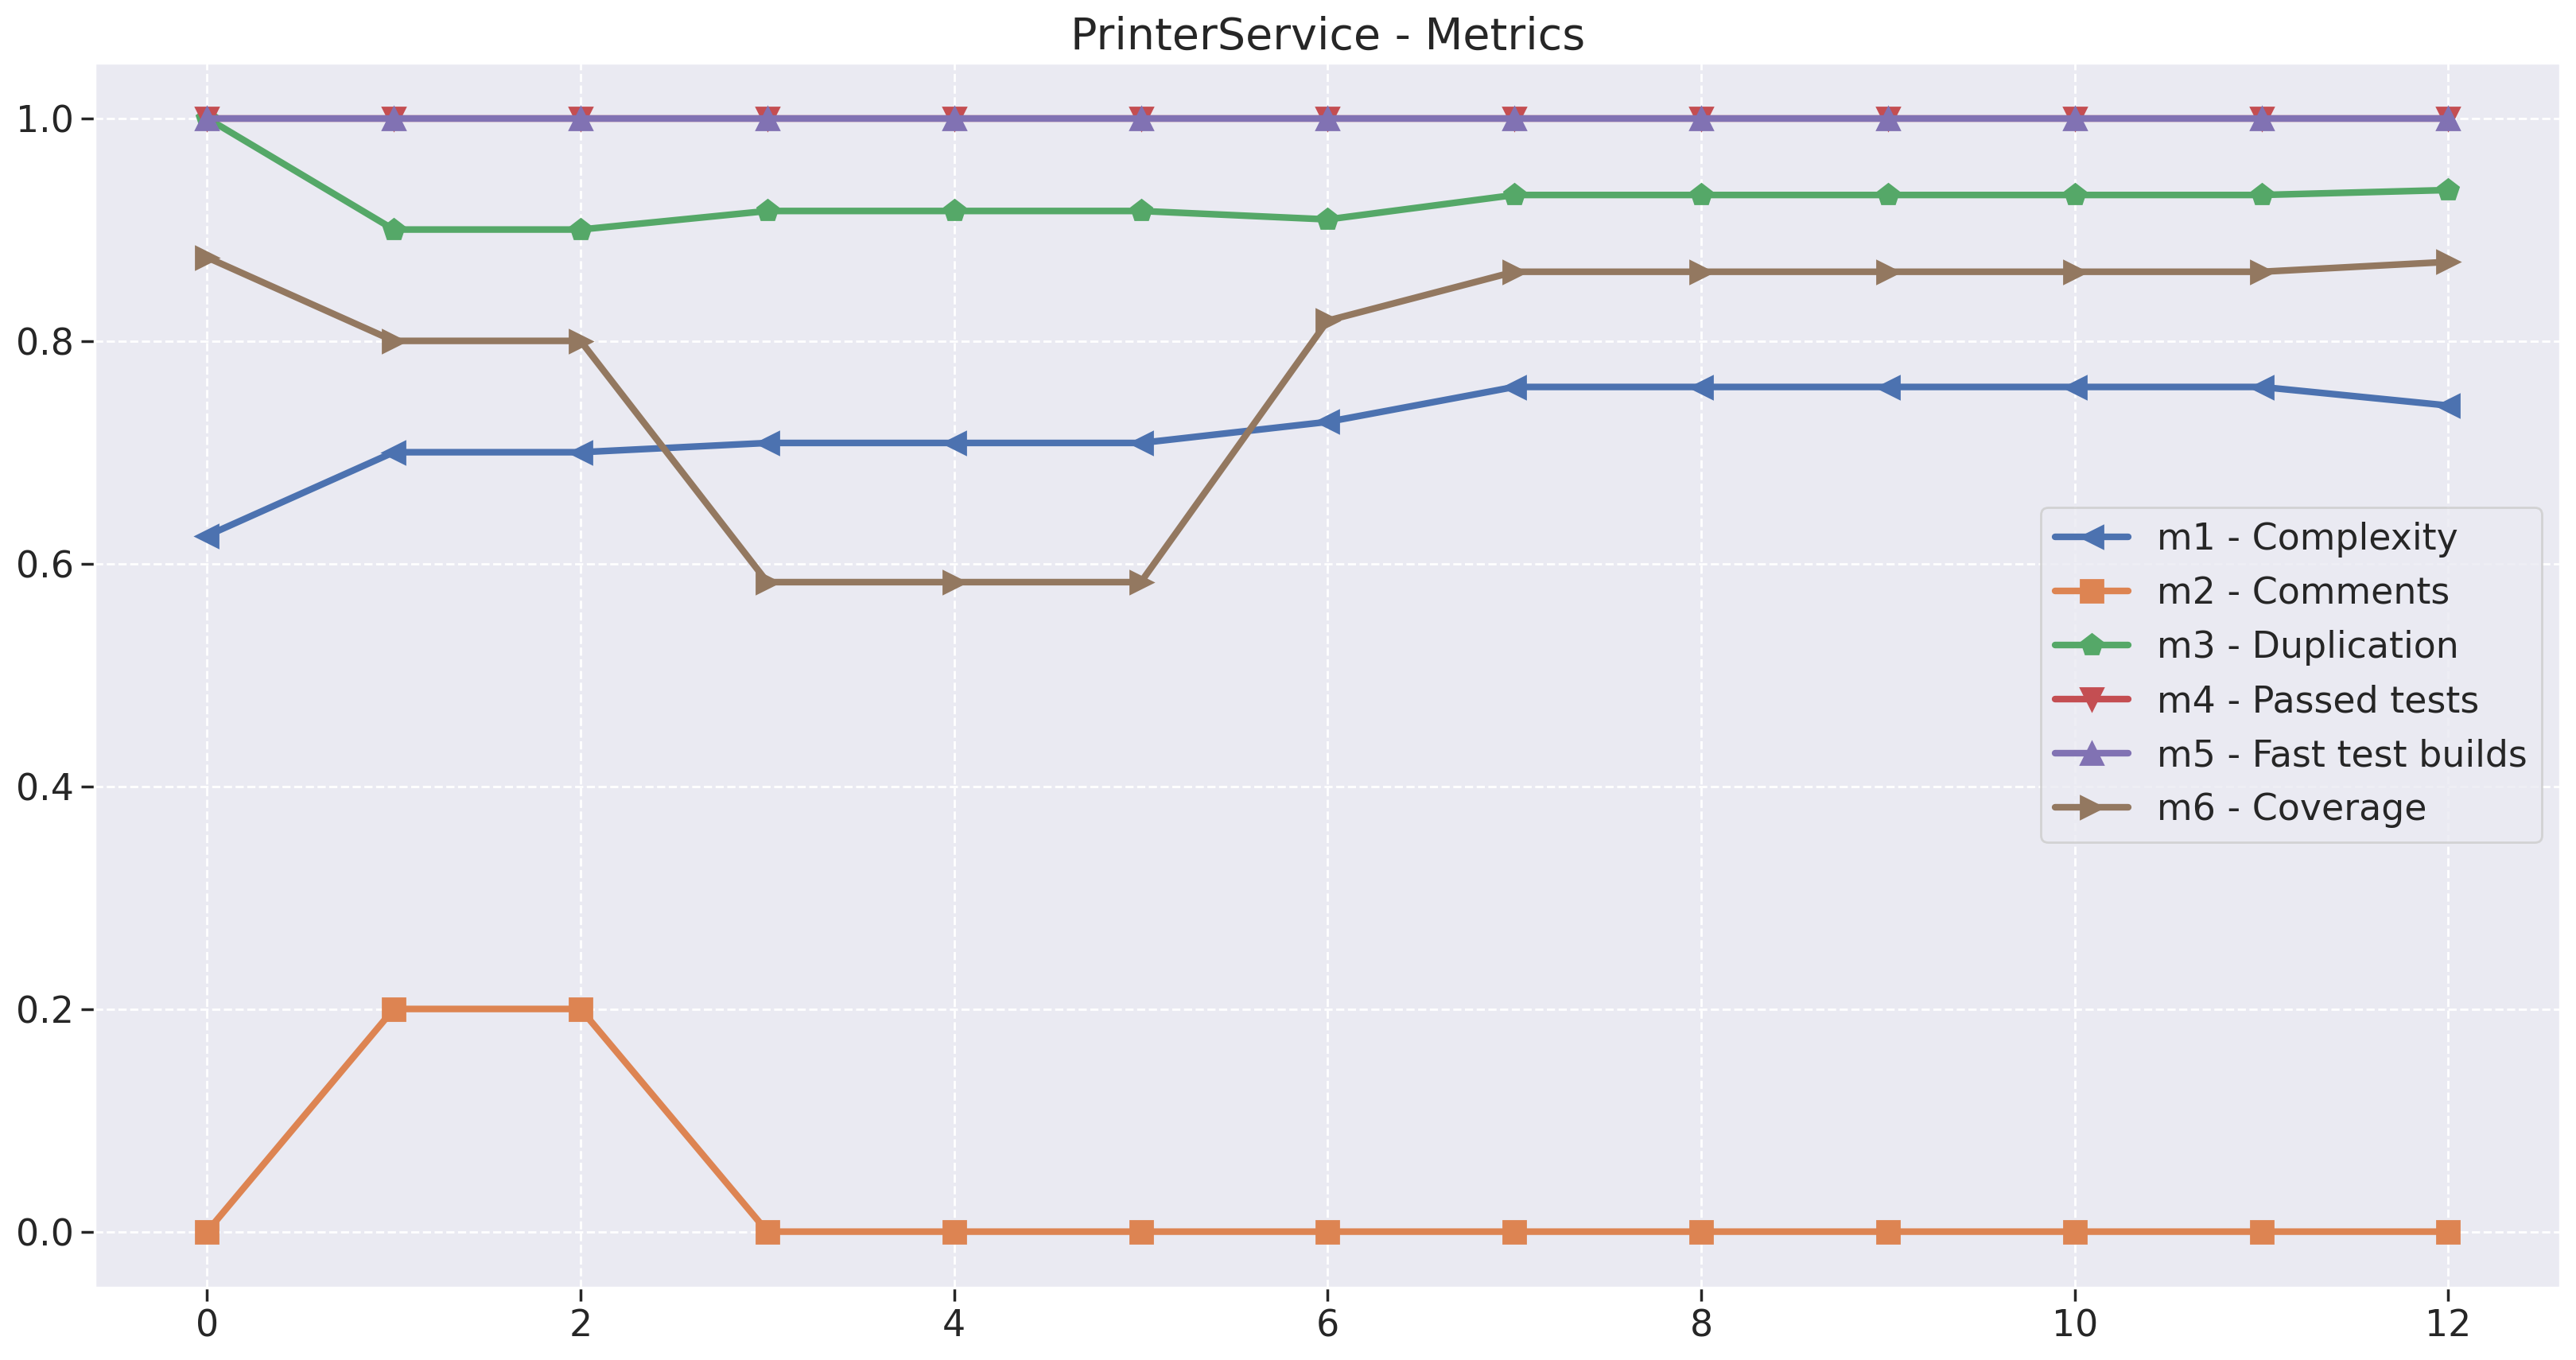

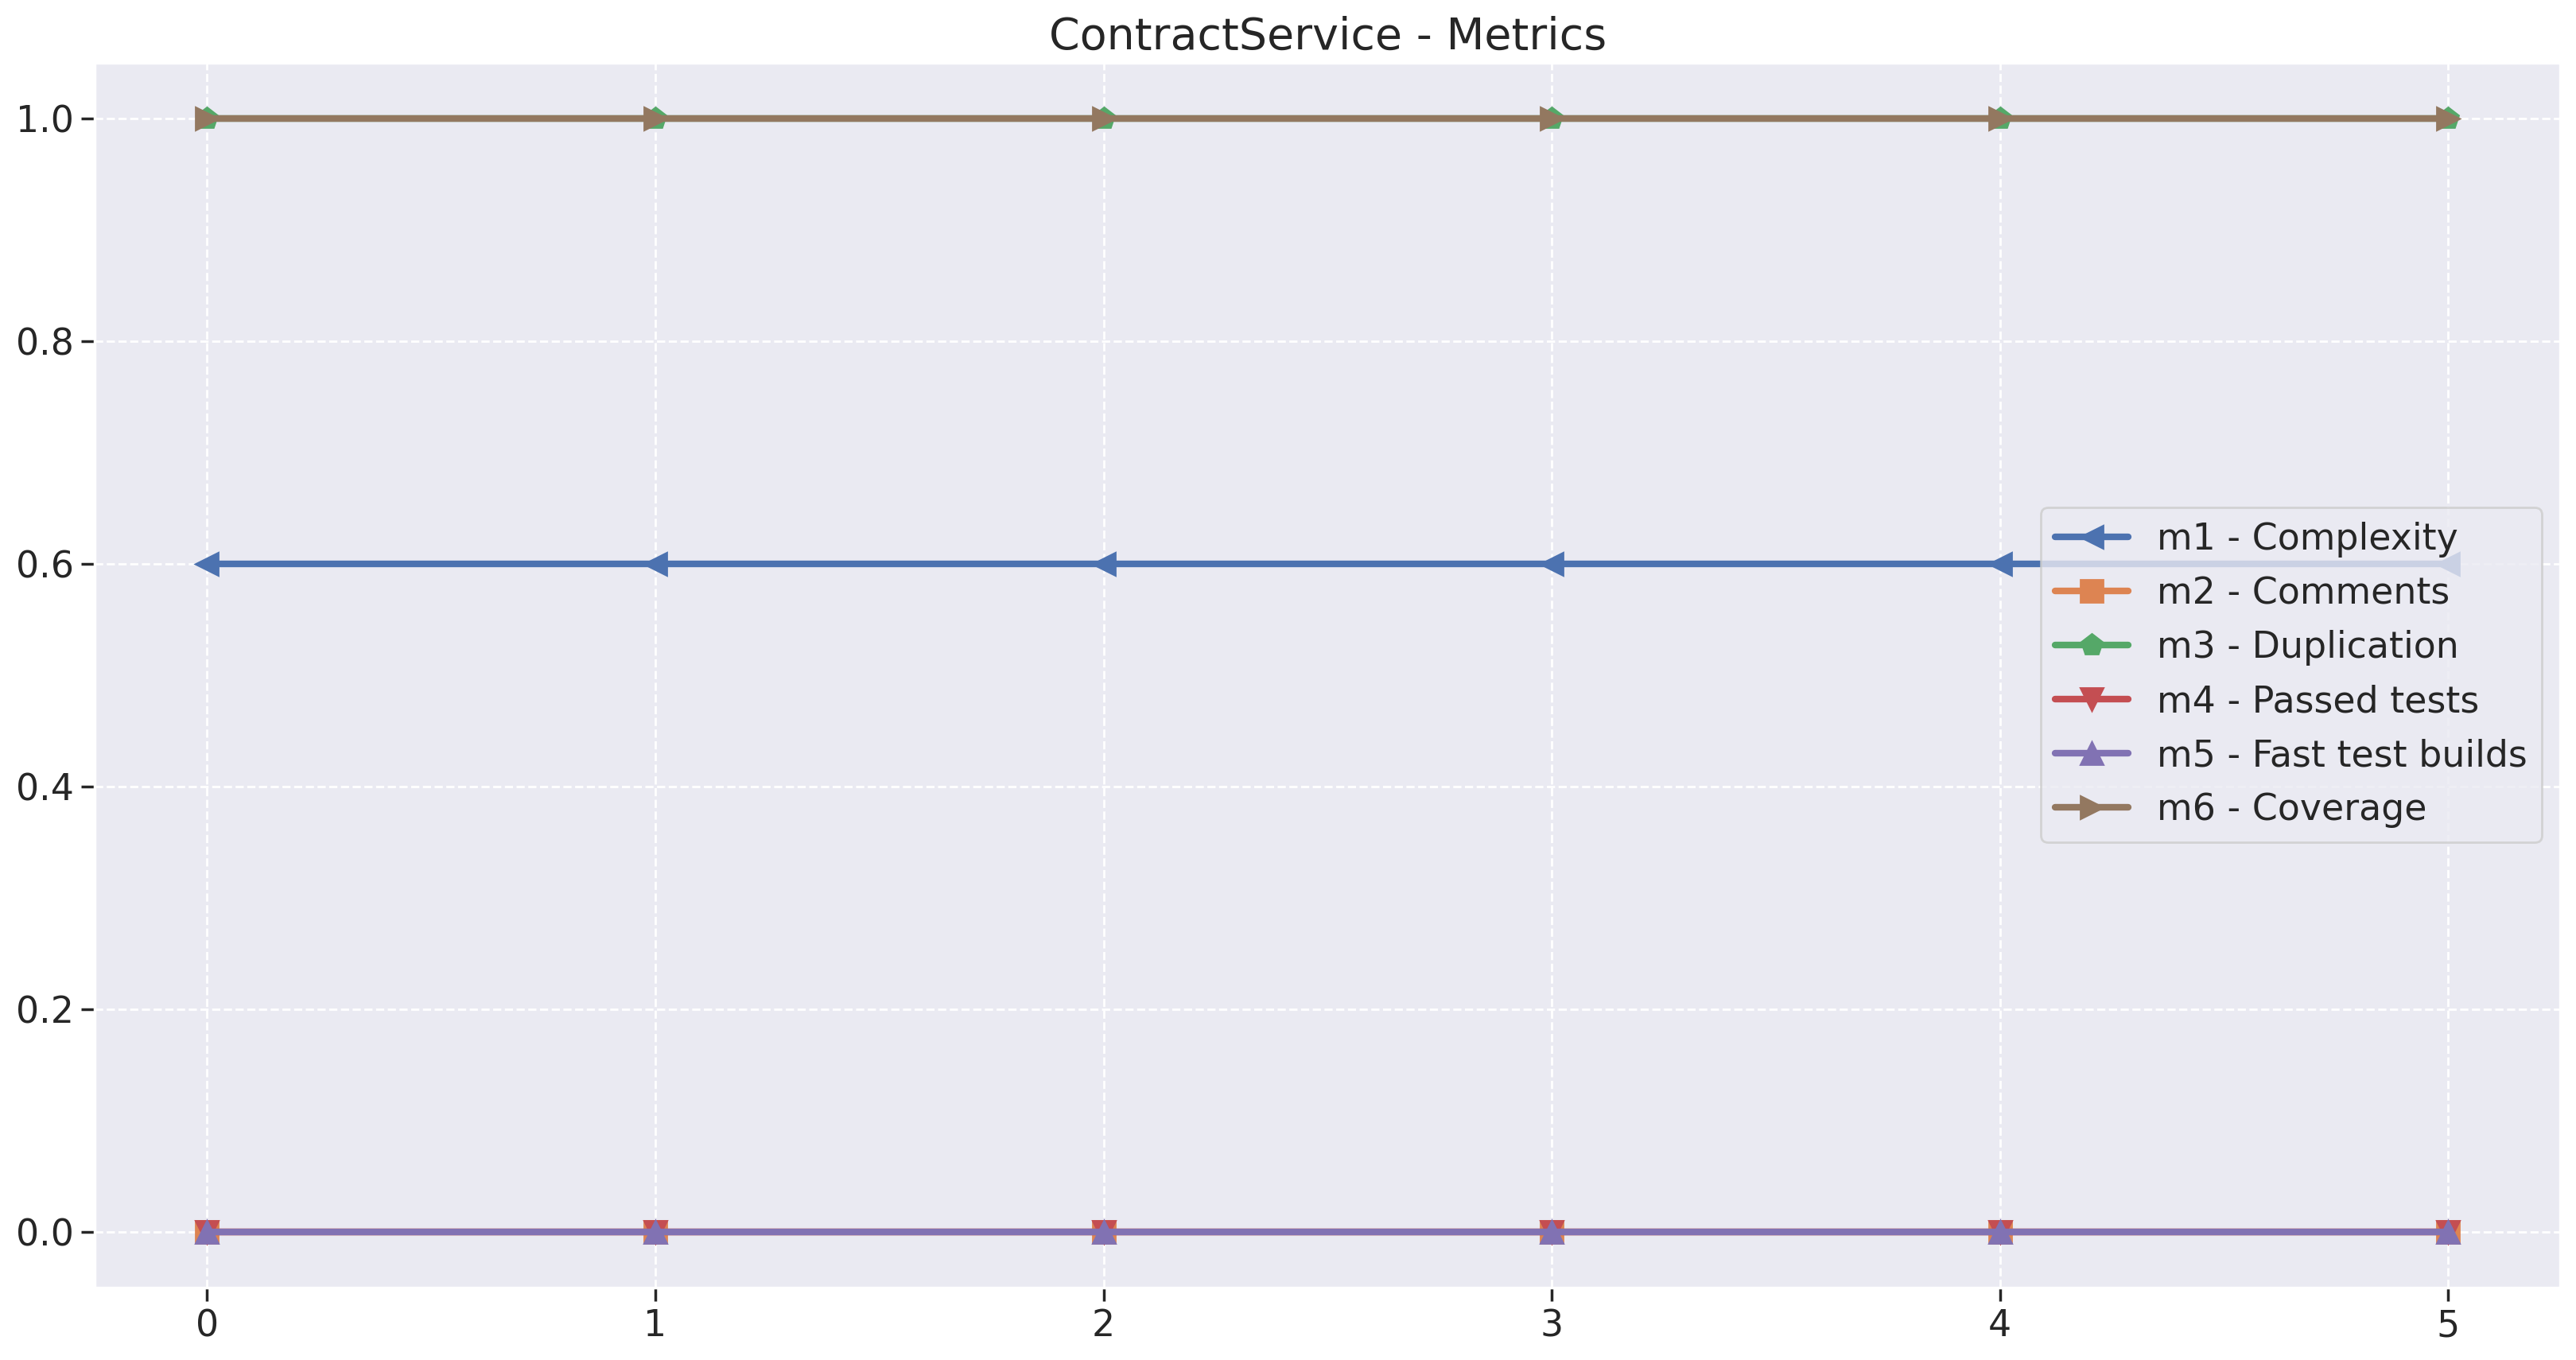

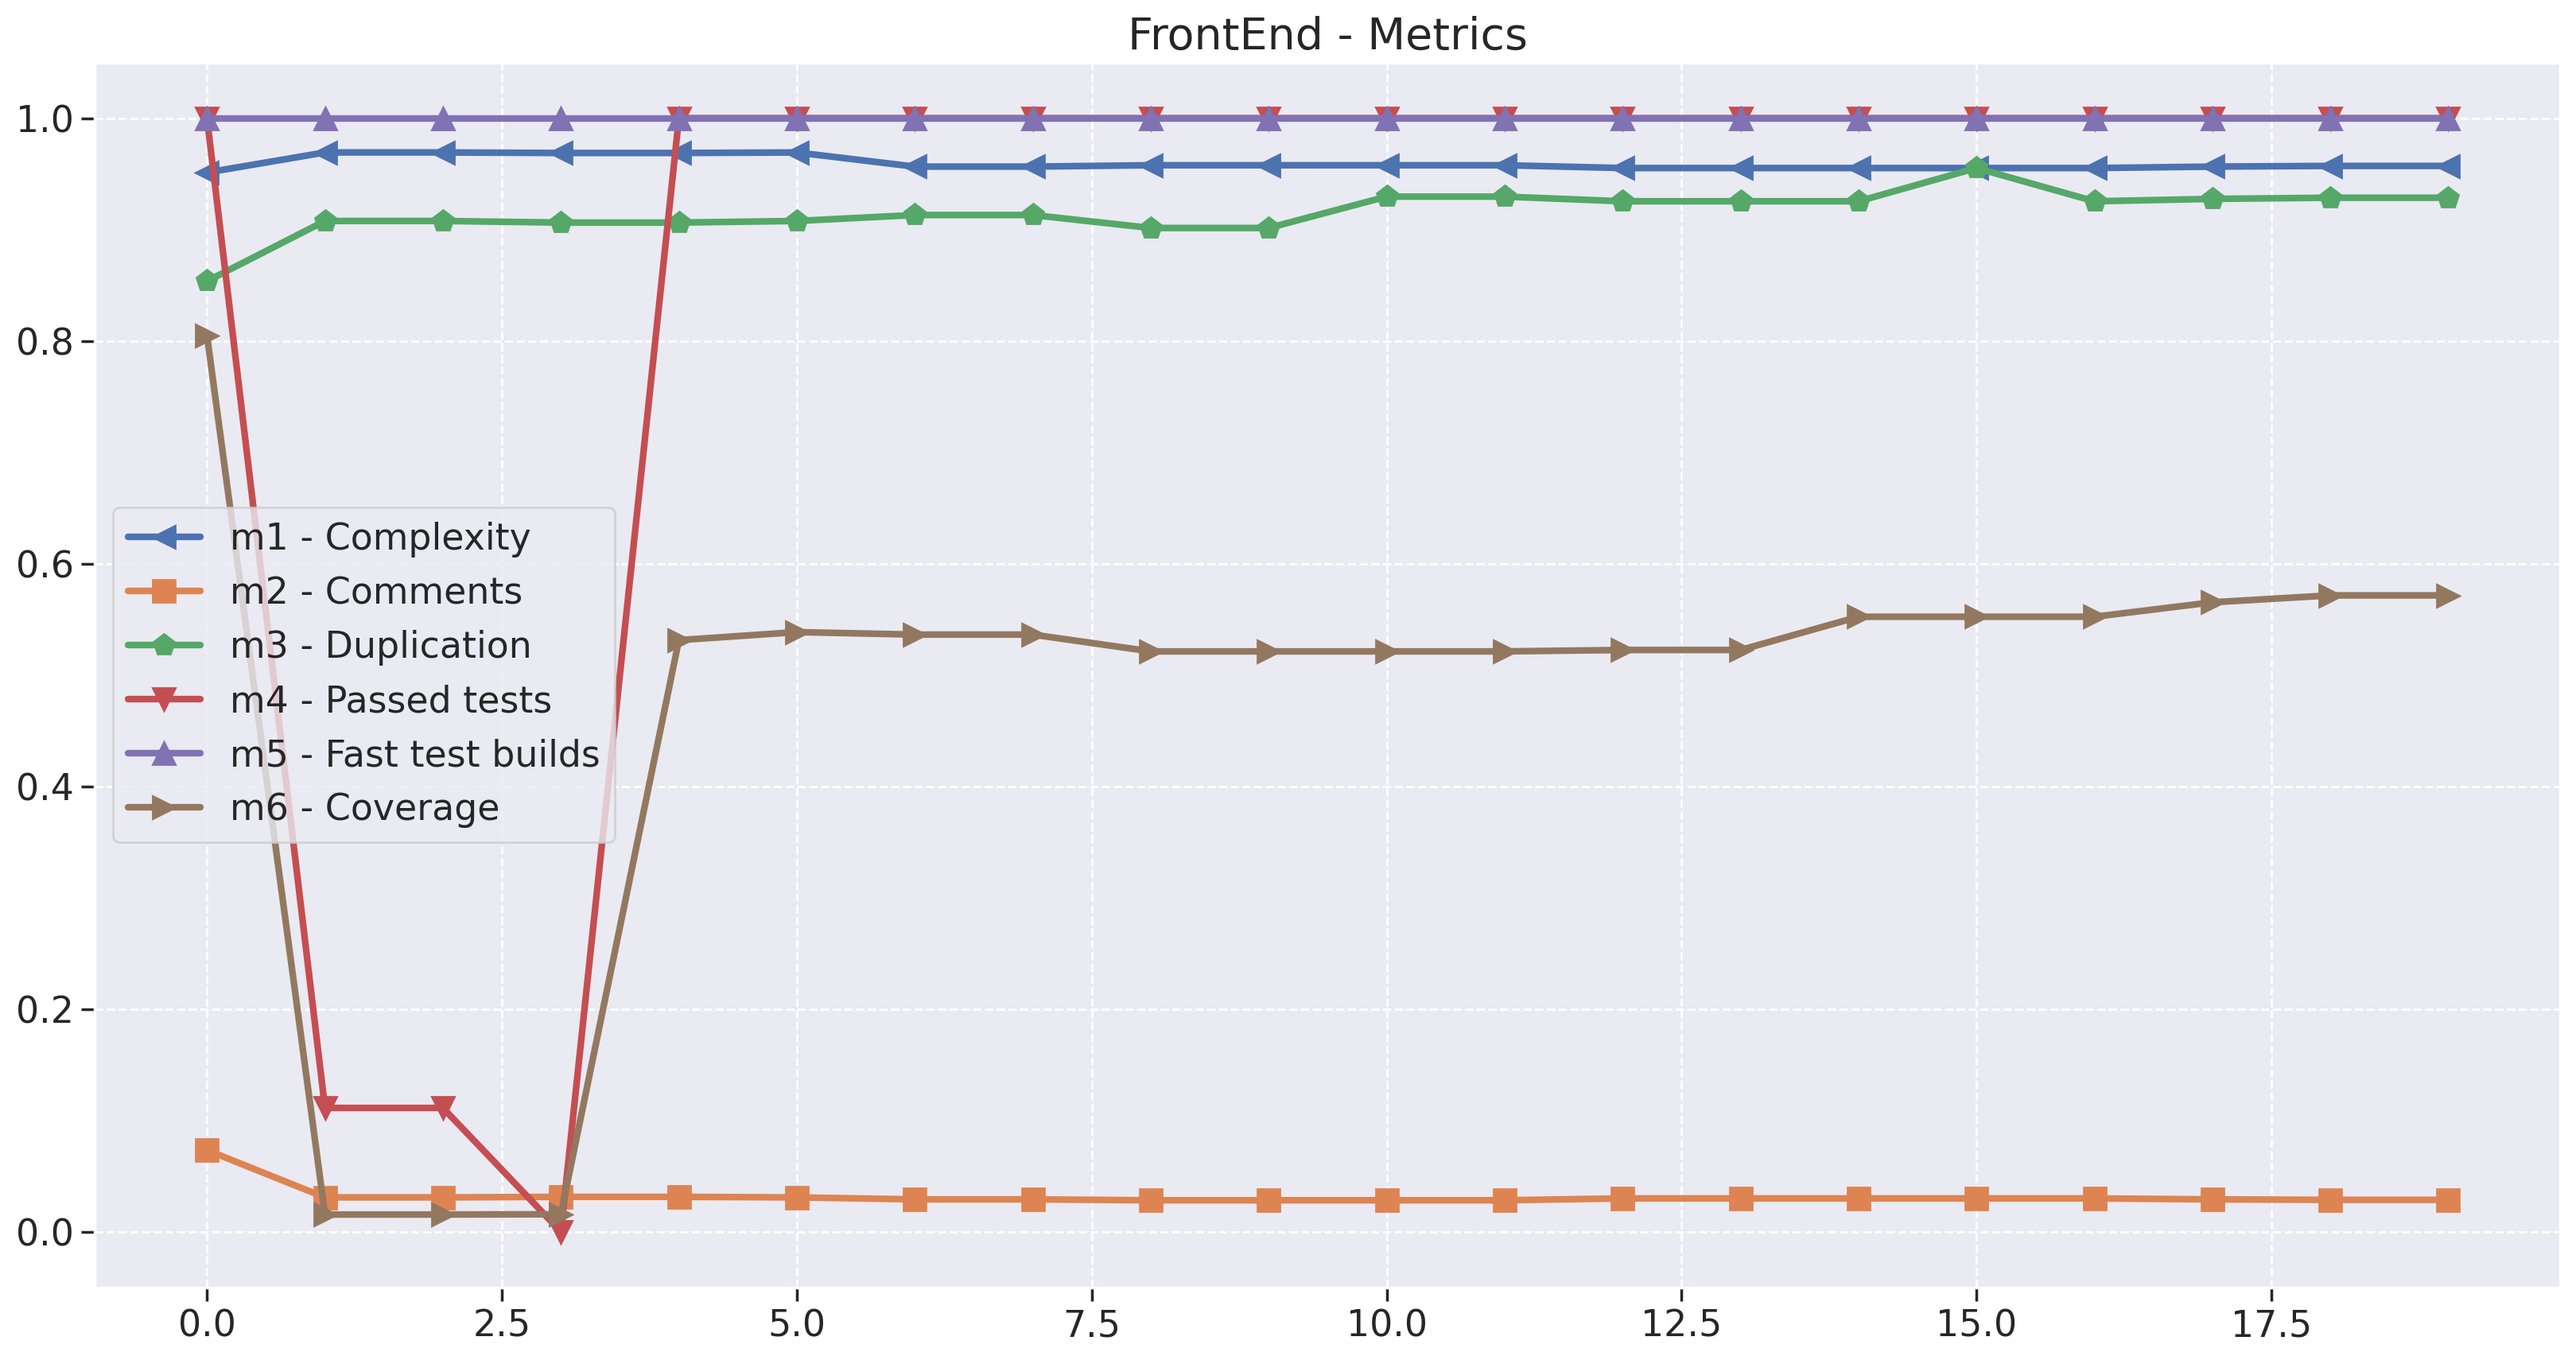

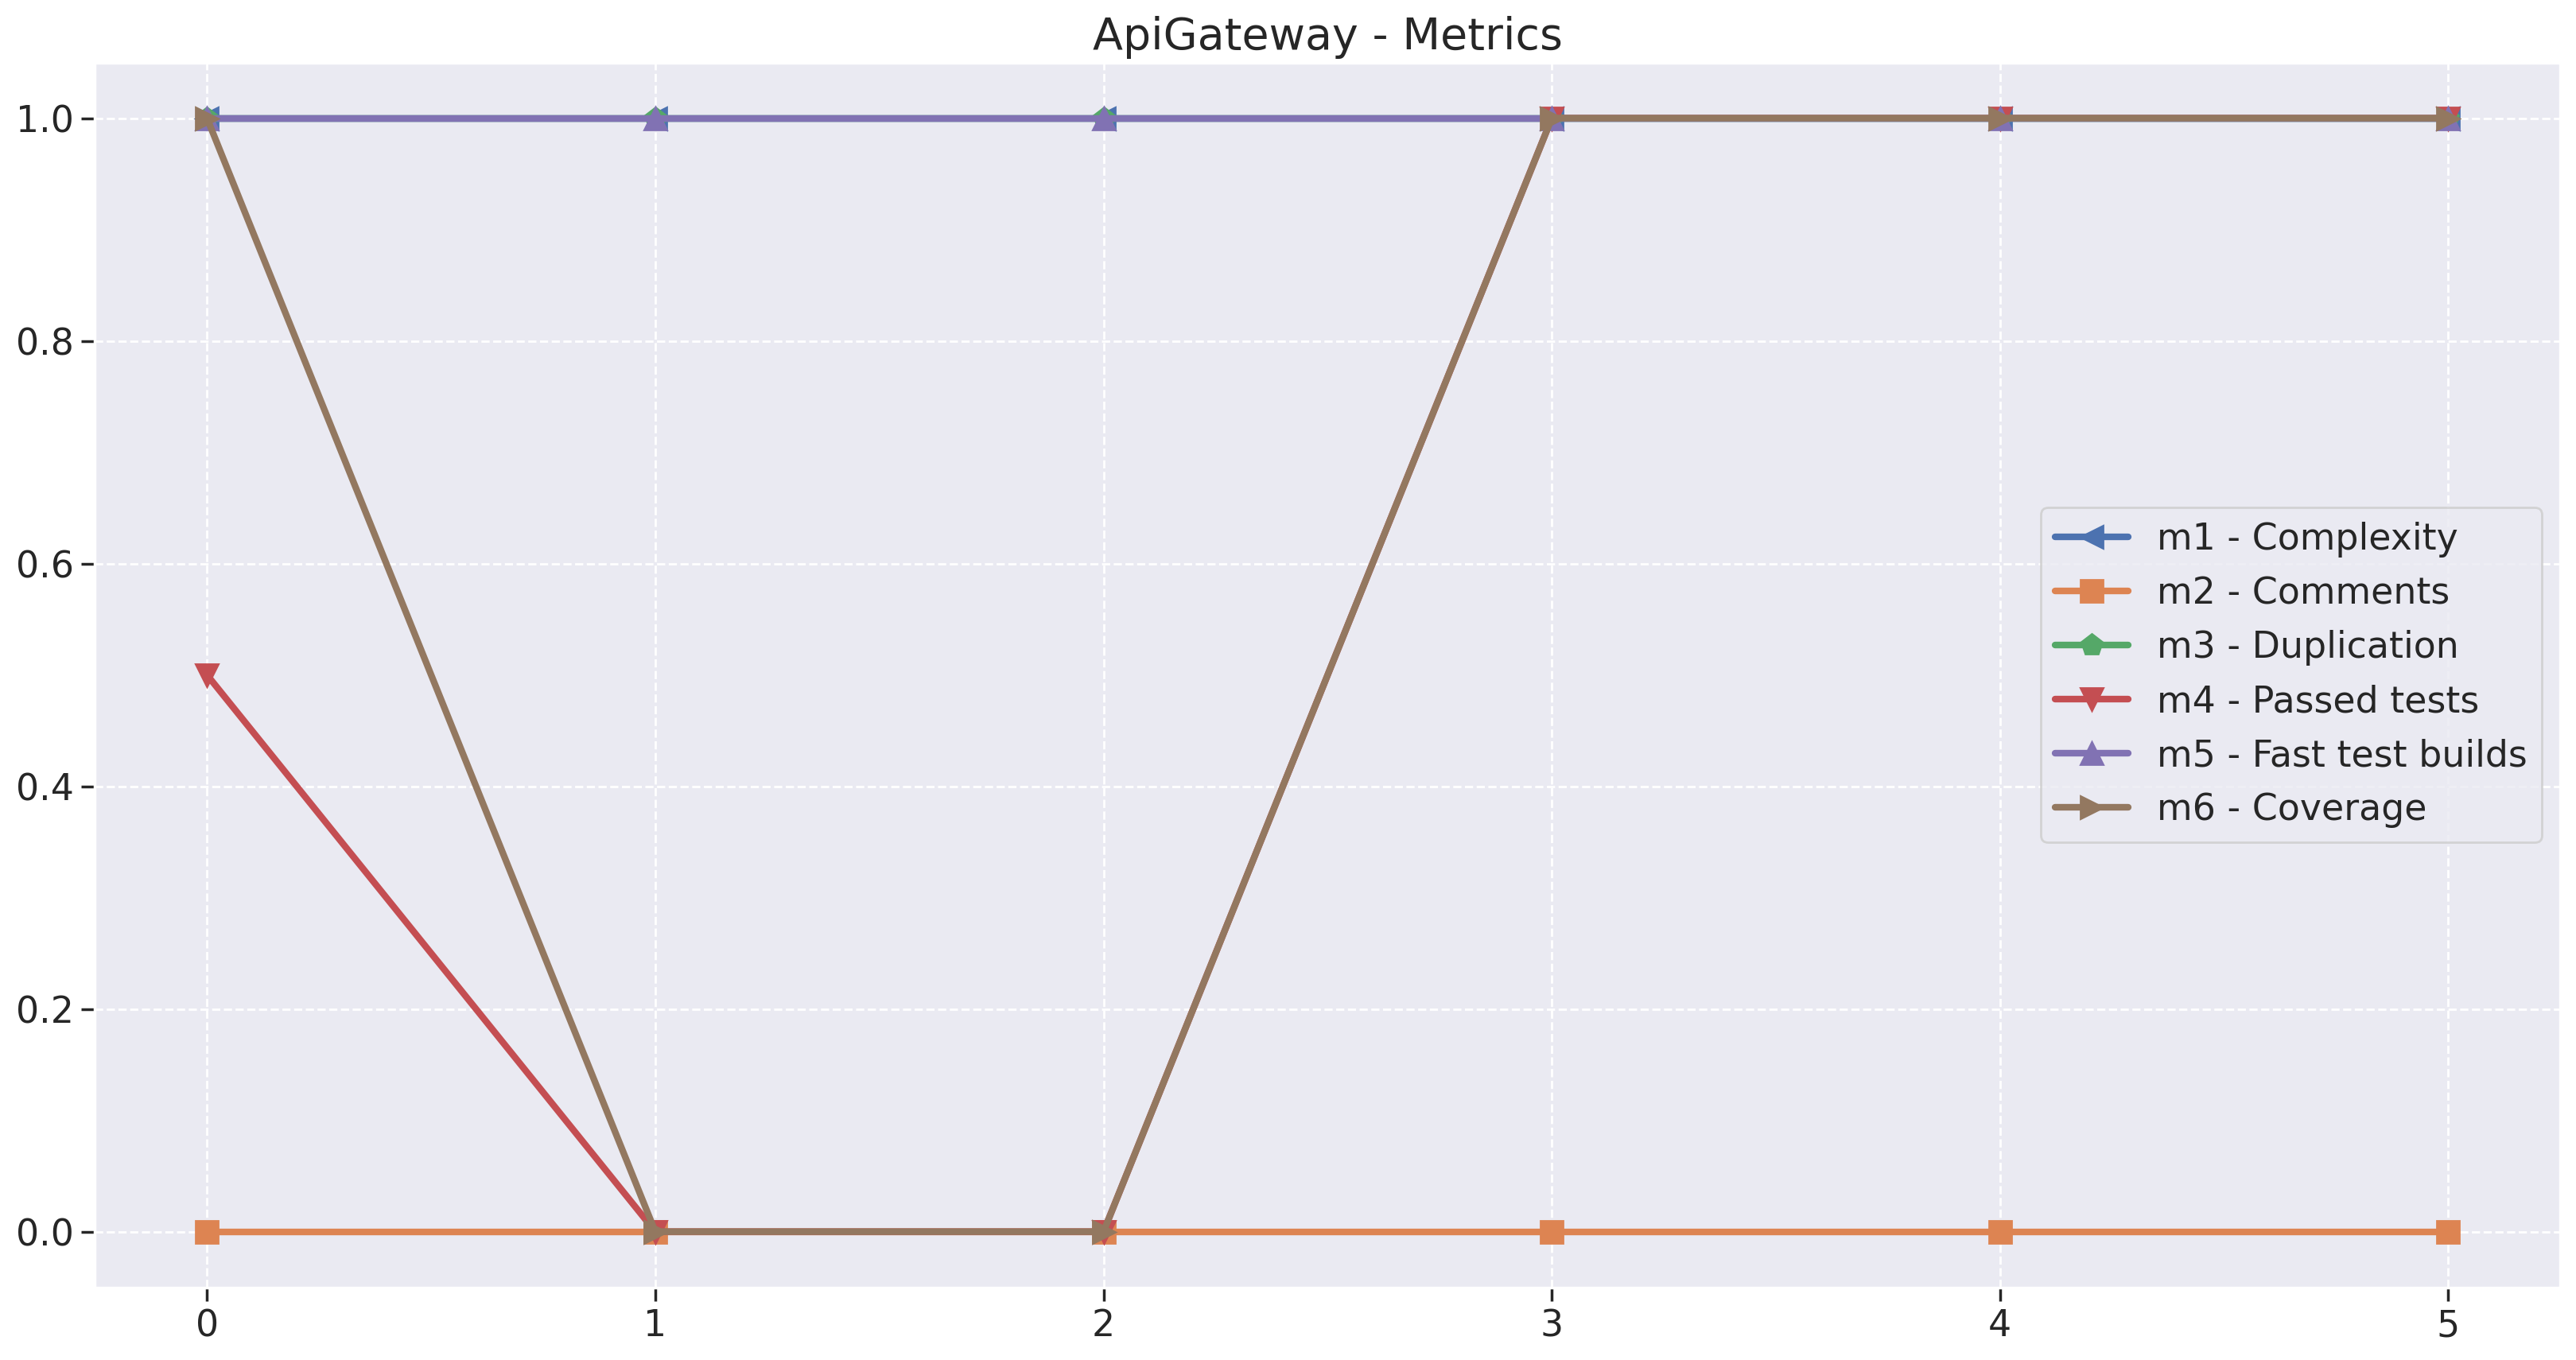

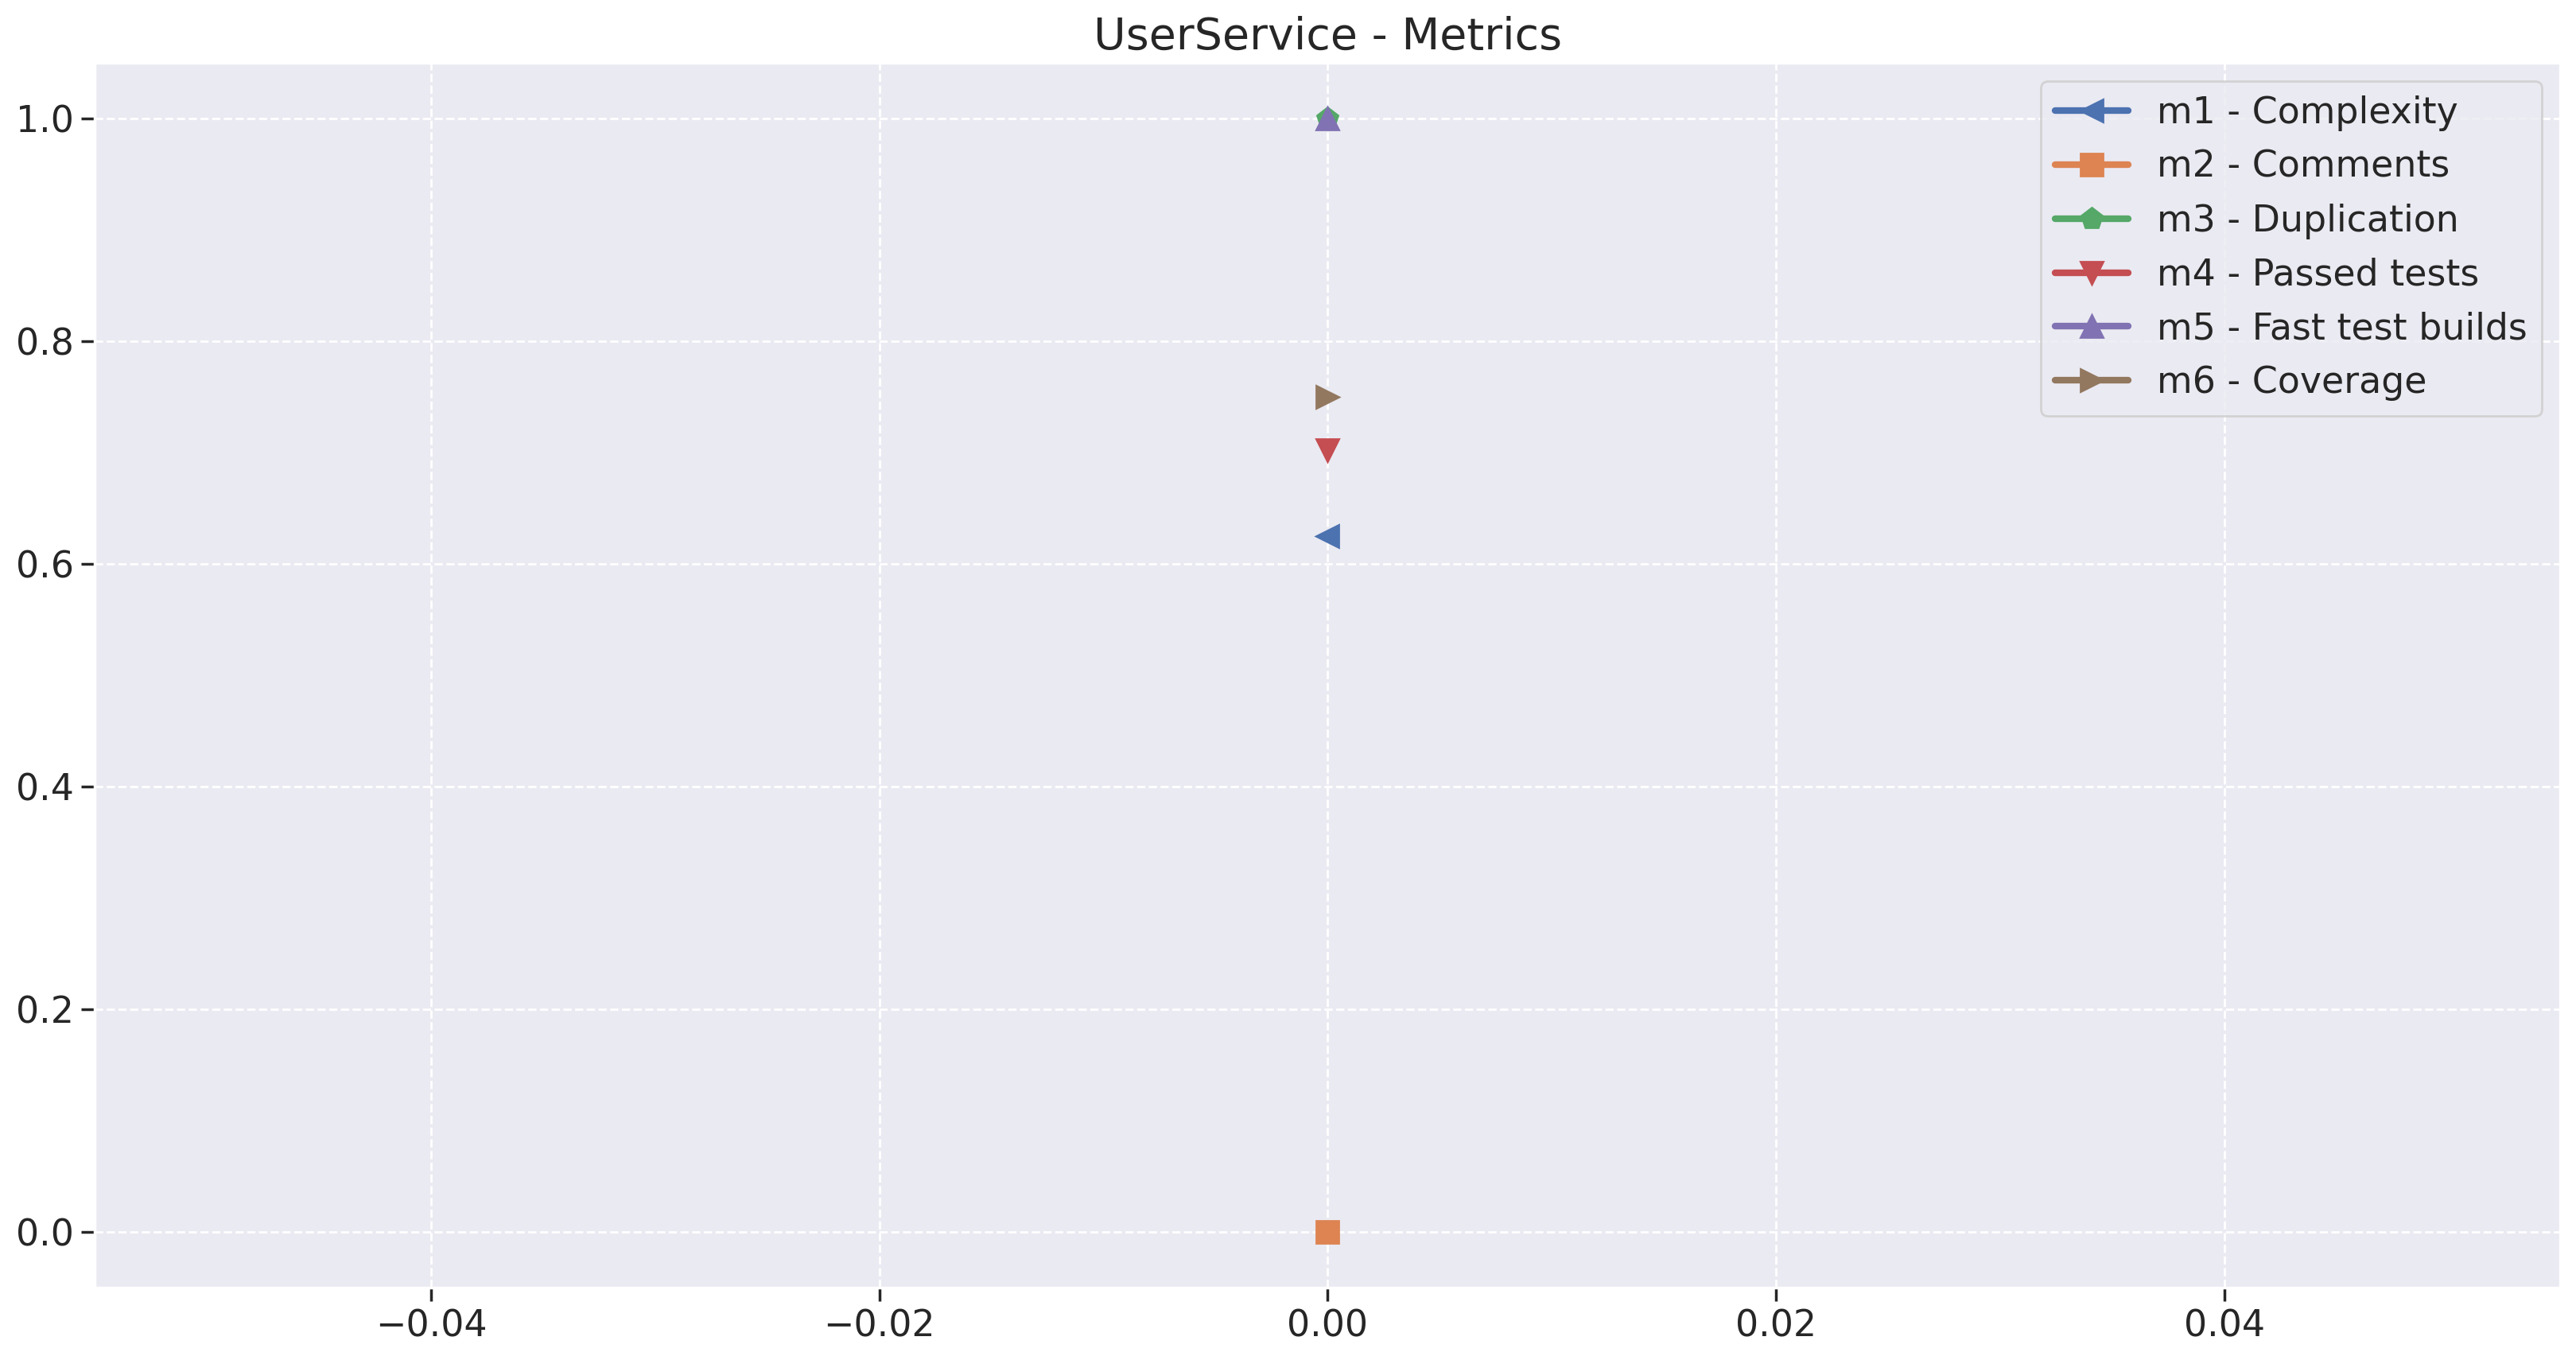

In [58]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [59]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

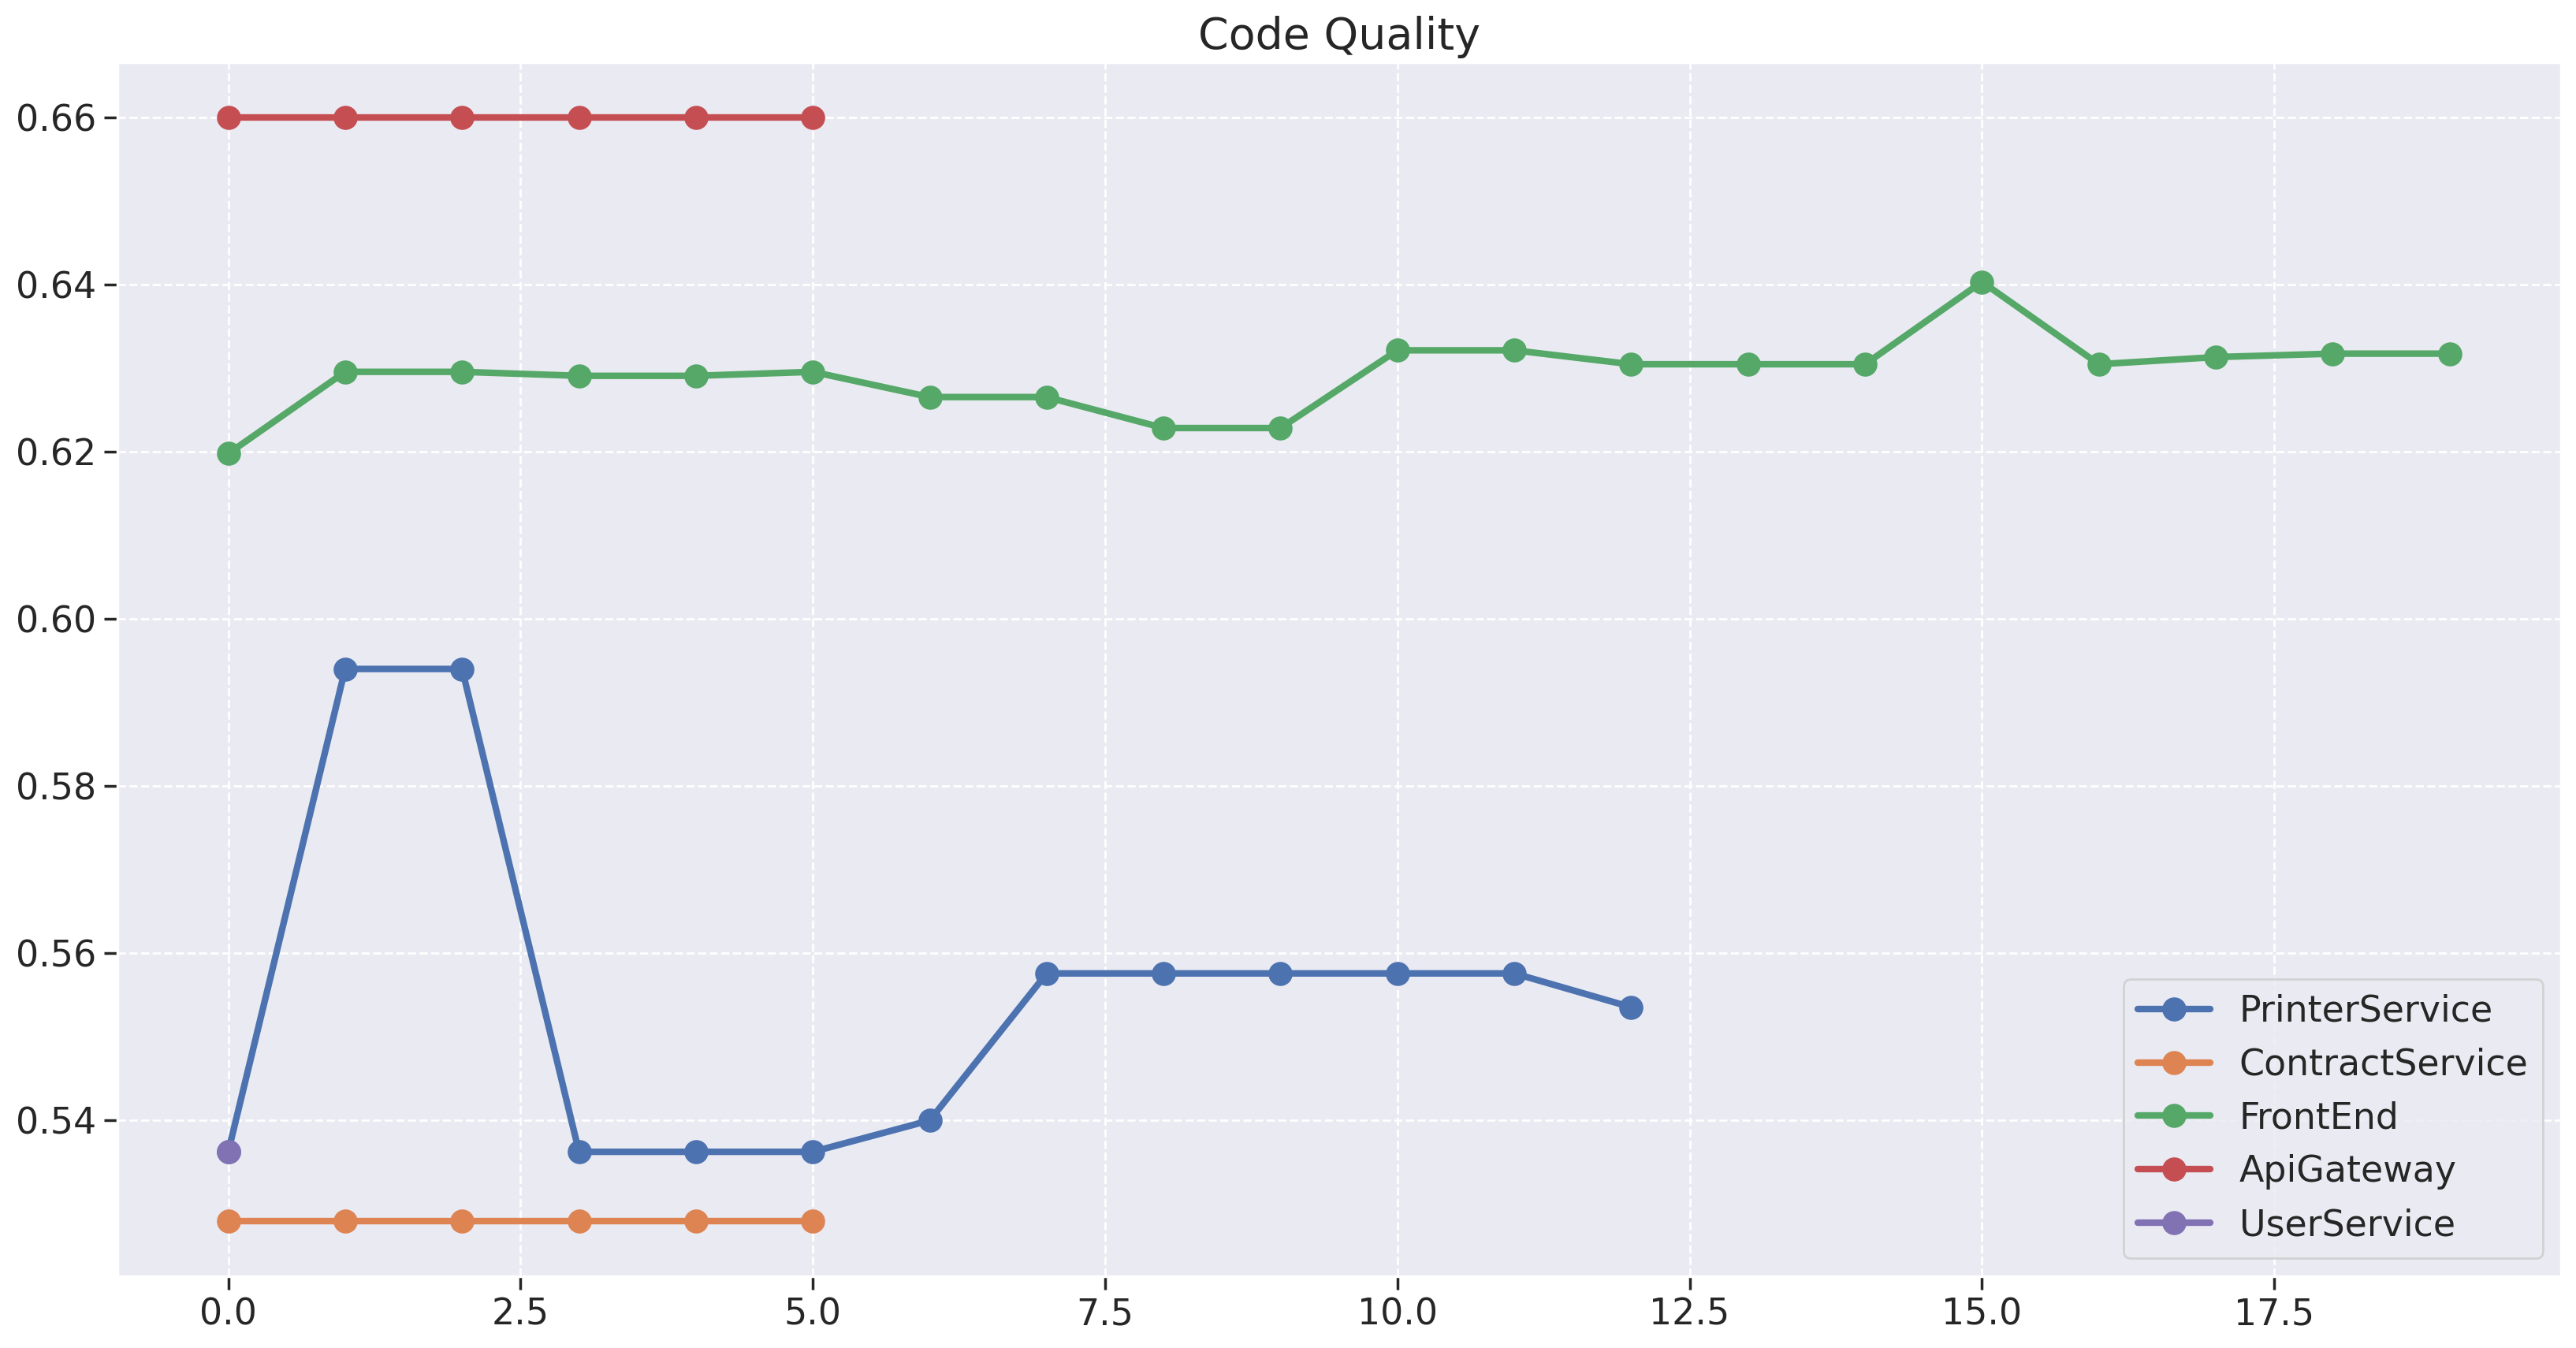

In [60]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

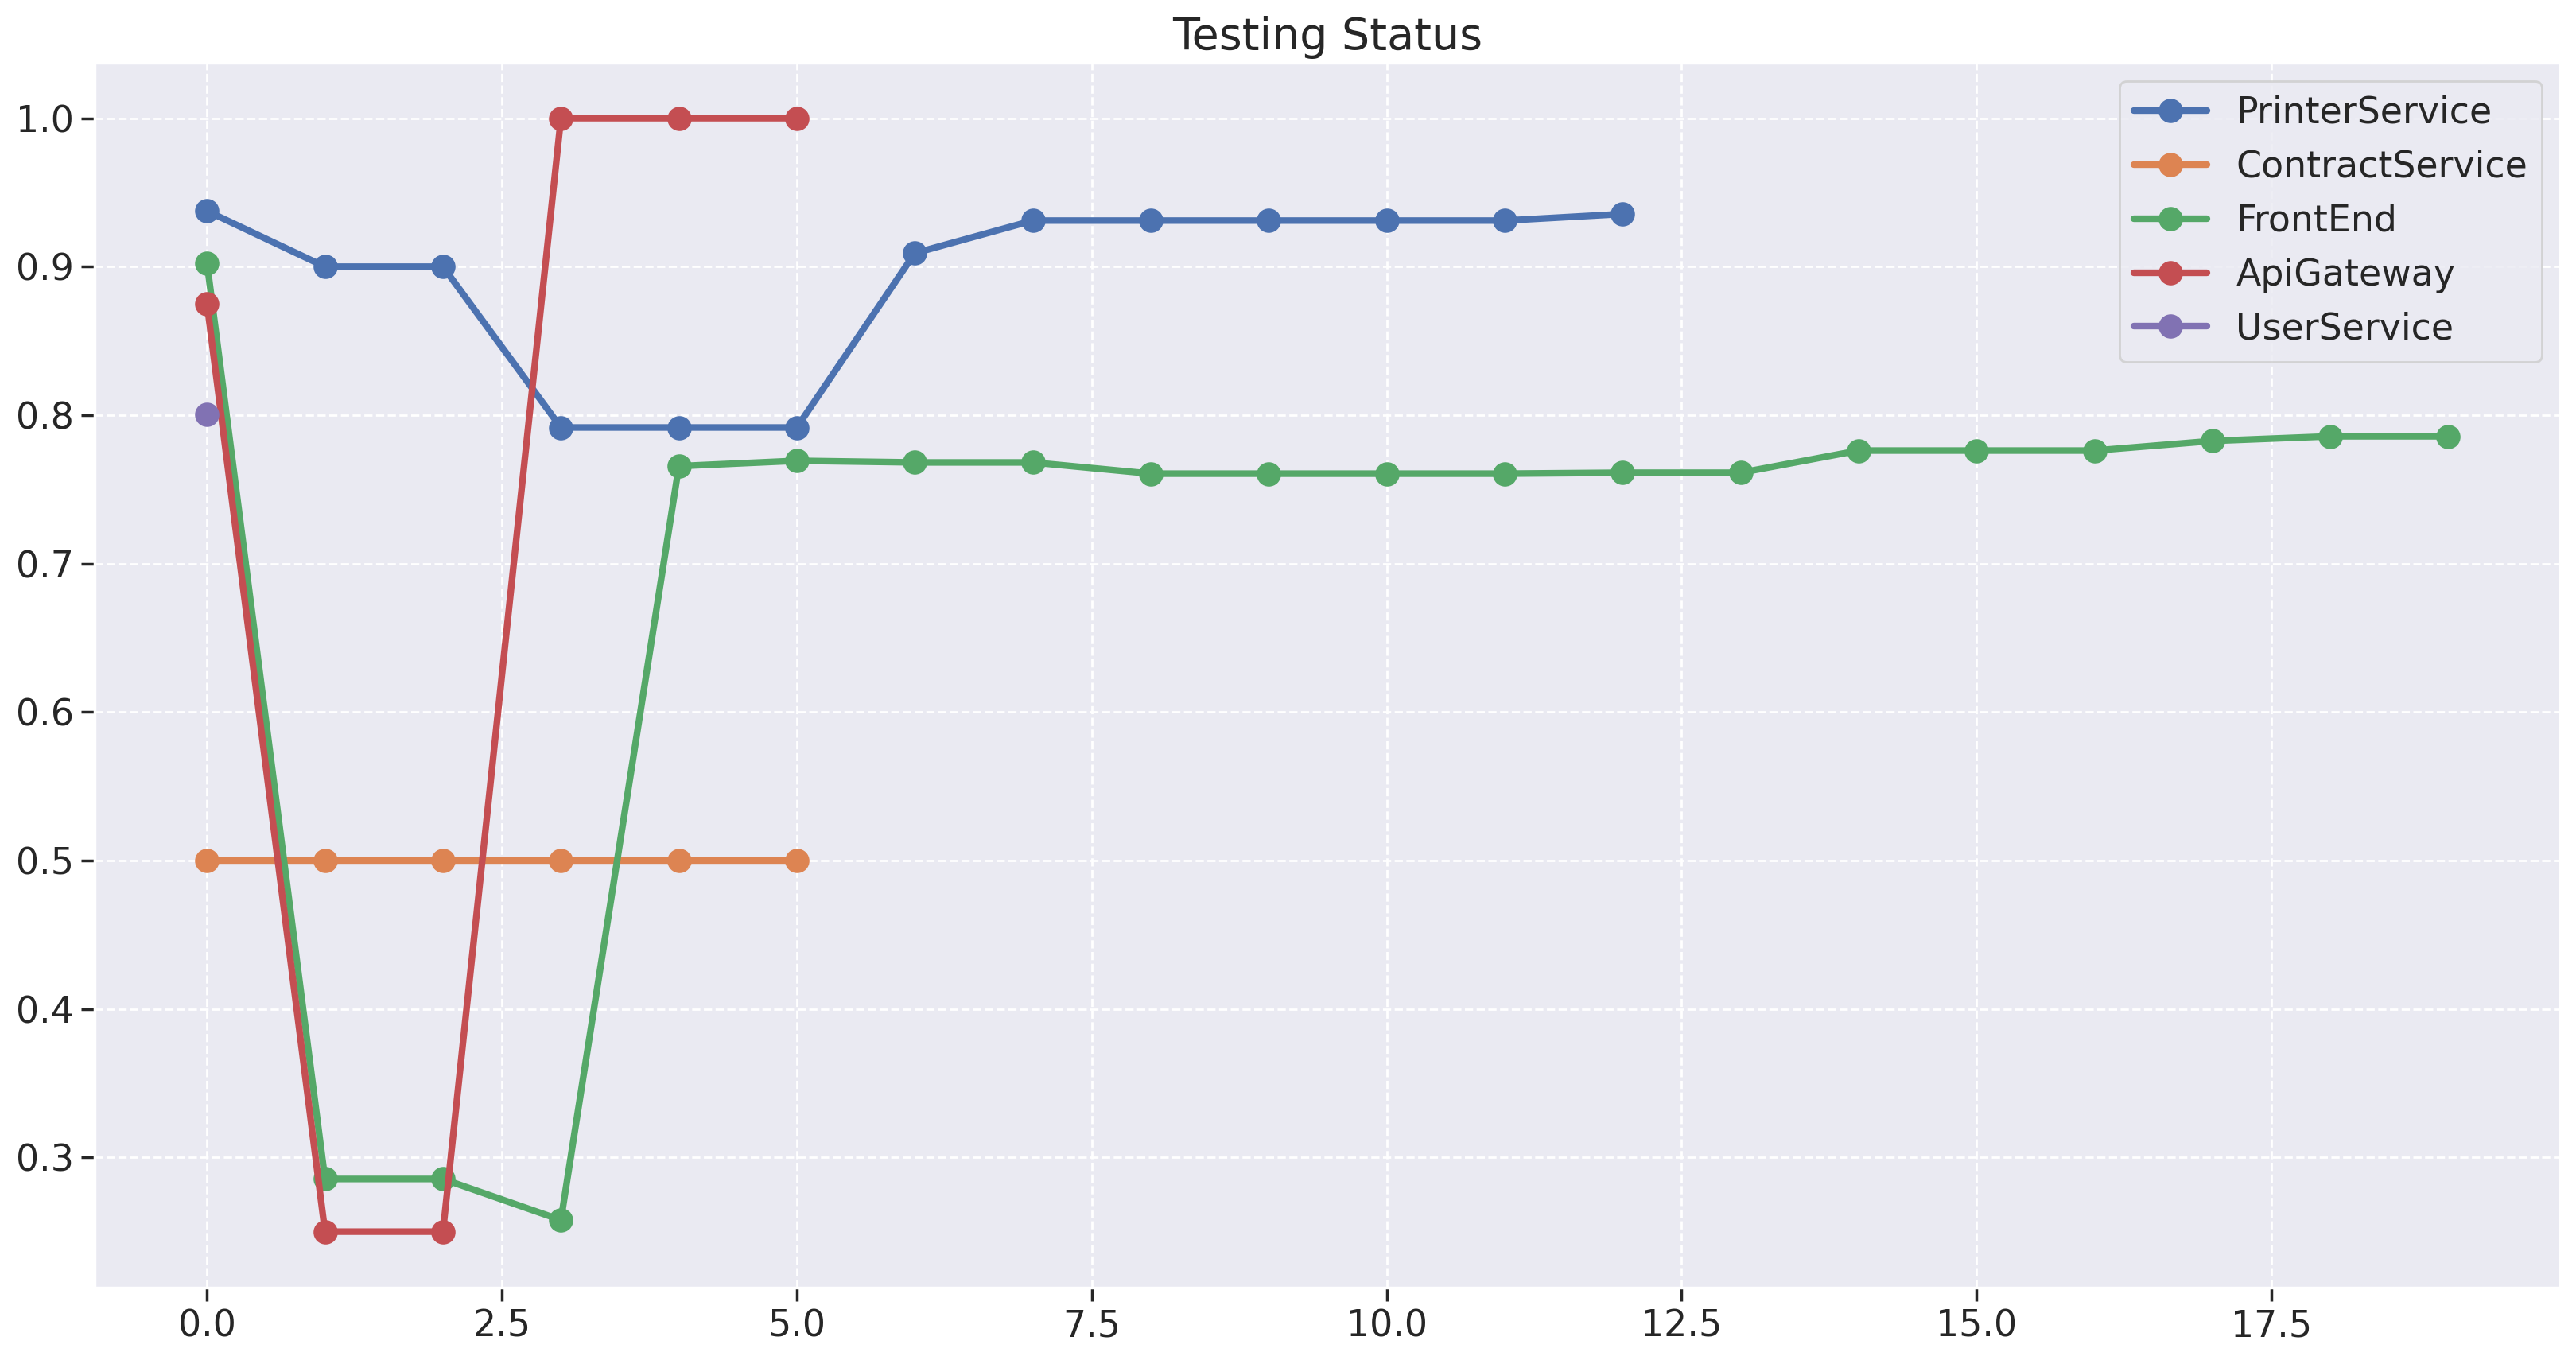

In [61]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [62]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [63]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [64]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

PrinterService
Maintainability Stats
   mean     mode   median      std      var      min   max
0.27748 0.278793 0.278793 0.009905 0.000098 0.268125 0.297
Reliability Stats
    mean     mode   median      std      var      min     max
0.446625 0.465517 0.465517 0.029644 0.000879 0.395833 0.46875


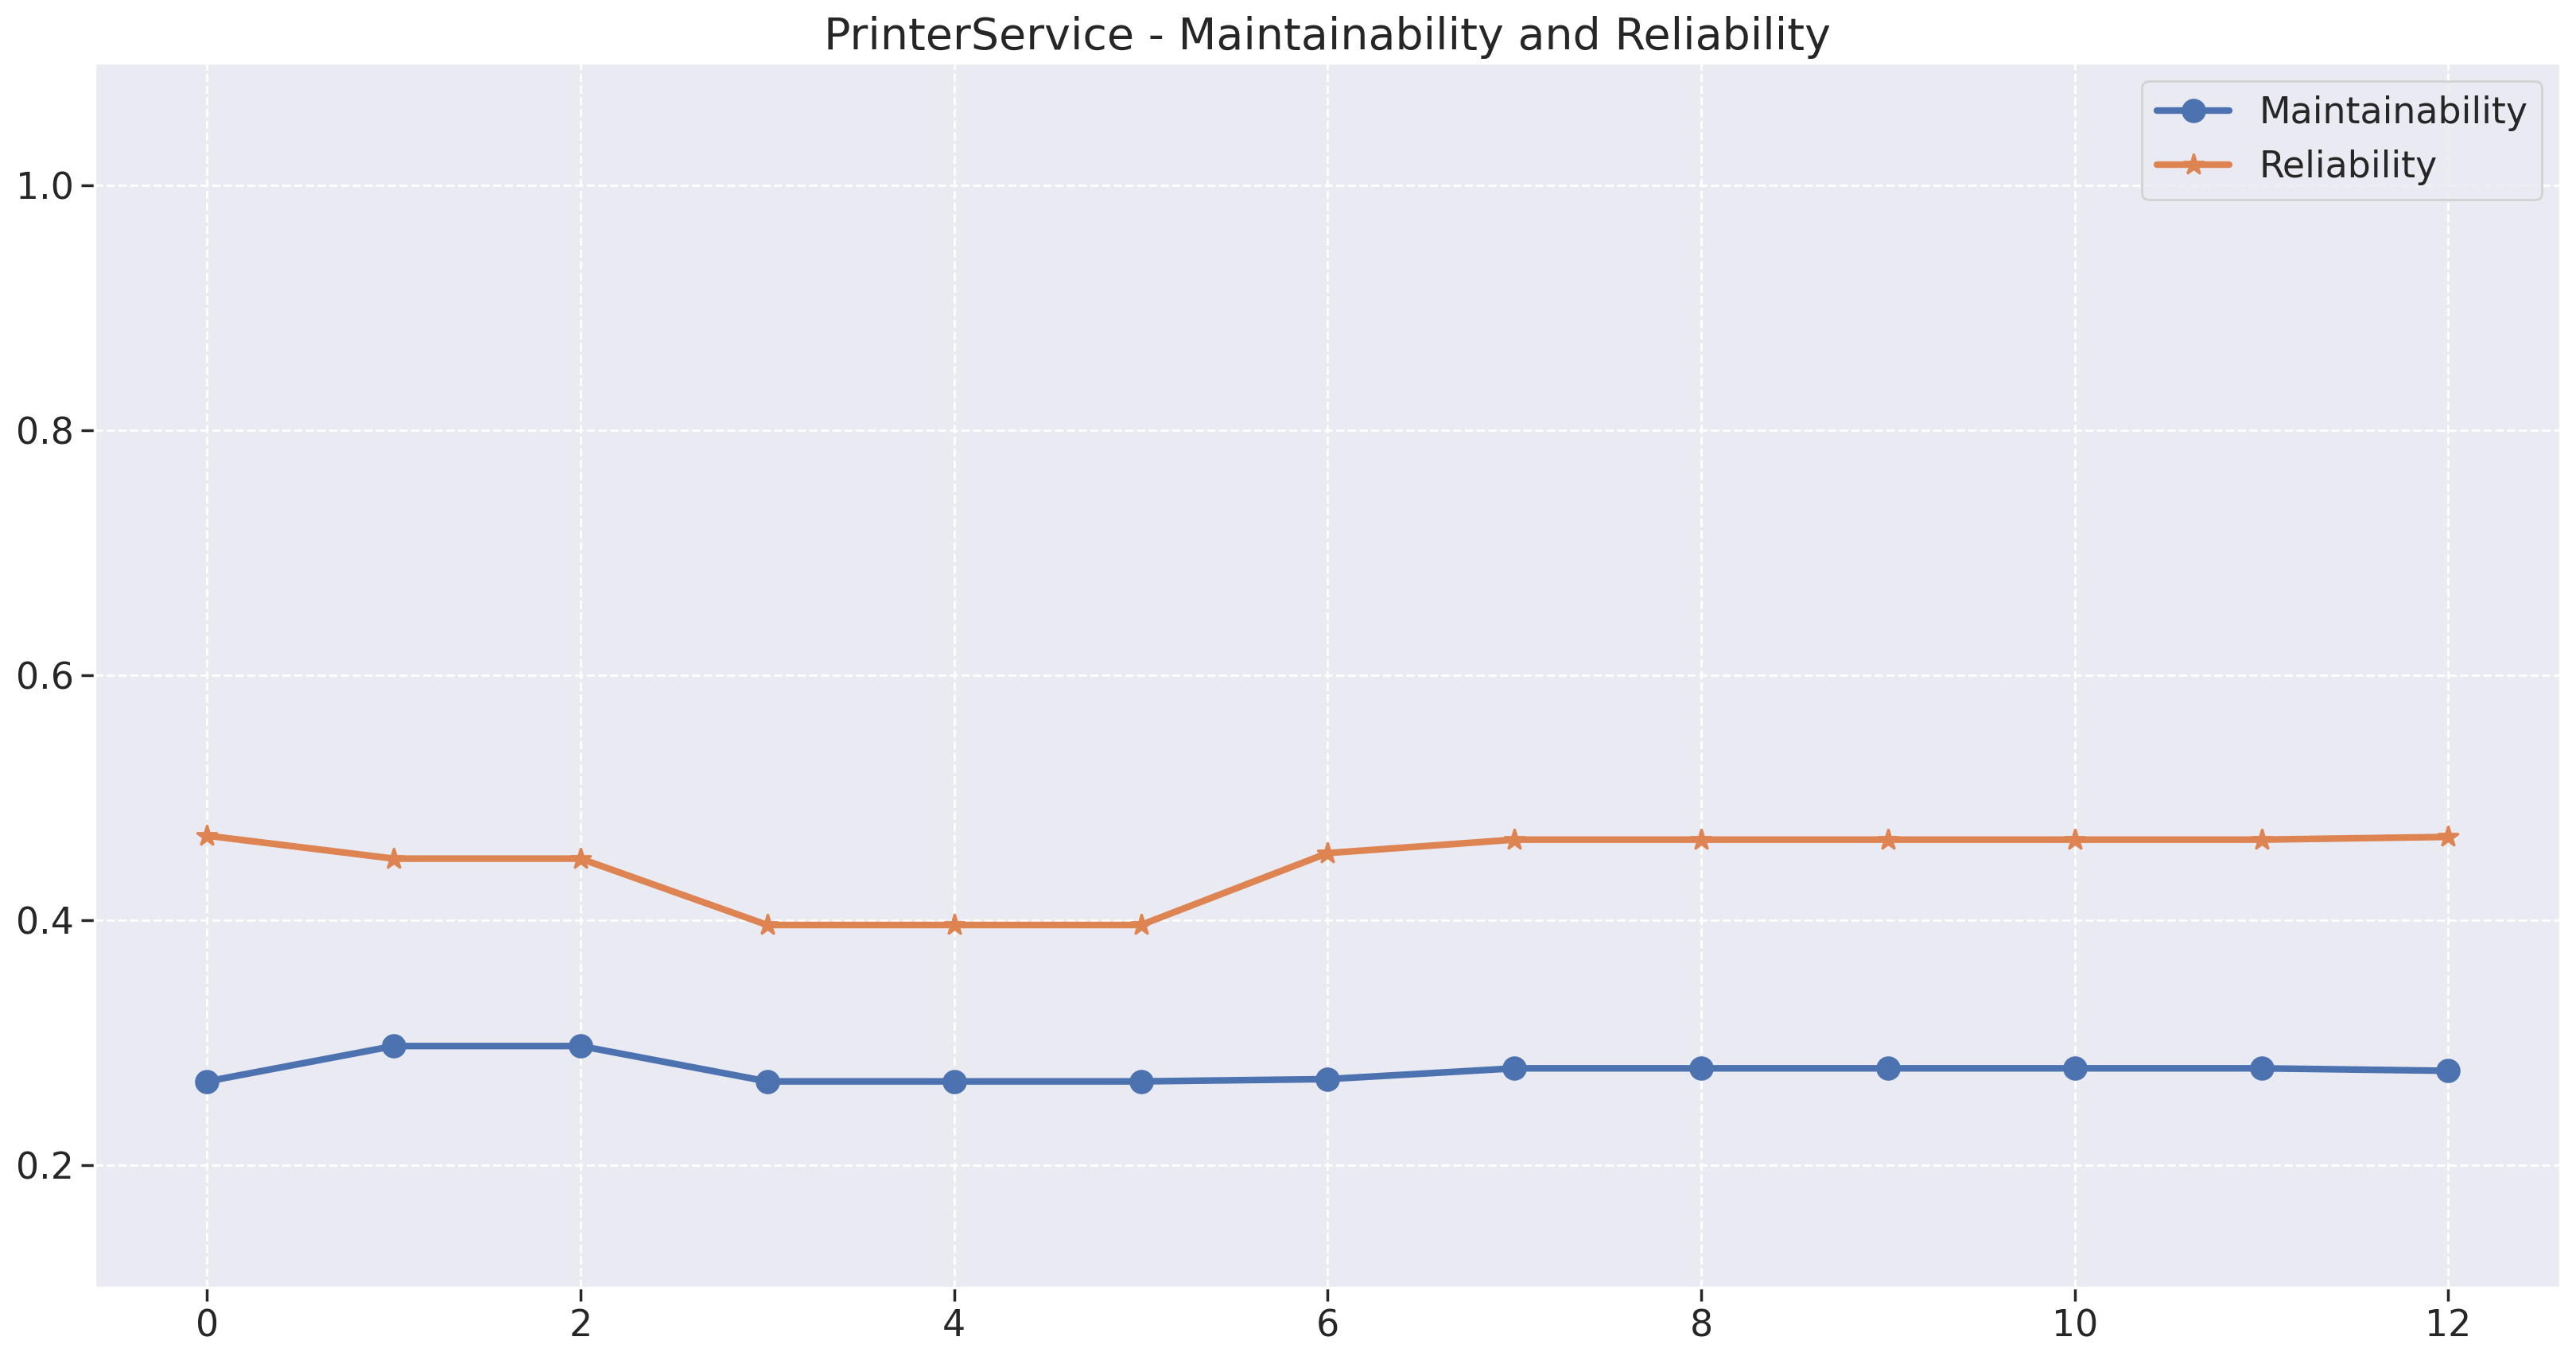

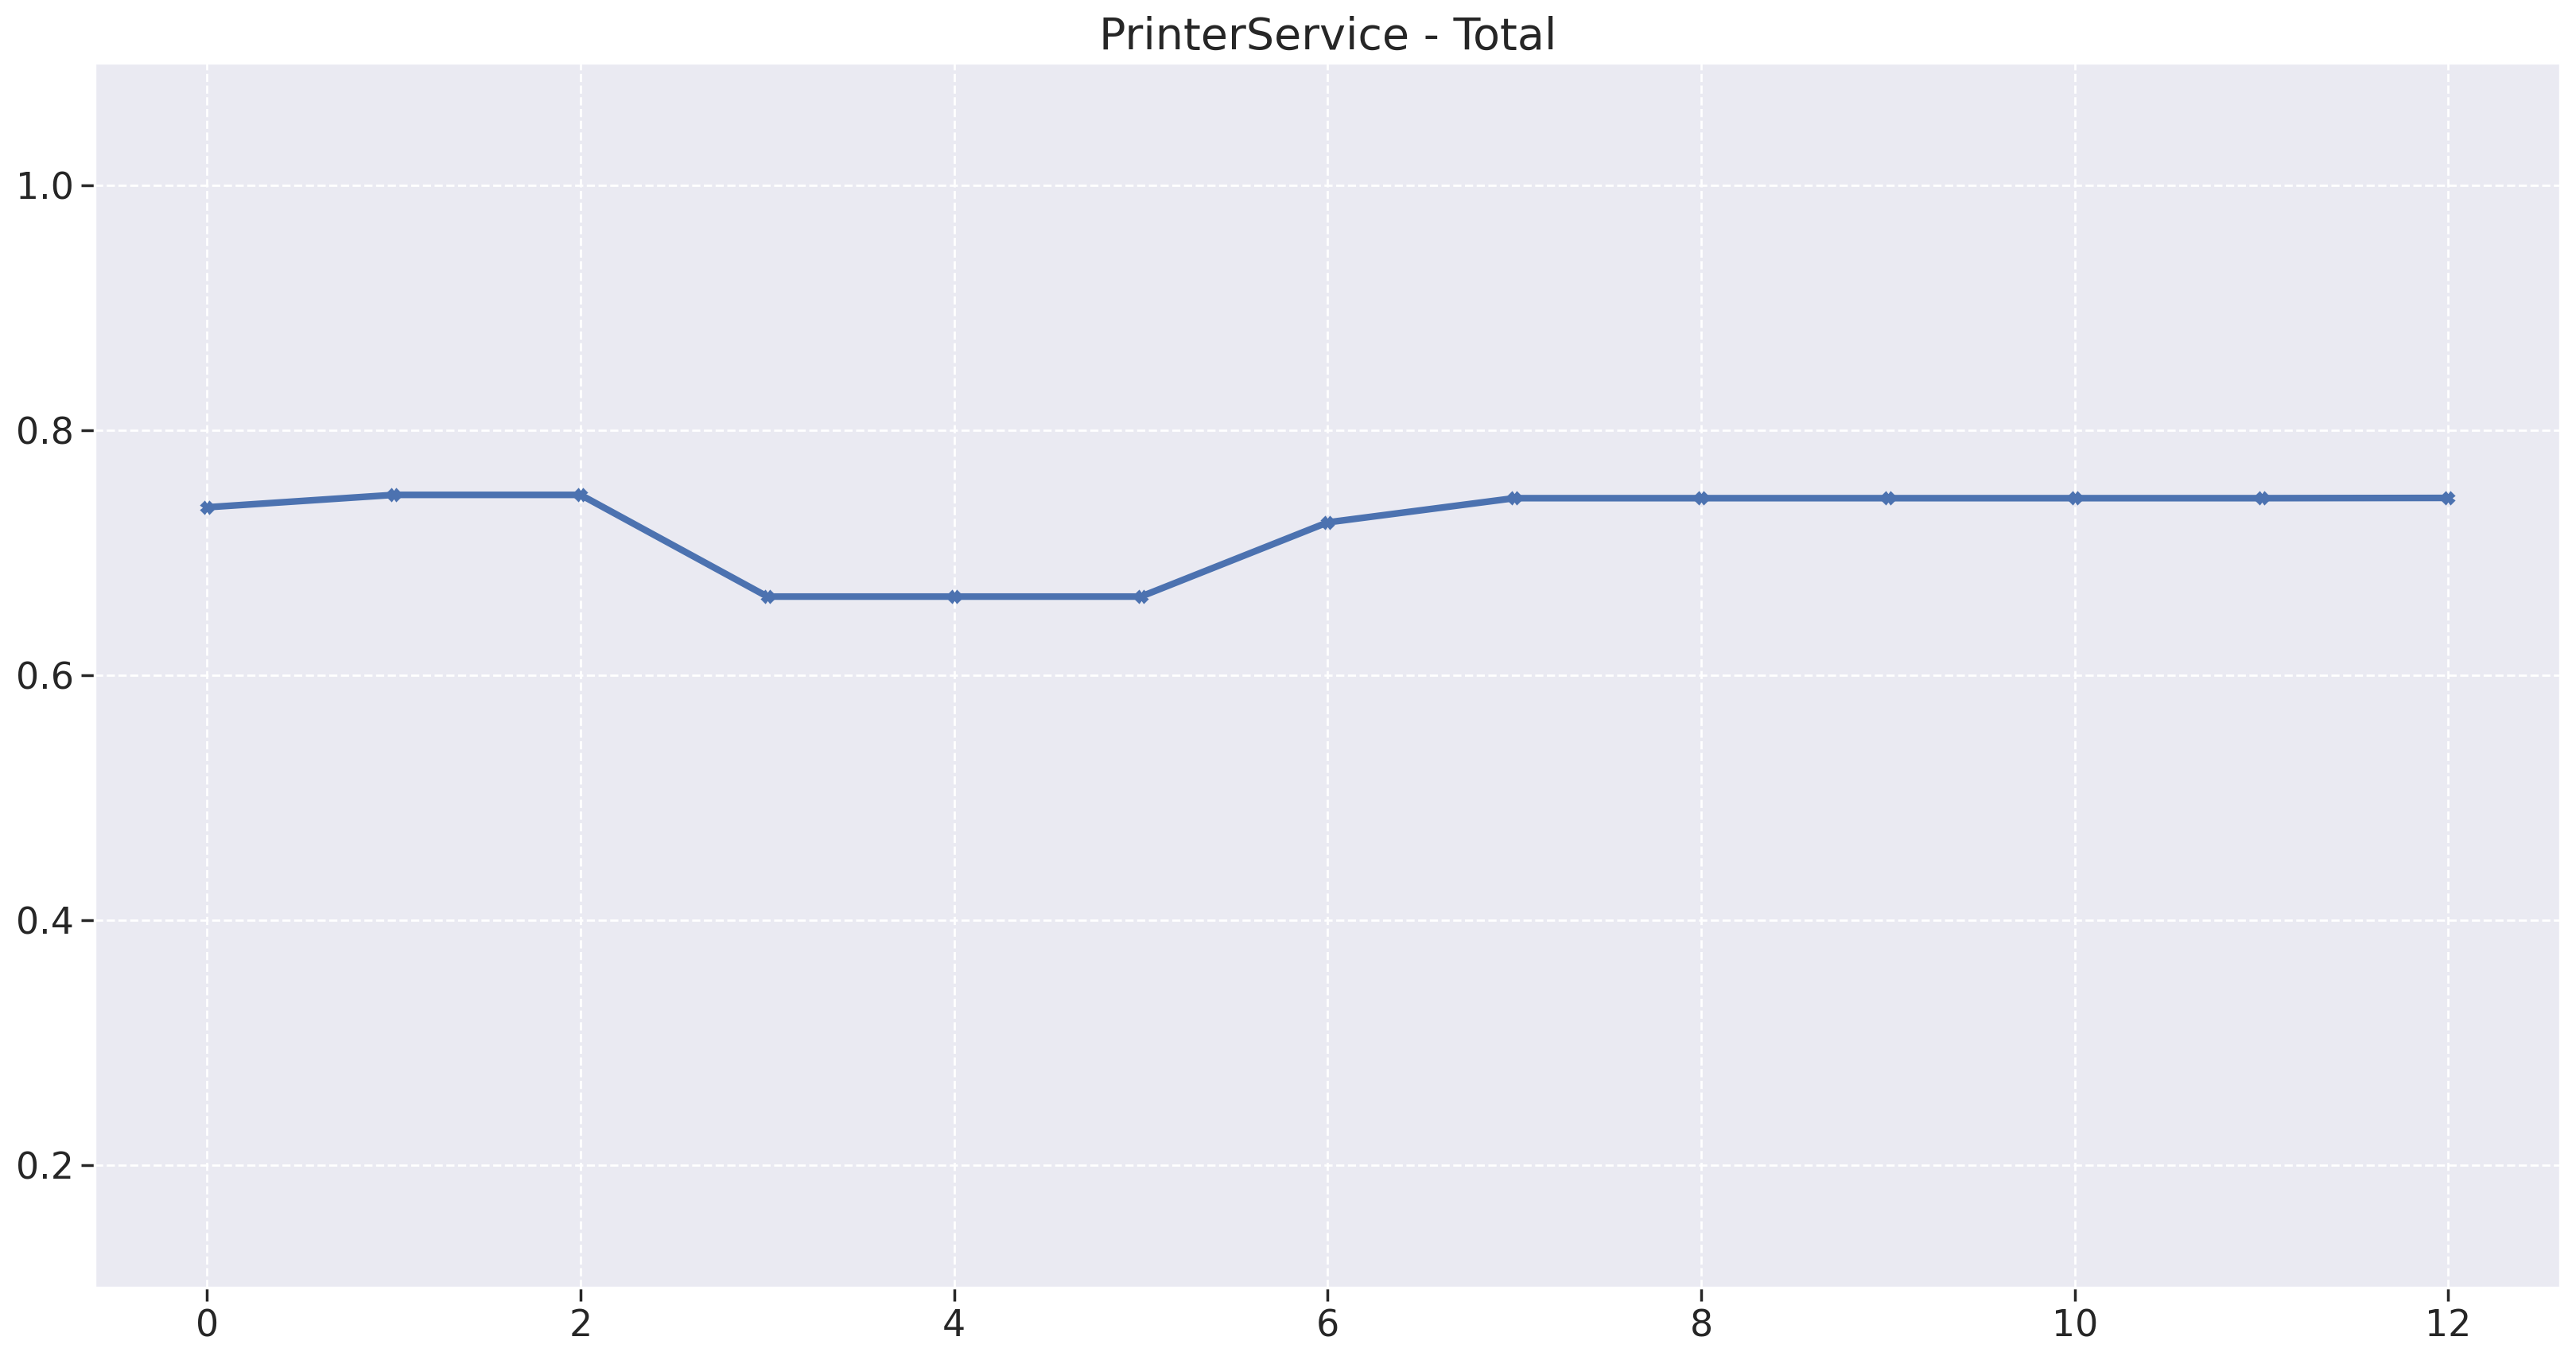

ContractService
Maintainability Stats
 mean  mode  median  std  var   min   max
0.264 0.264   0.264  0.0  0.0 0.264 0.264
Reliability Stats
 mean  mode  median  std  var  min  max
 0.25  0.25    0.25  0.0  0.0 0.25 0.25


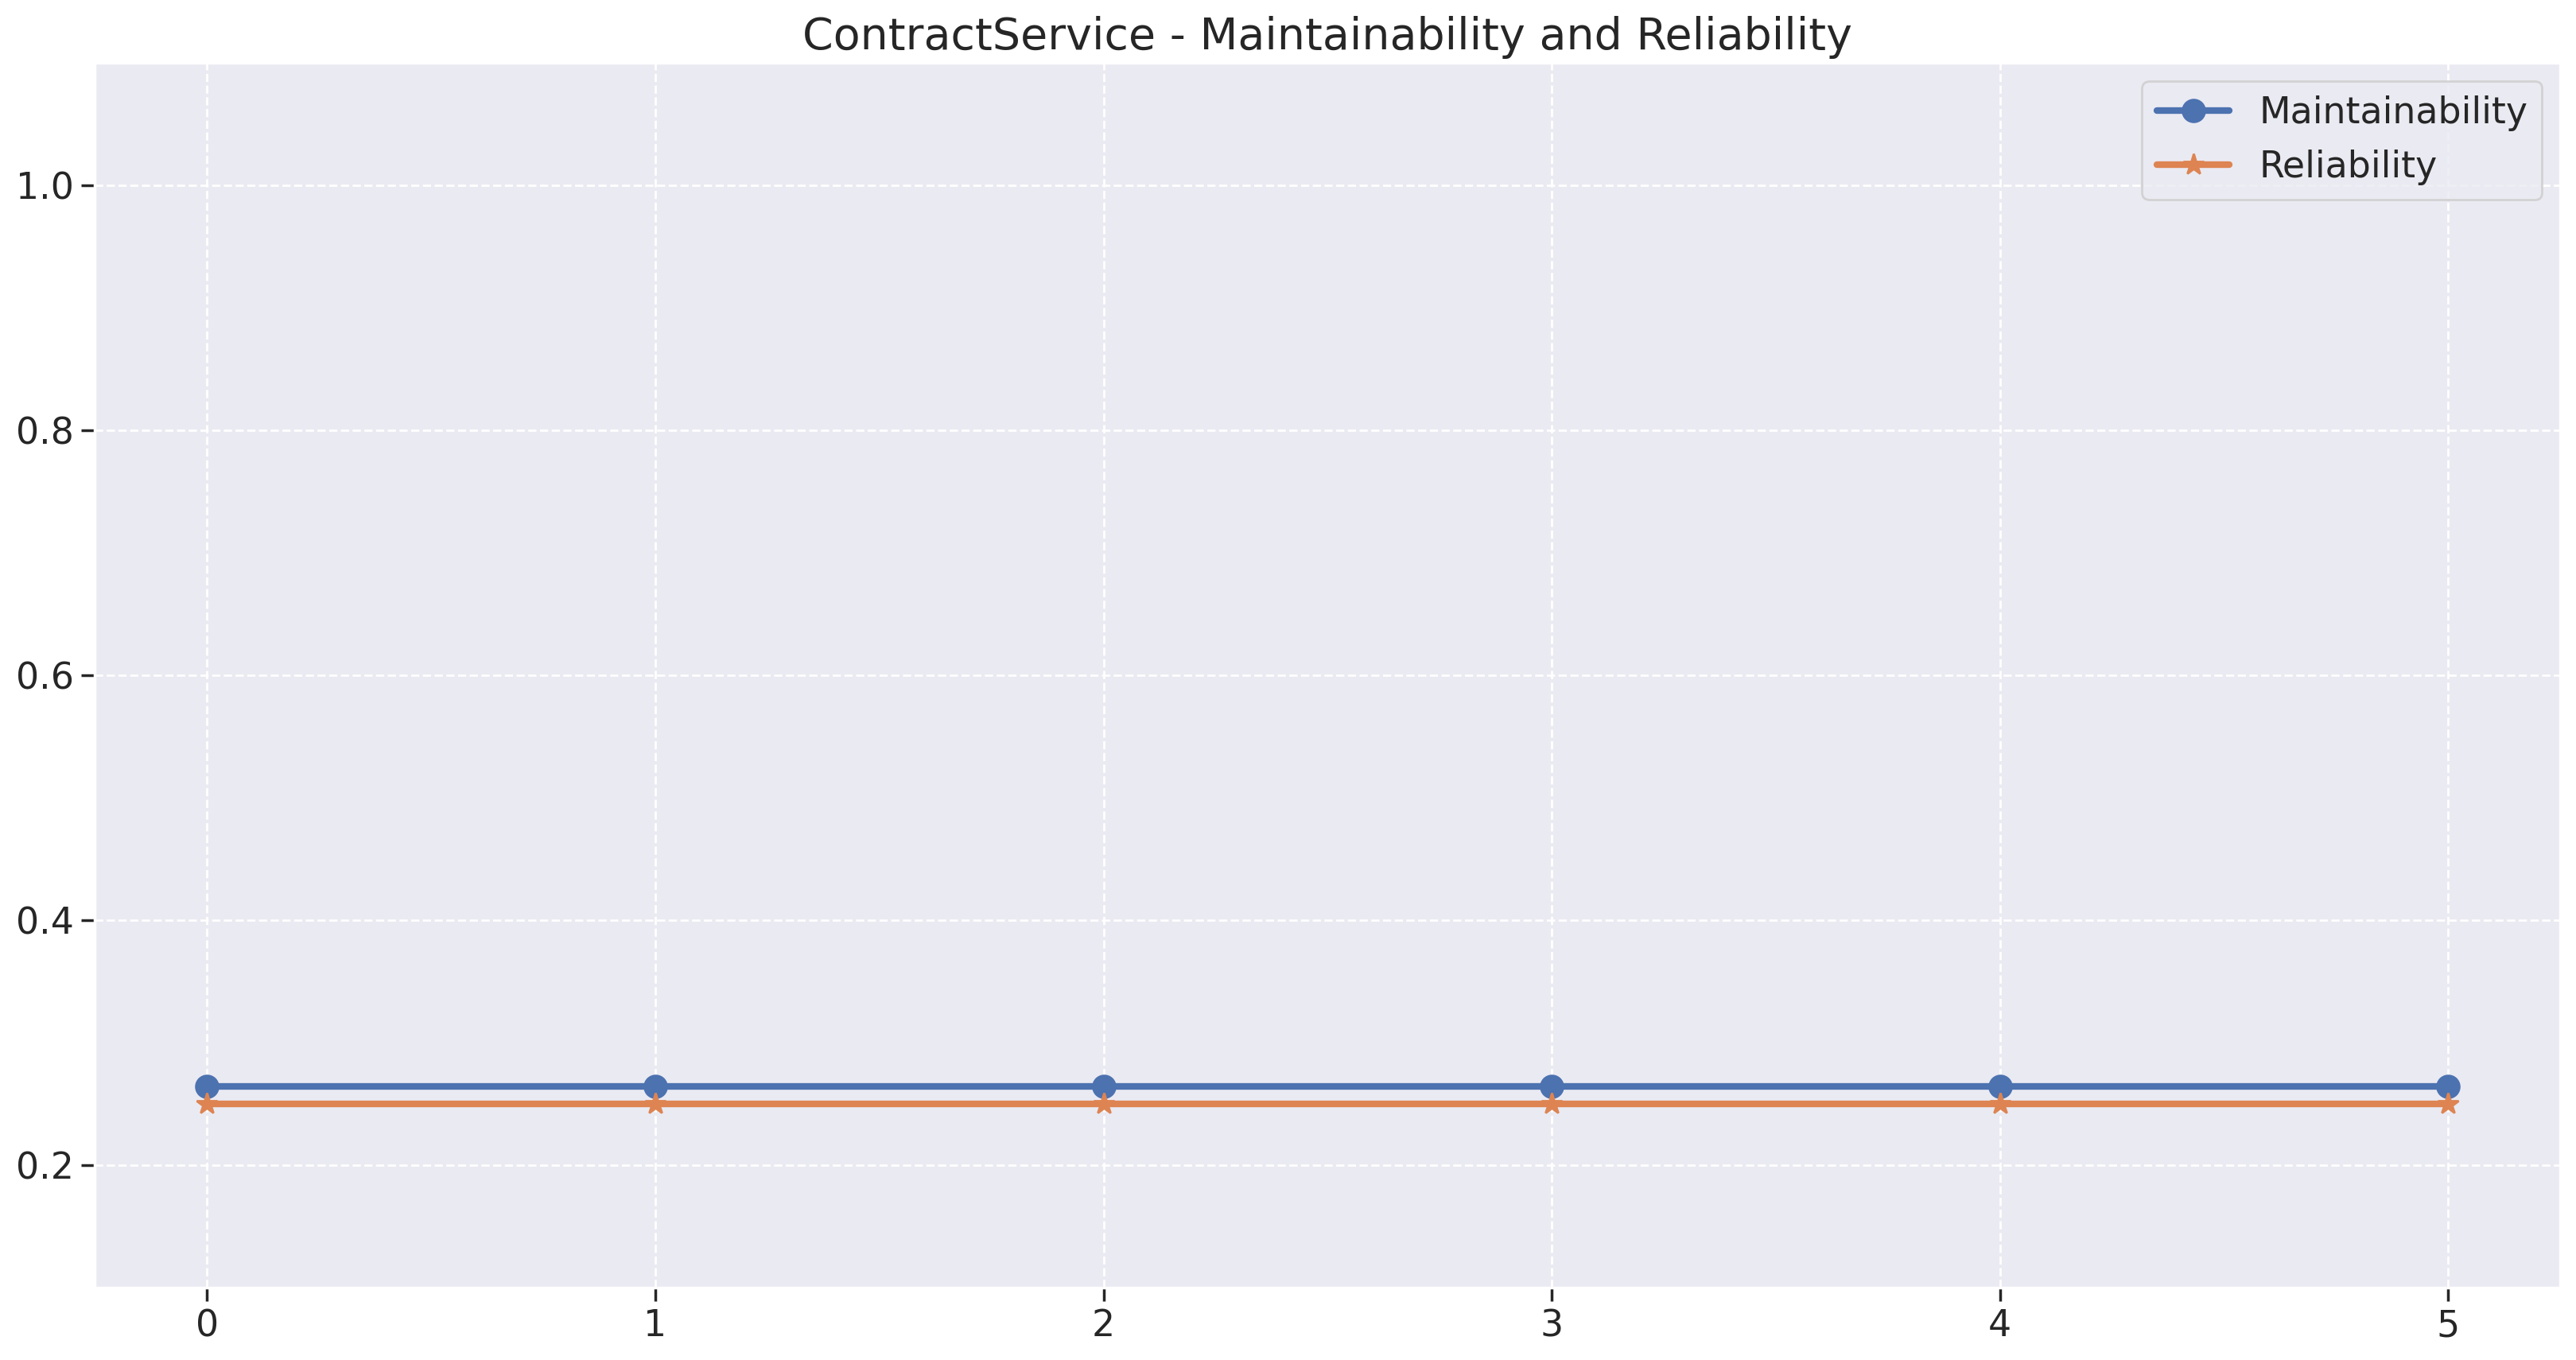

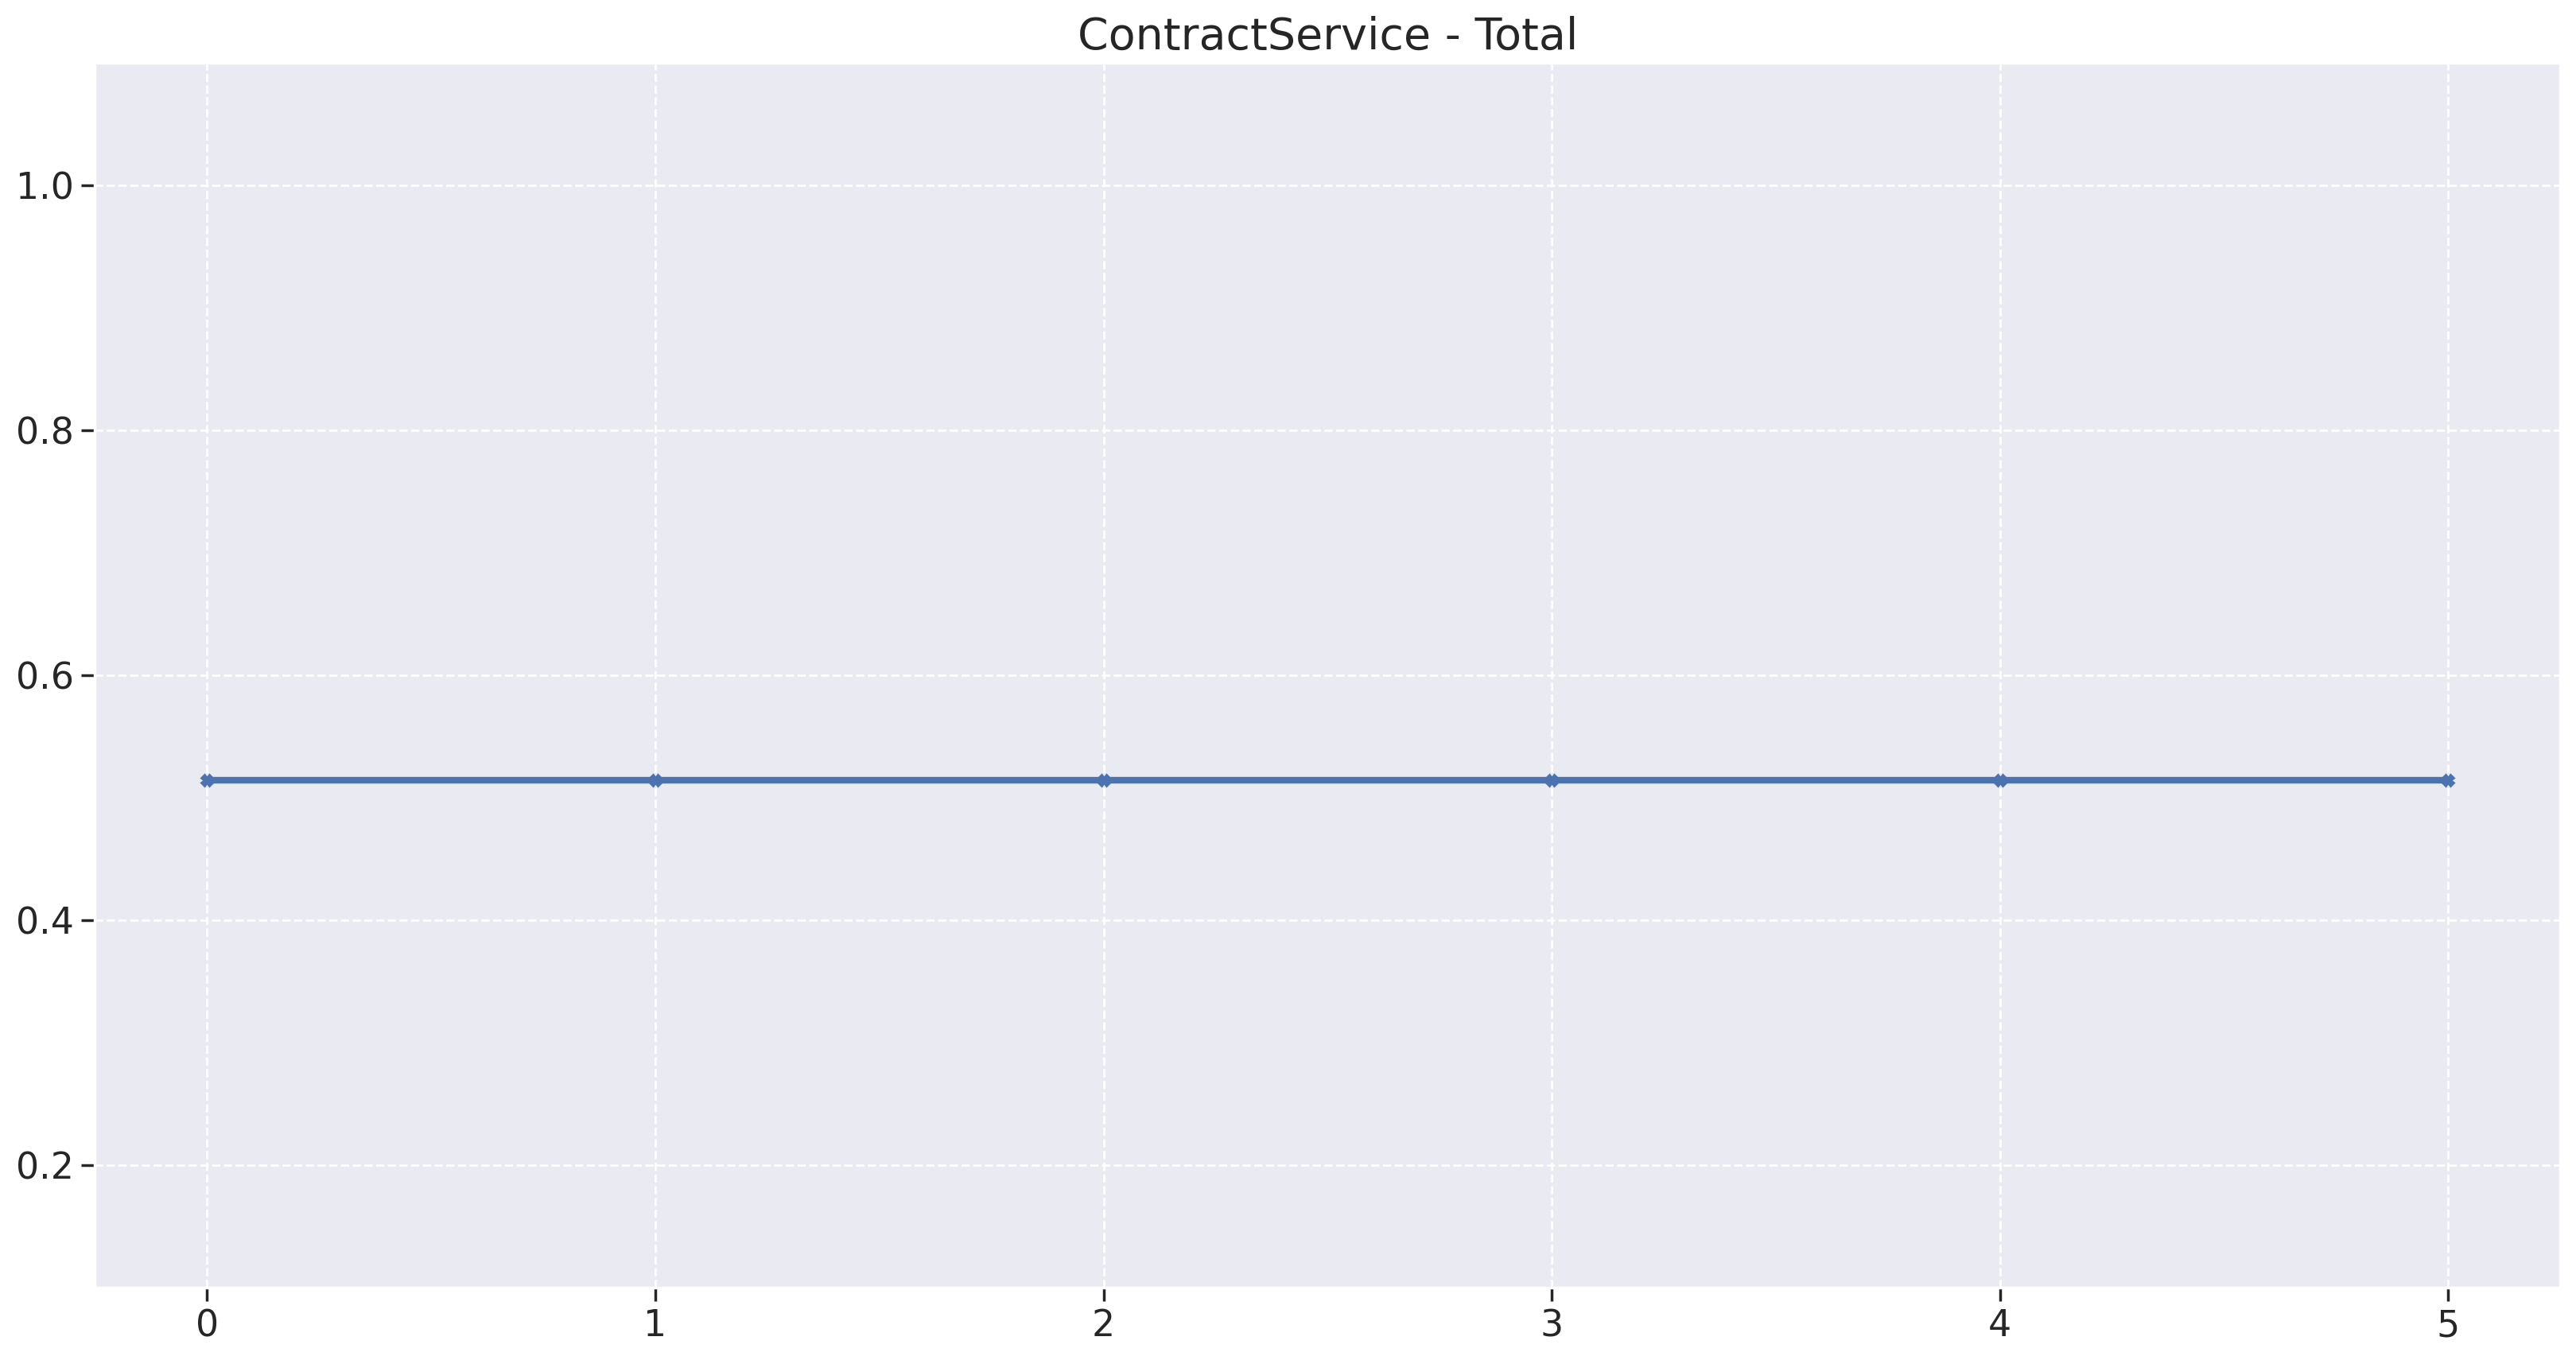

FrontEnd
Maintainability Stats
    mean     mode   median      std      var      min      max
0.314656 0.315224 0.314997 0.002142 0.000005 0.309878 0.320149
Reliability Stats
    mean     mode   median      std      var      min     max
0.351233 0.380282 0.383435 0.093154 0.008678 0.128906 0.45122


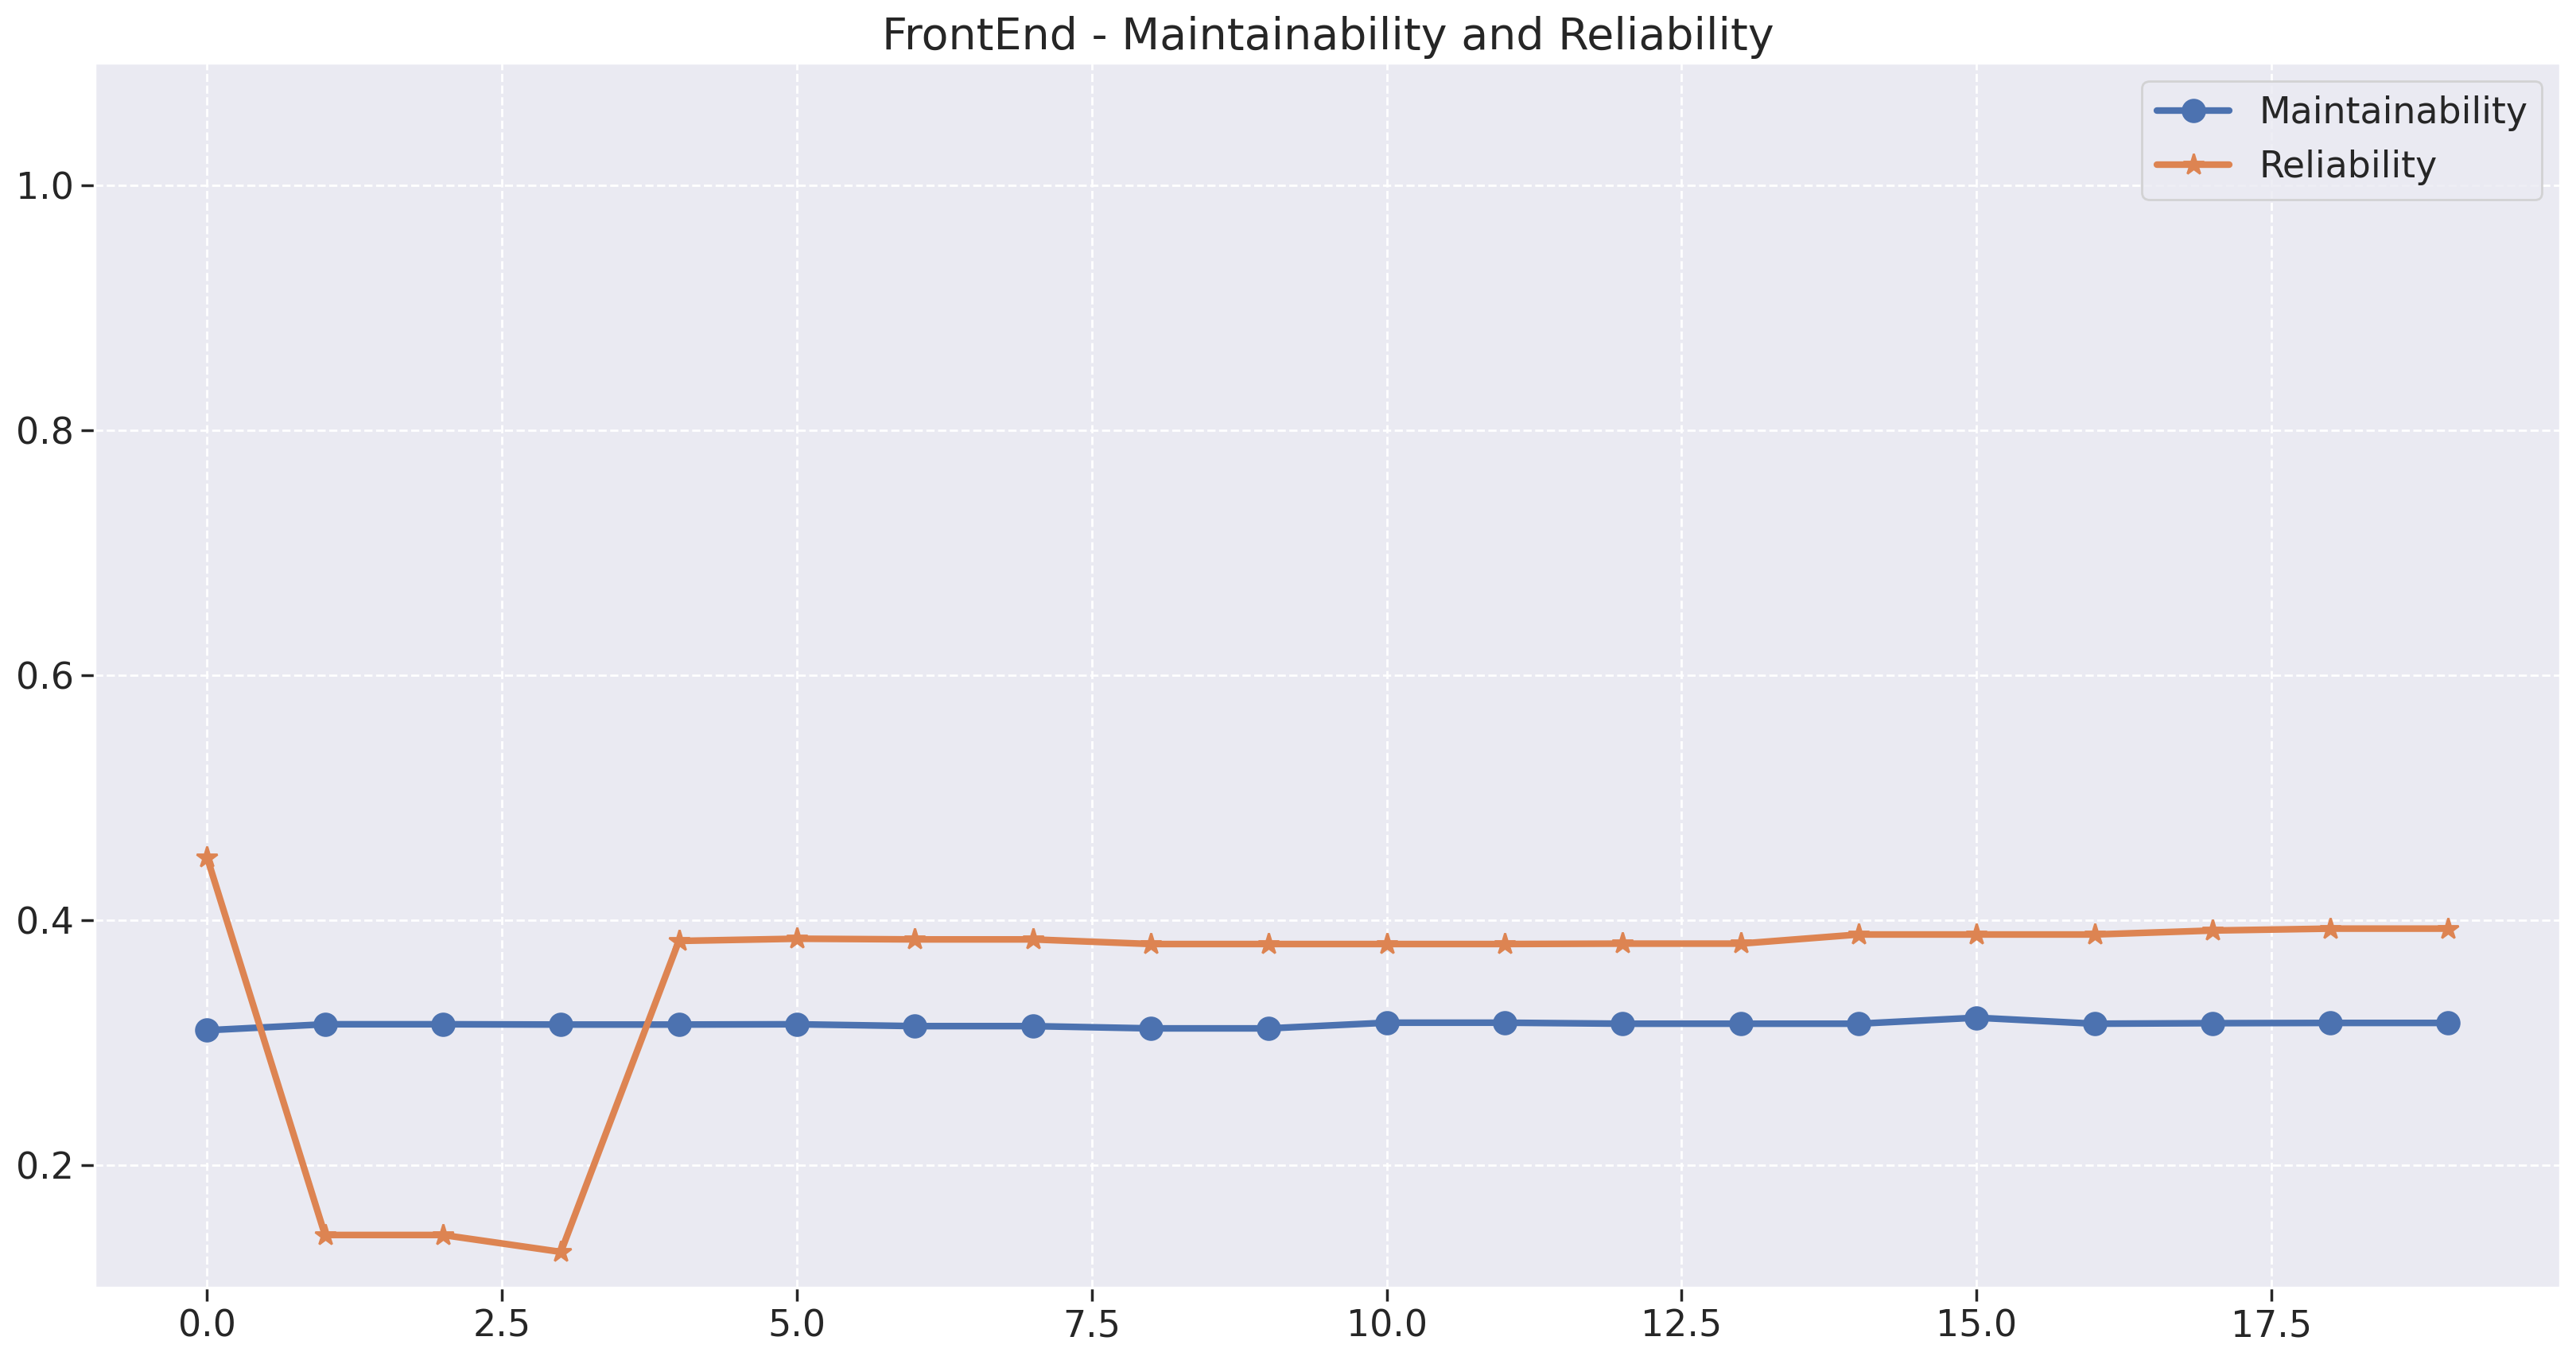

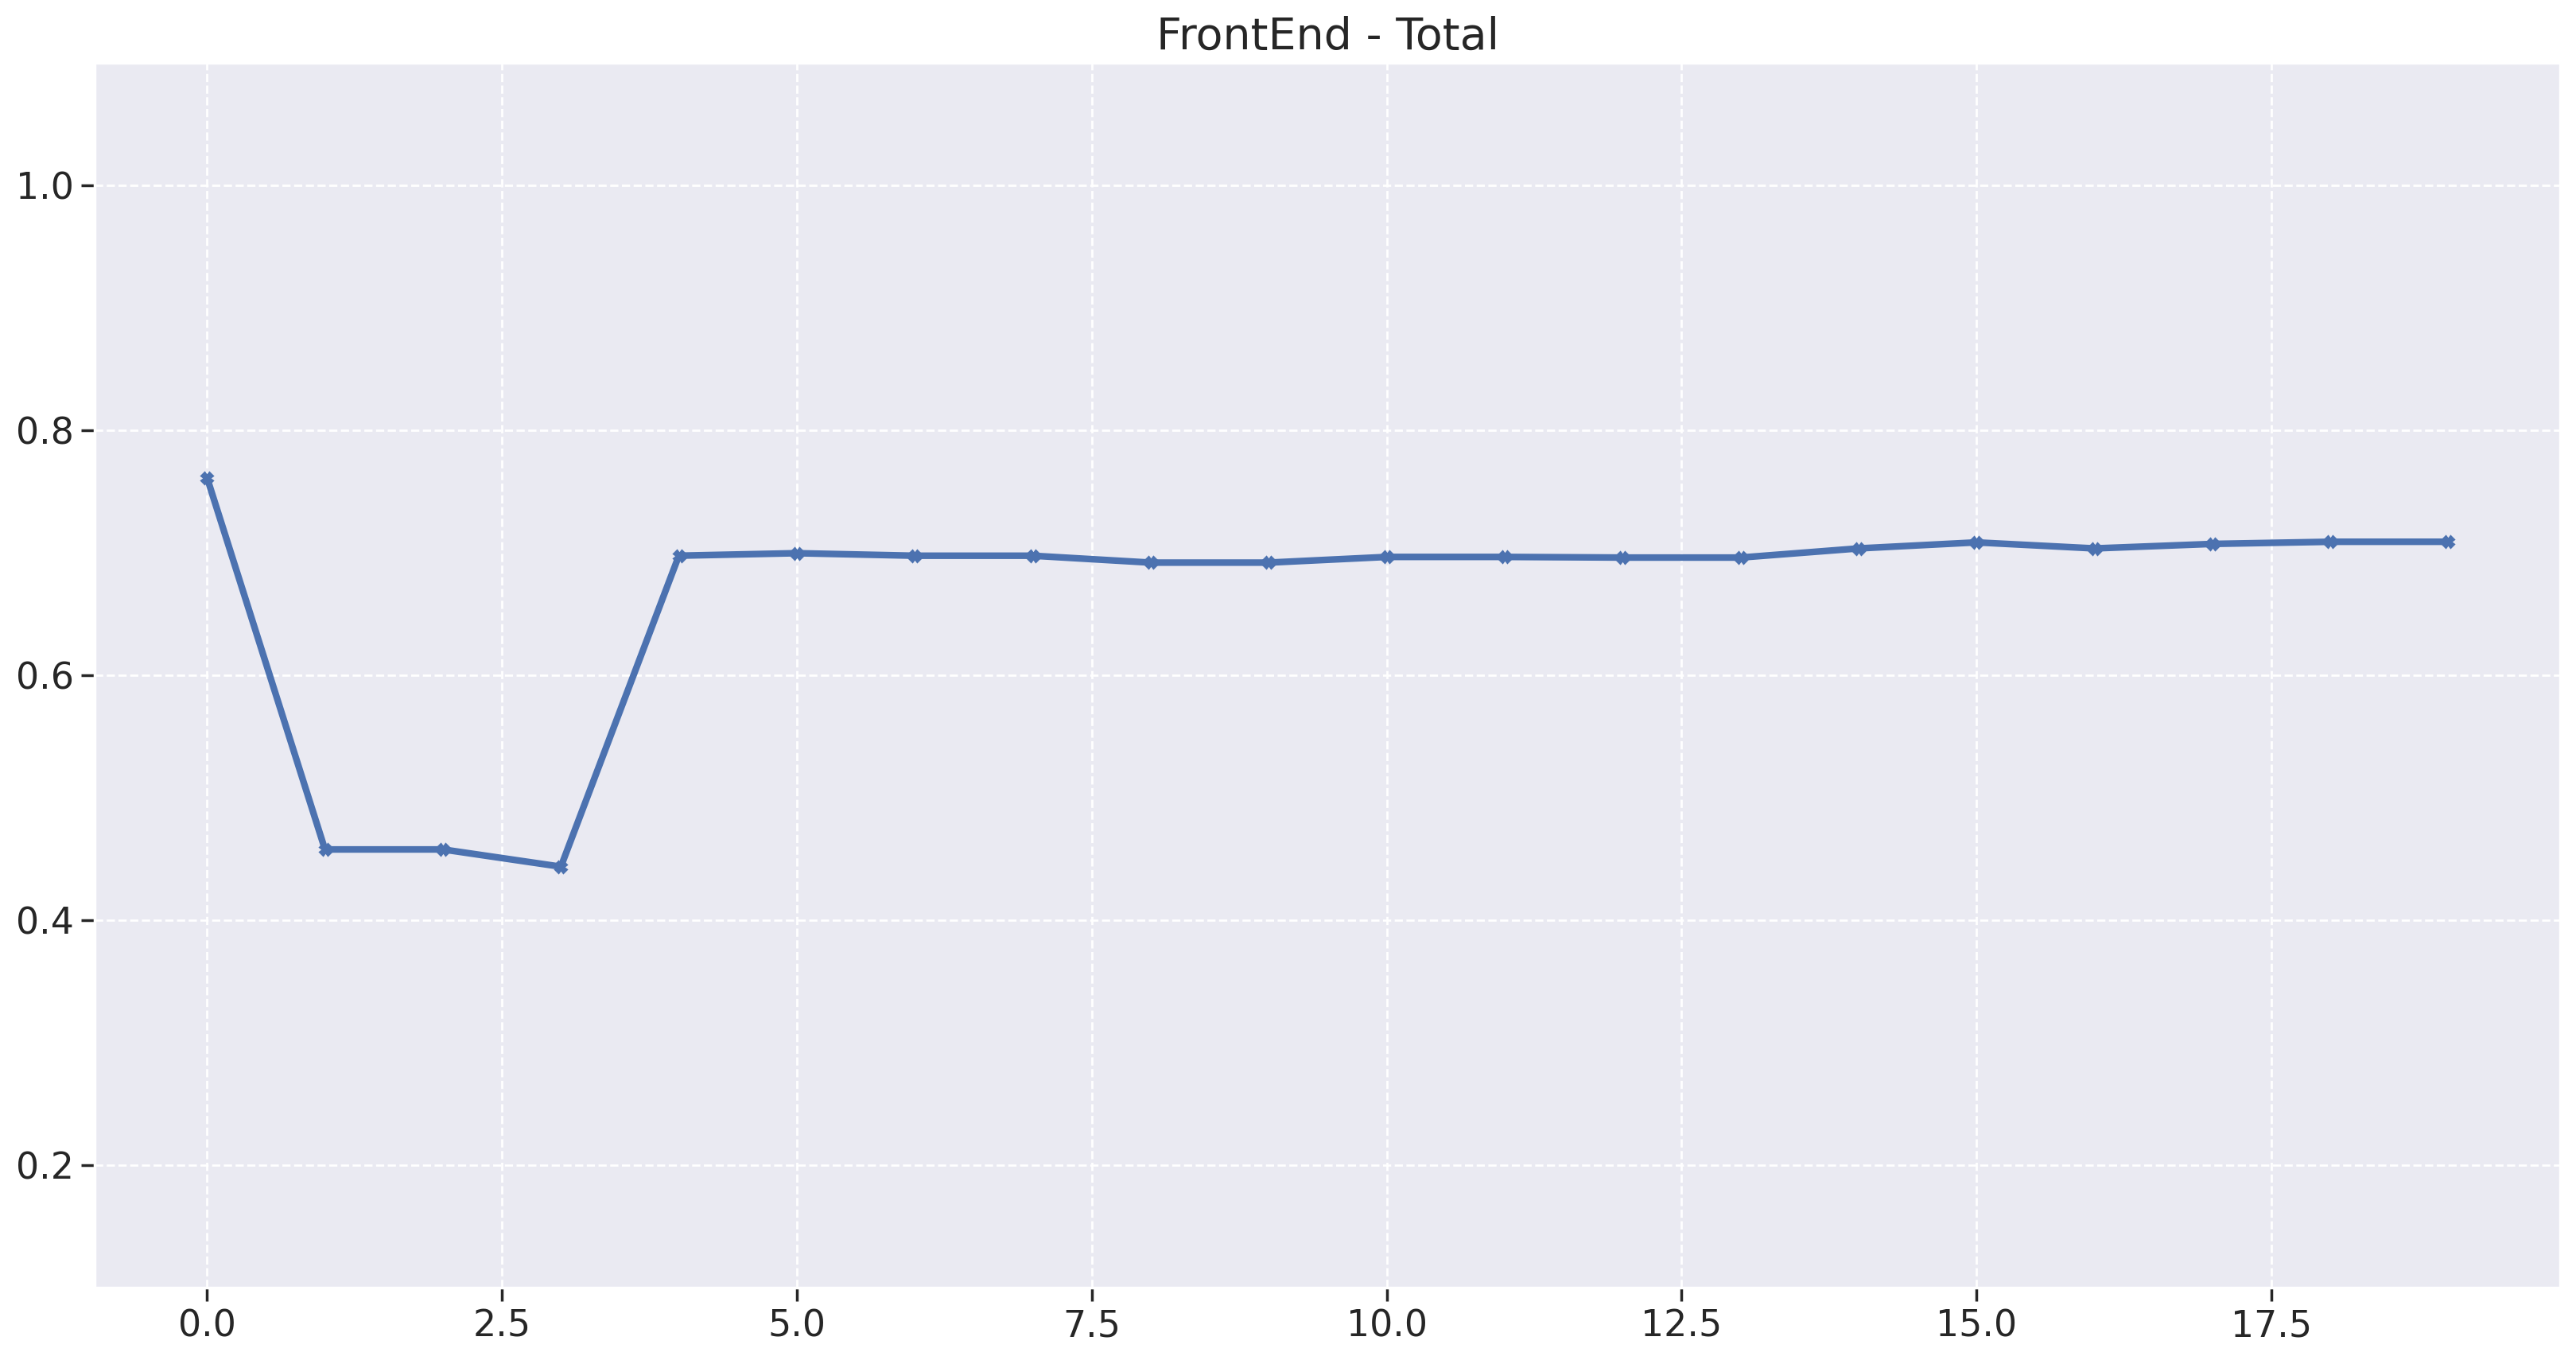

ApiGateway
Maintainability Stats
 mean  mode  median  std  var  min  max
 0.33  0.33    0.33  0.0  0.0 0.33 0.33
Reliability Stats
    mean  mode  median      std      var   min  max
0.364583   0.5 0.46875 0.187152 0.035026 0.125  0.5


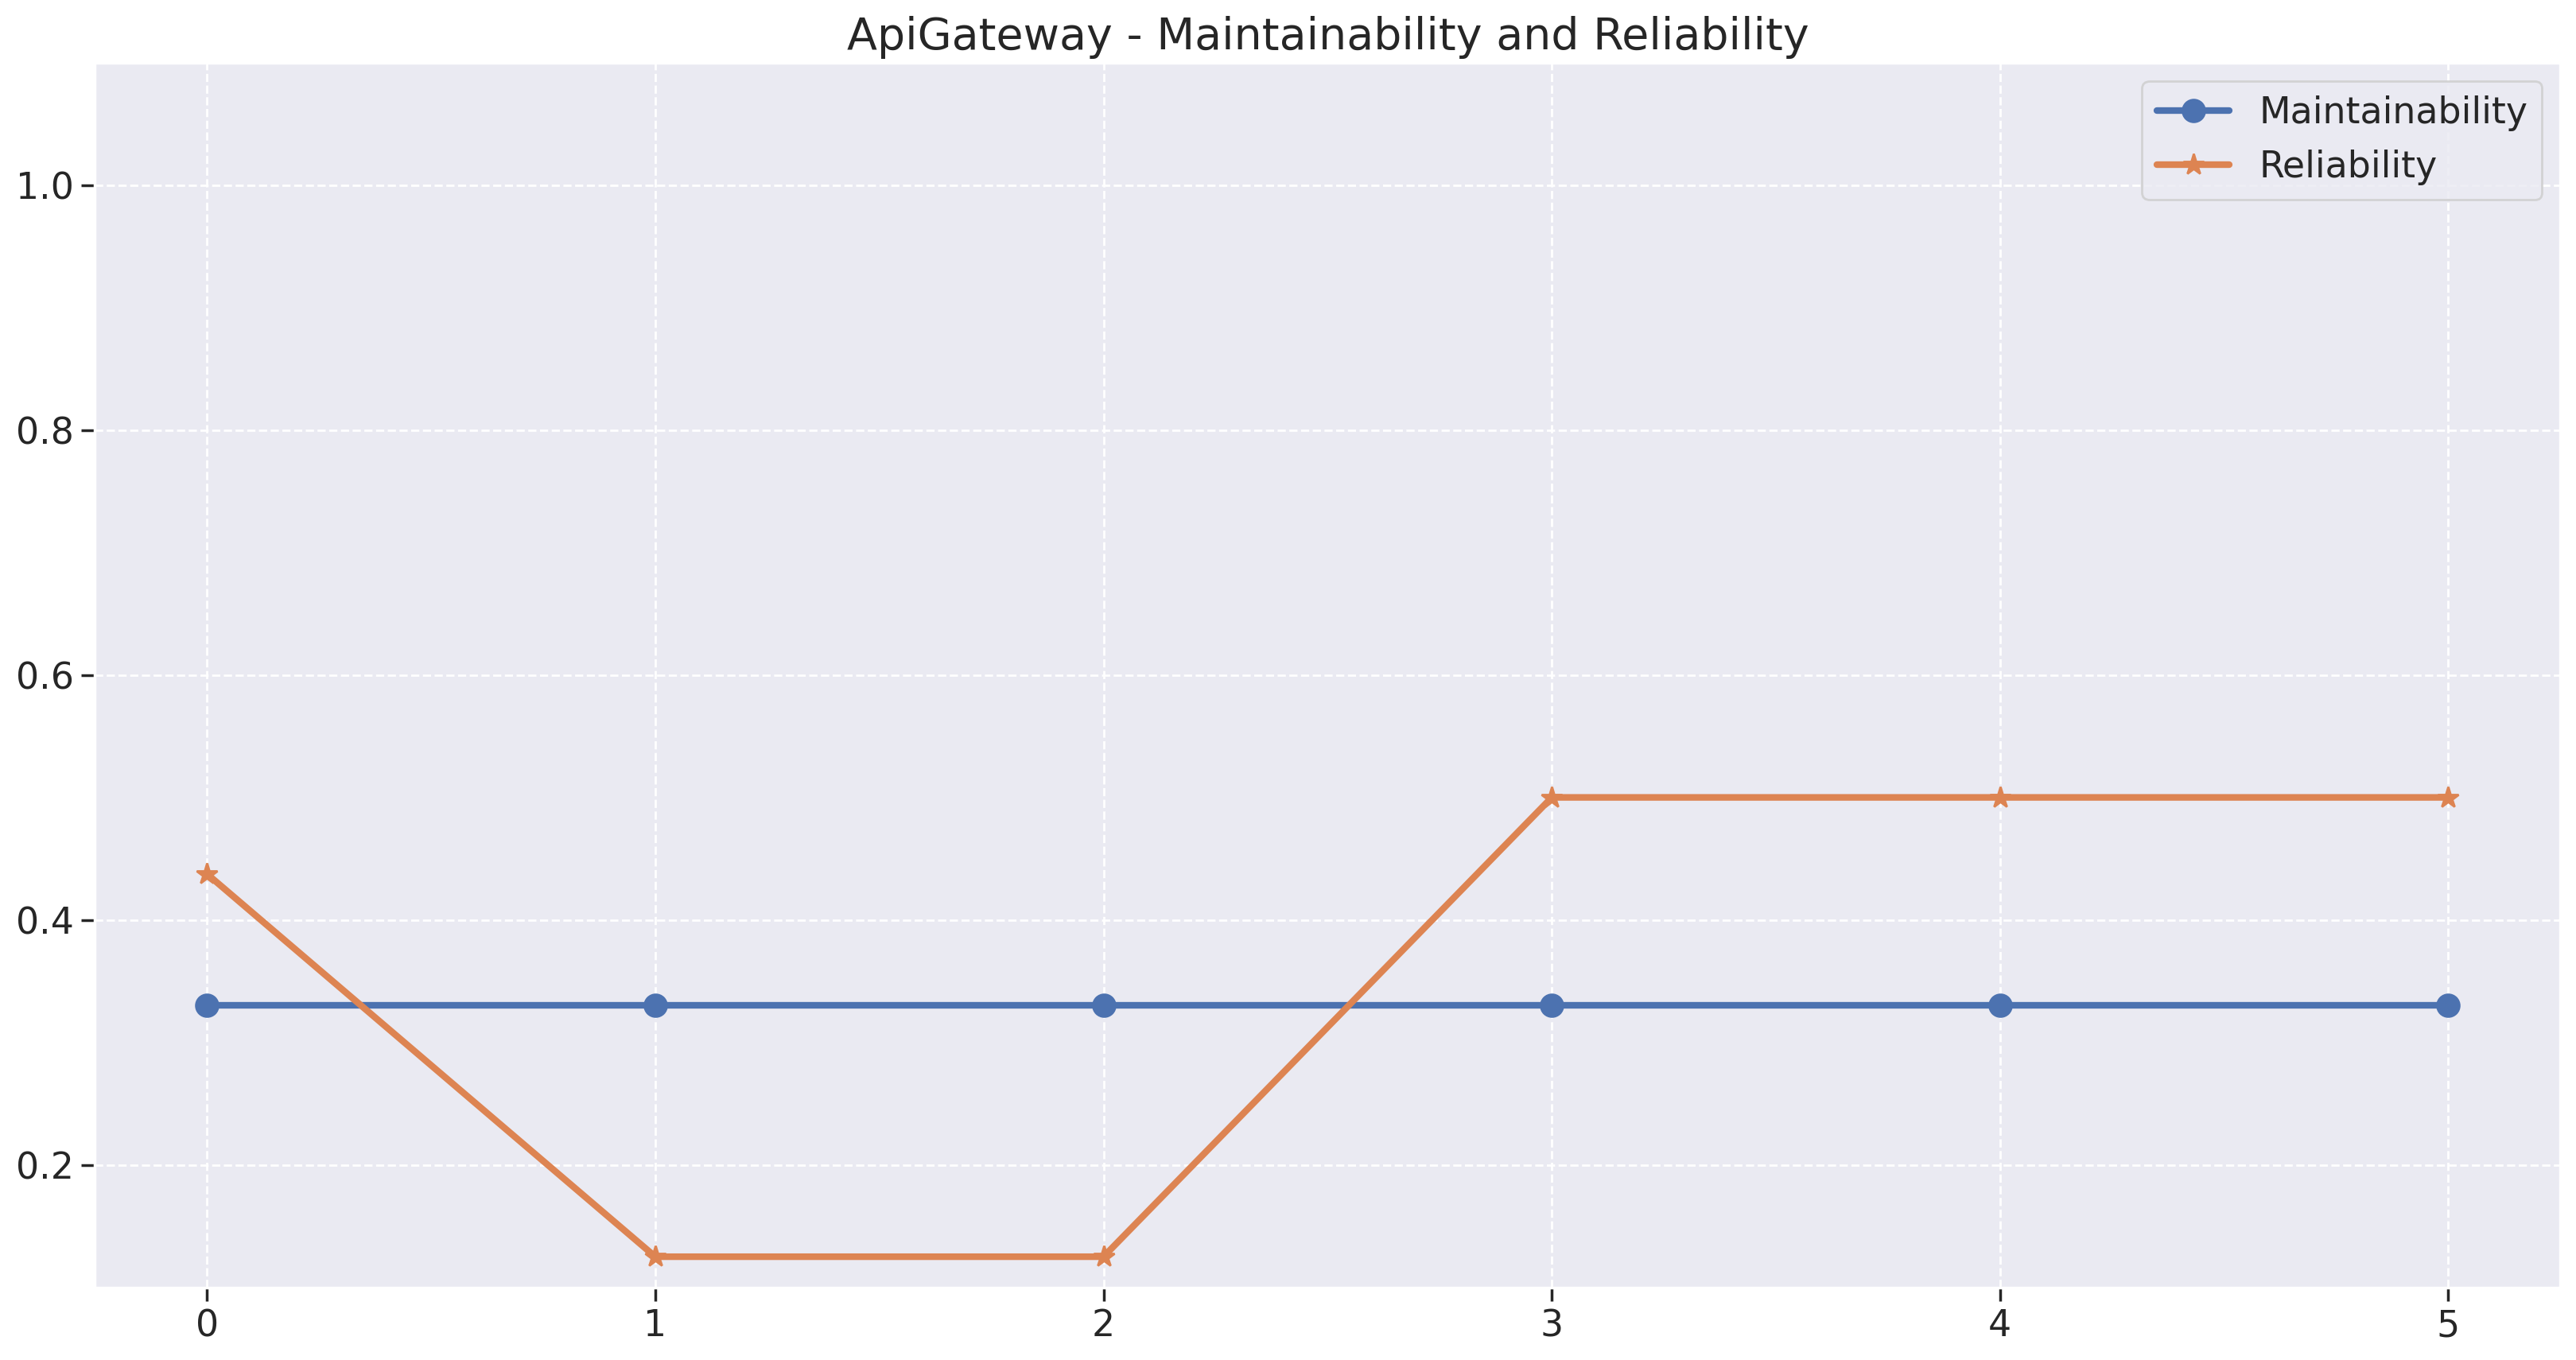

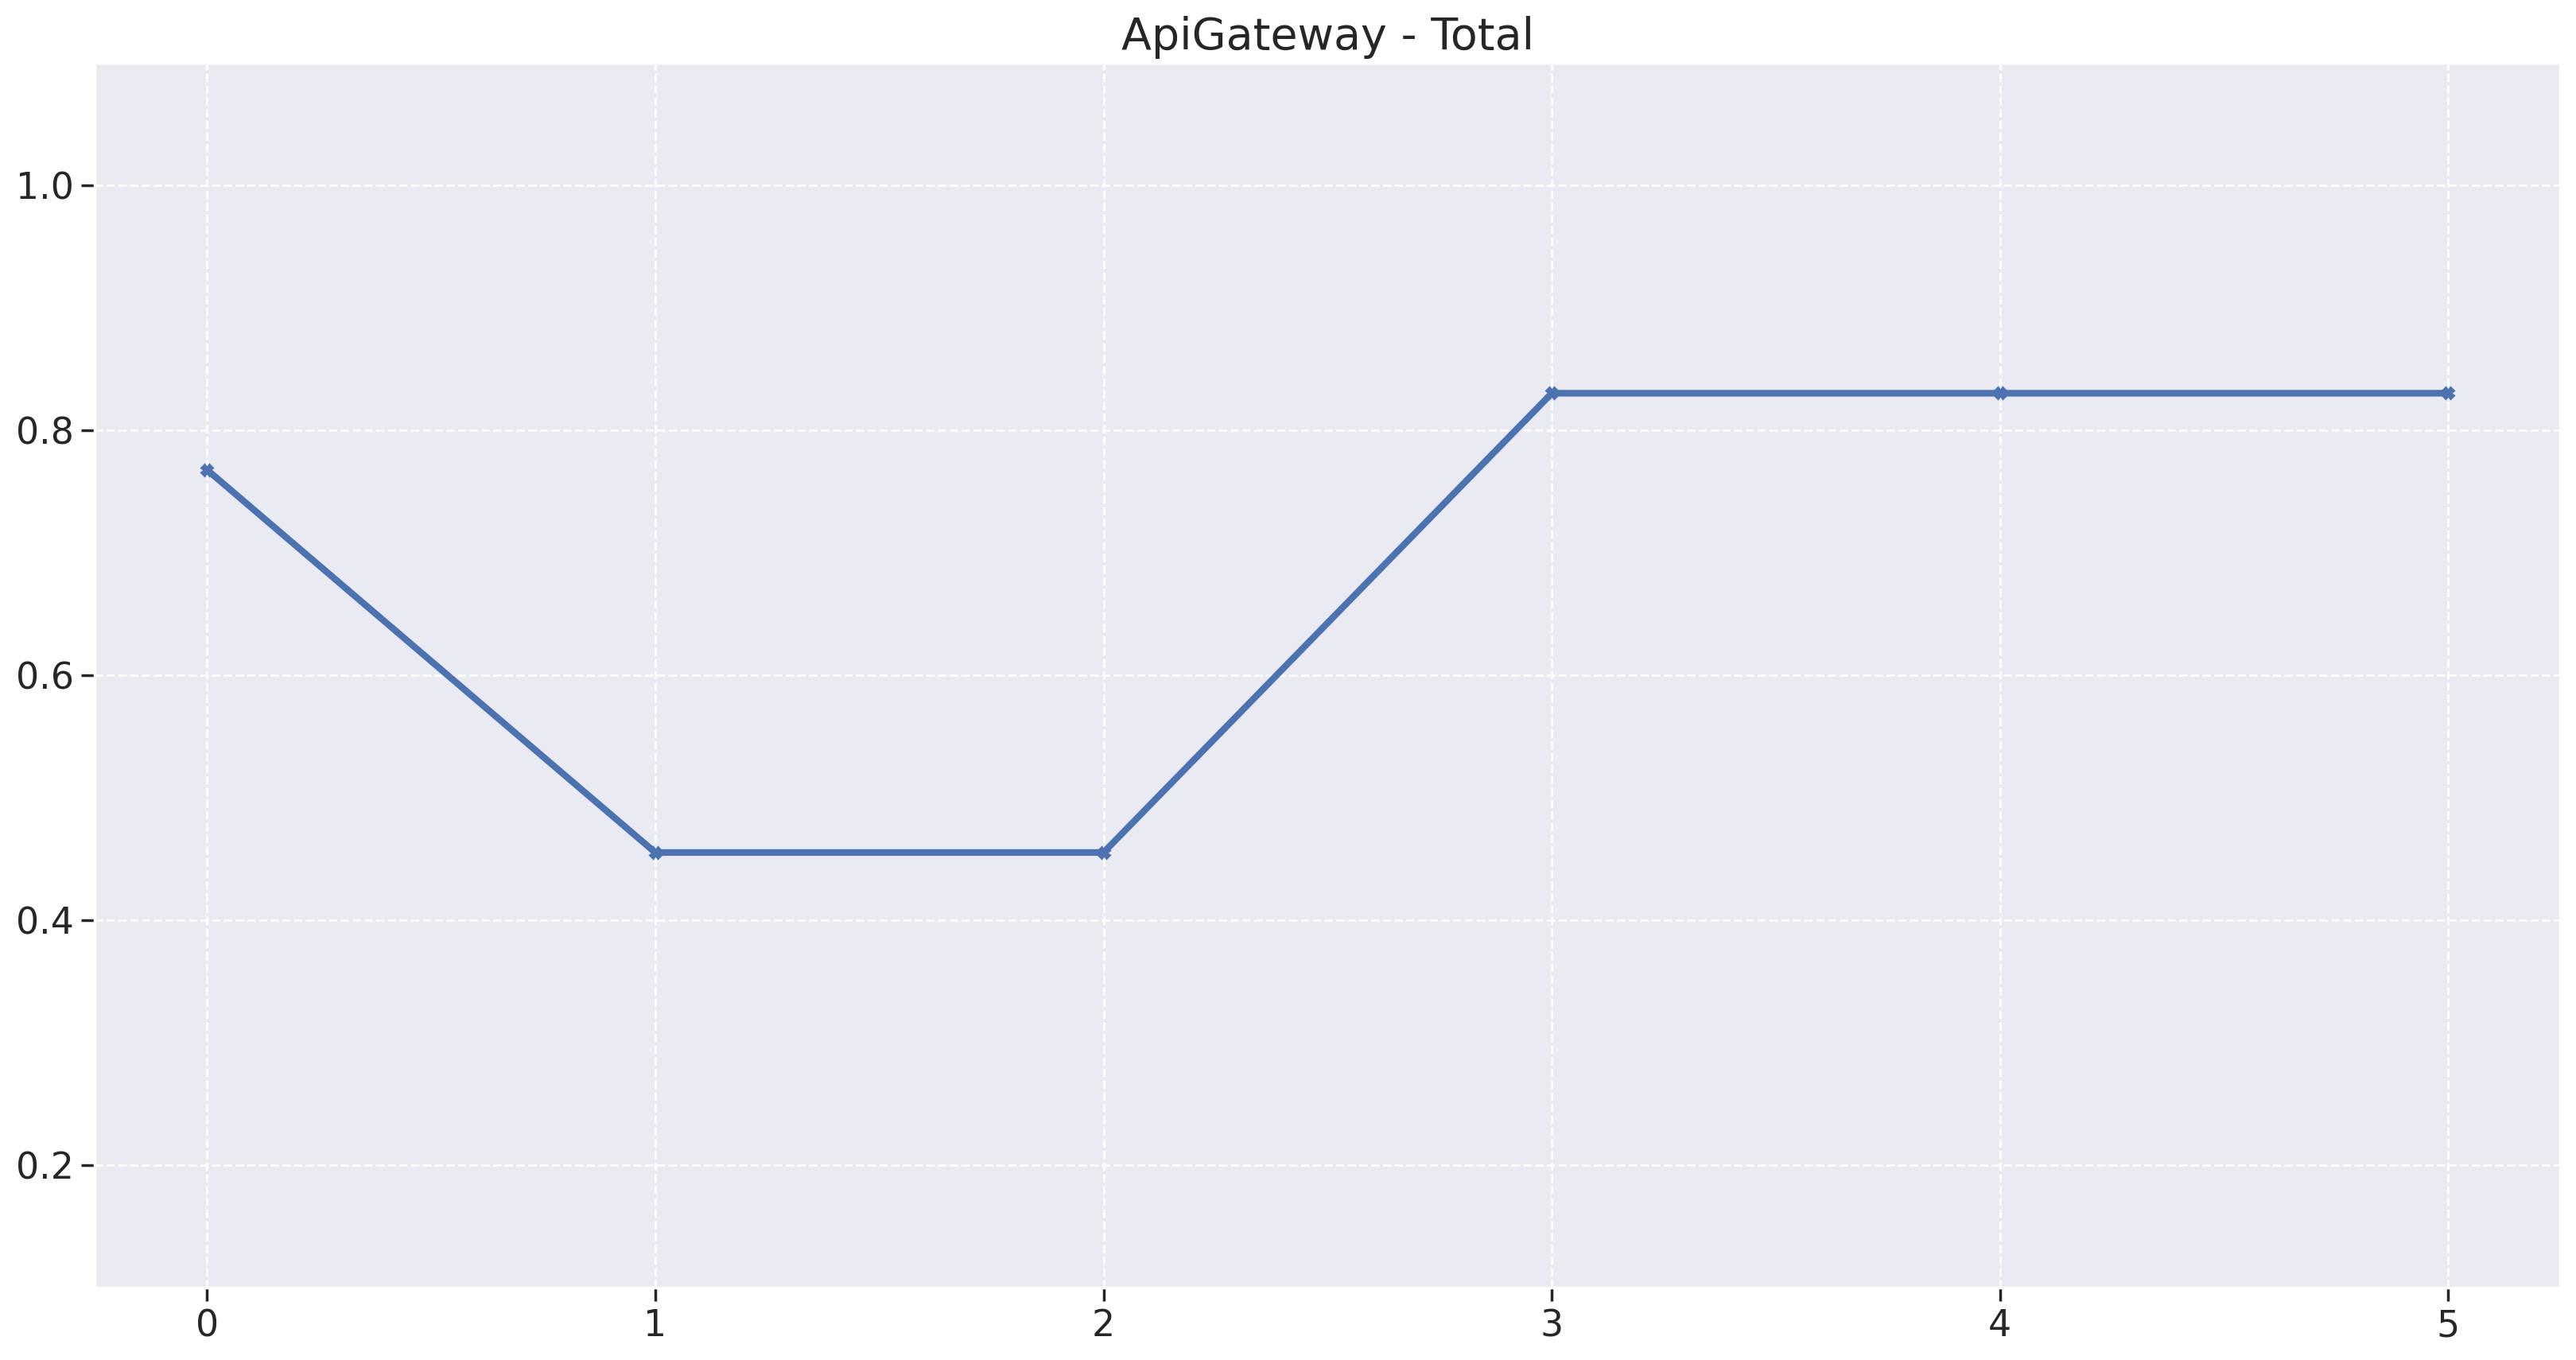

UserService
Maintainability Stats
    mean     mode   median std var      min      max
0.268125 0.268125 0.268125 NaN NaN 0.268125 0.268125
Reliability Stats
    mean     mode   median std var      min      max
0.400219 0.400219 0.400219 NaN NaN 0.400219 0.400219


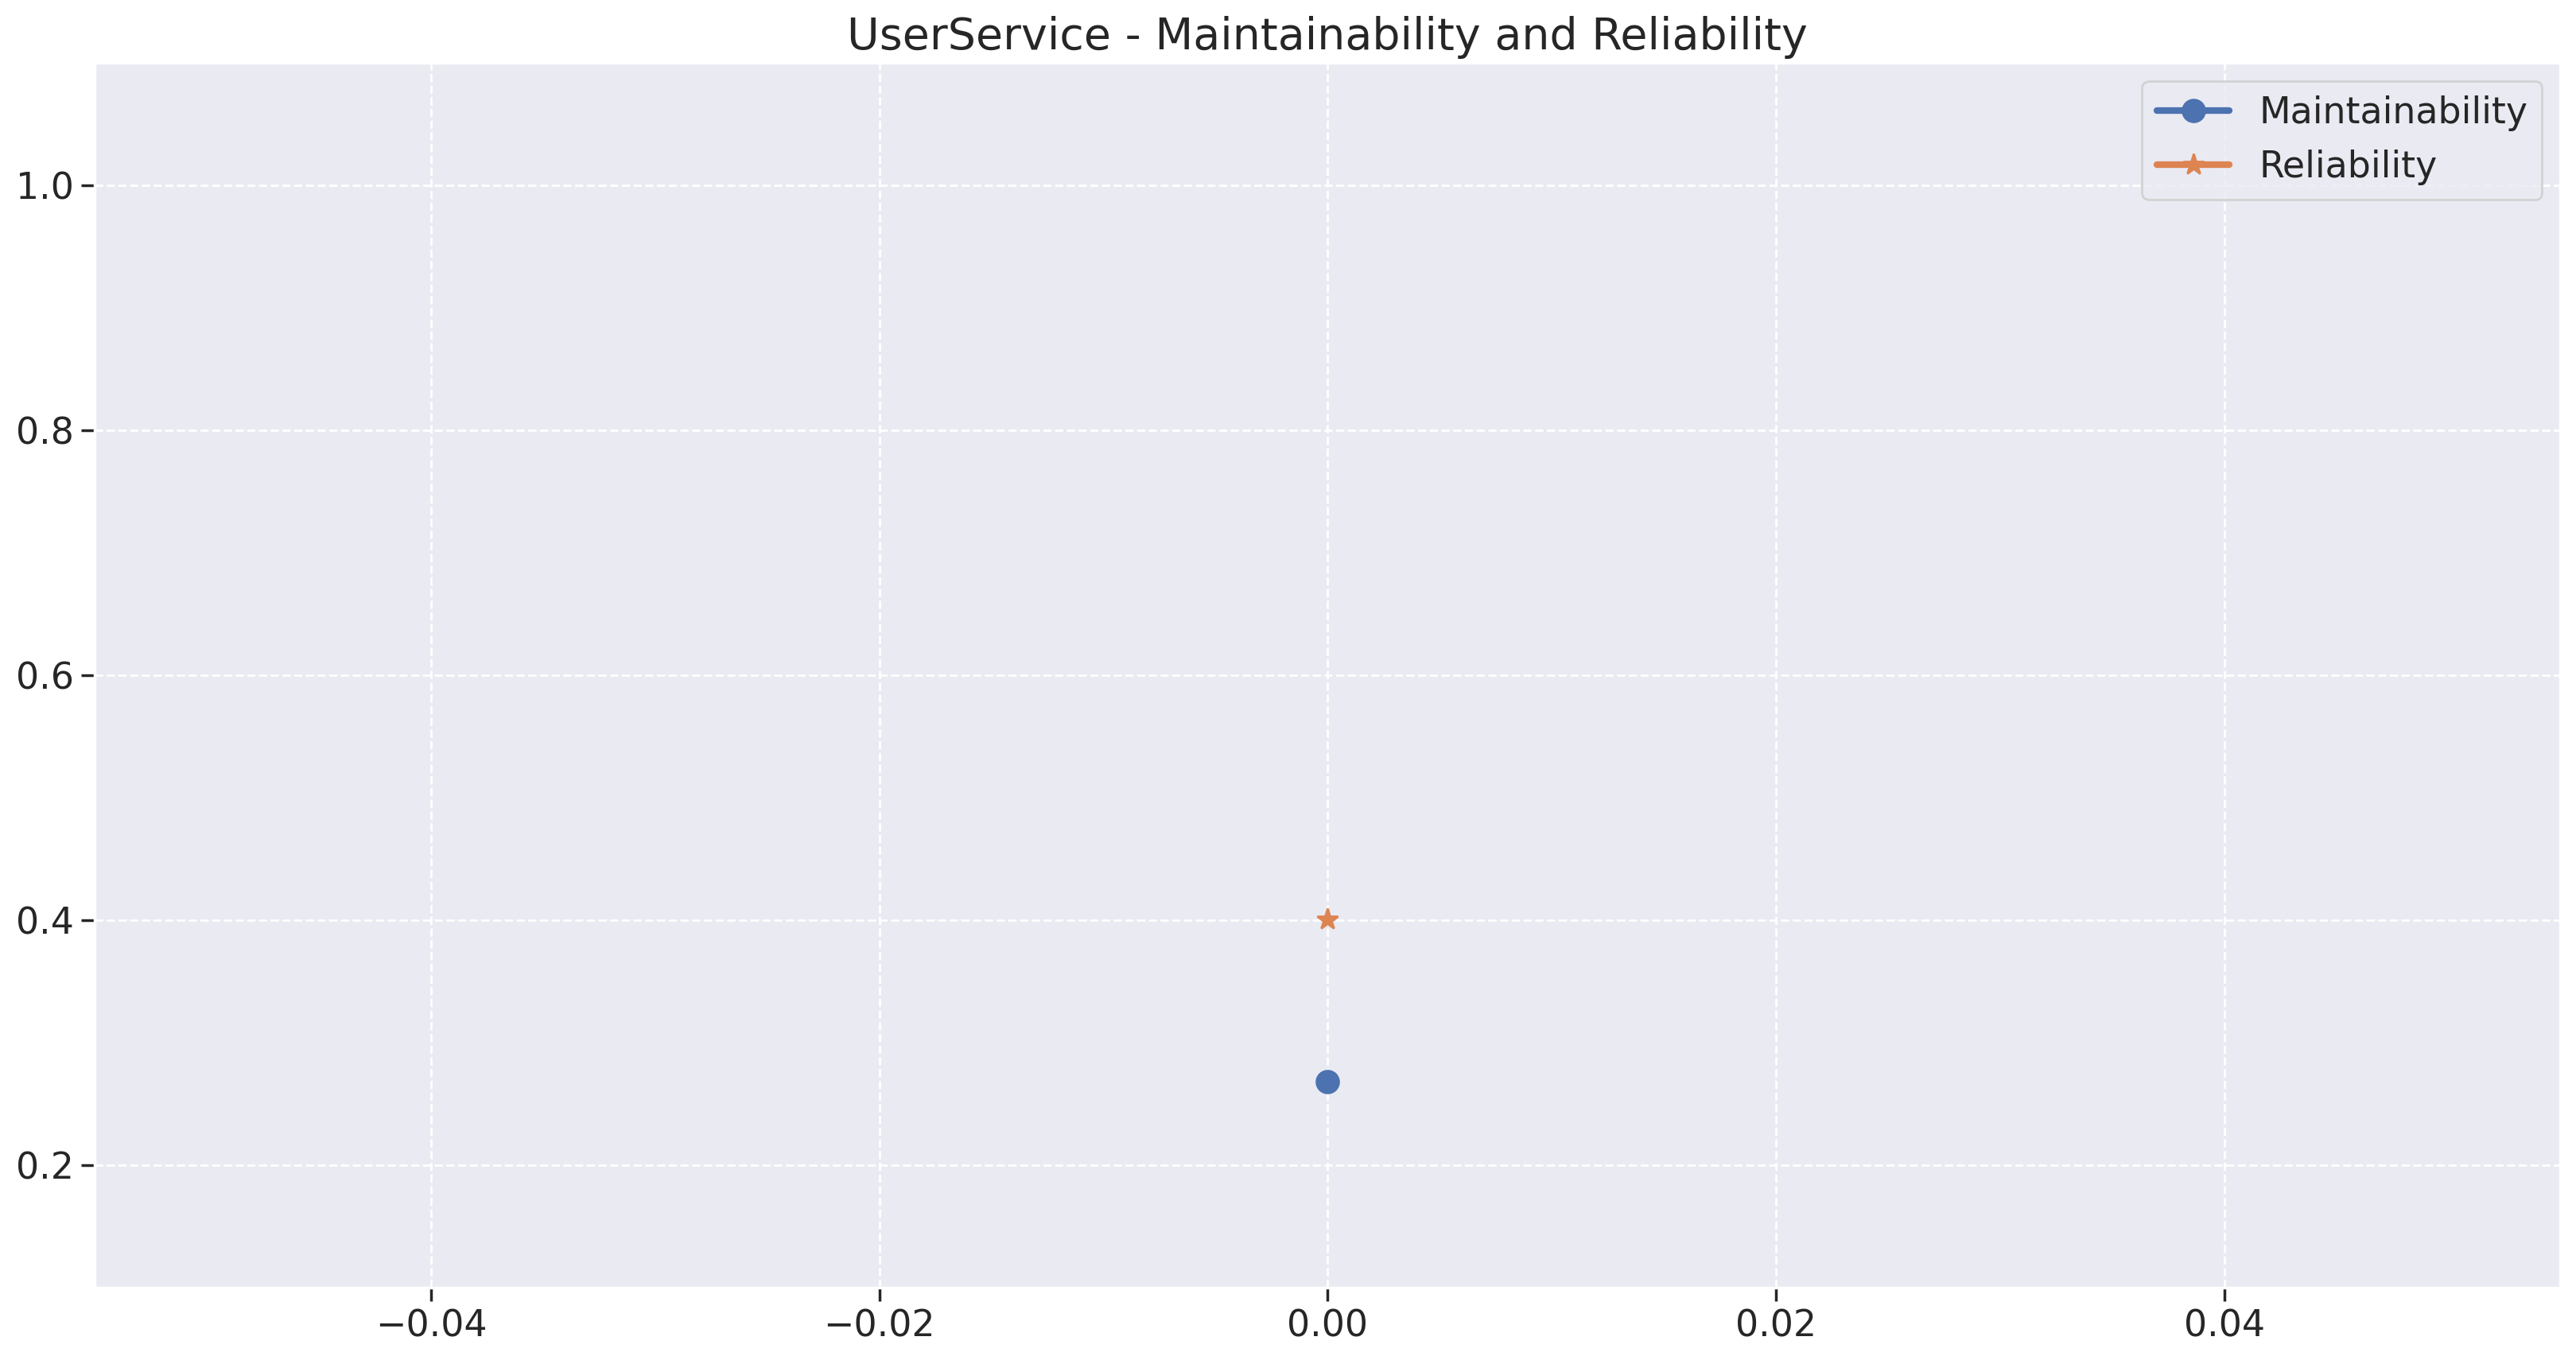

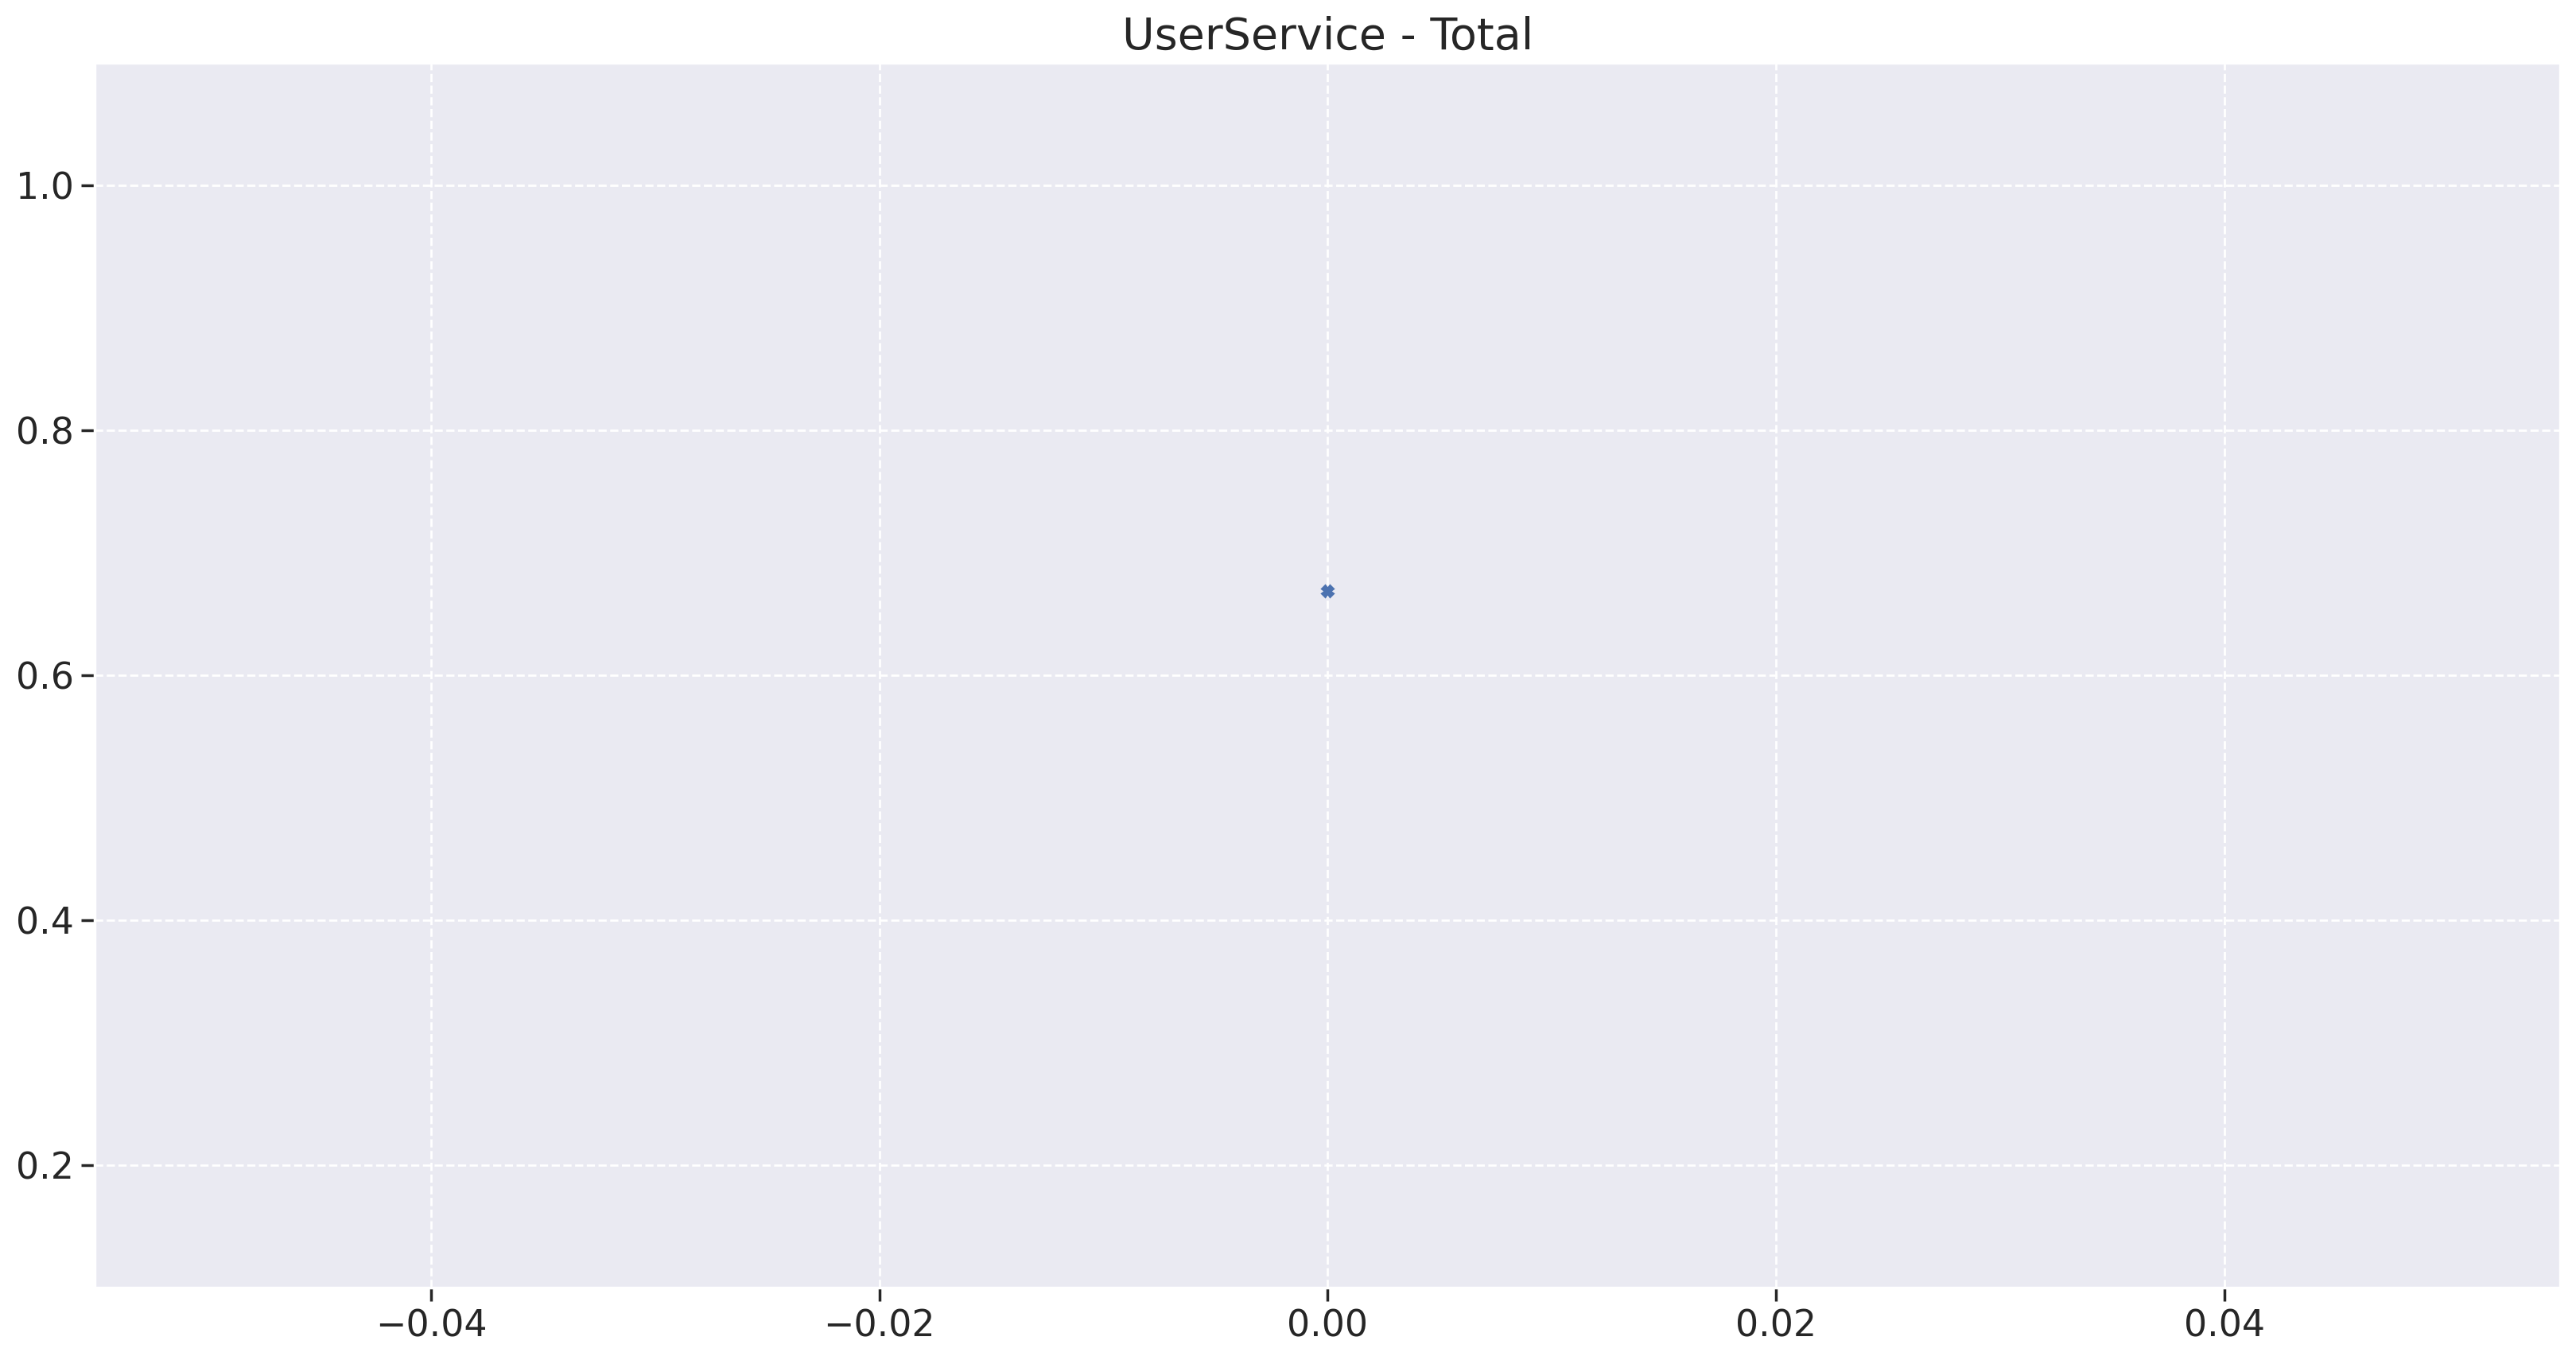

In [65]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

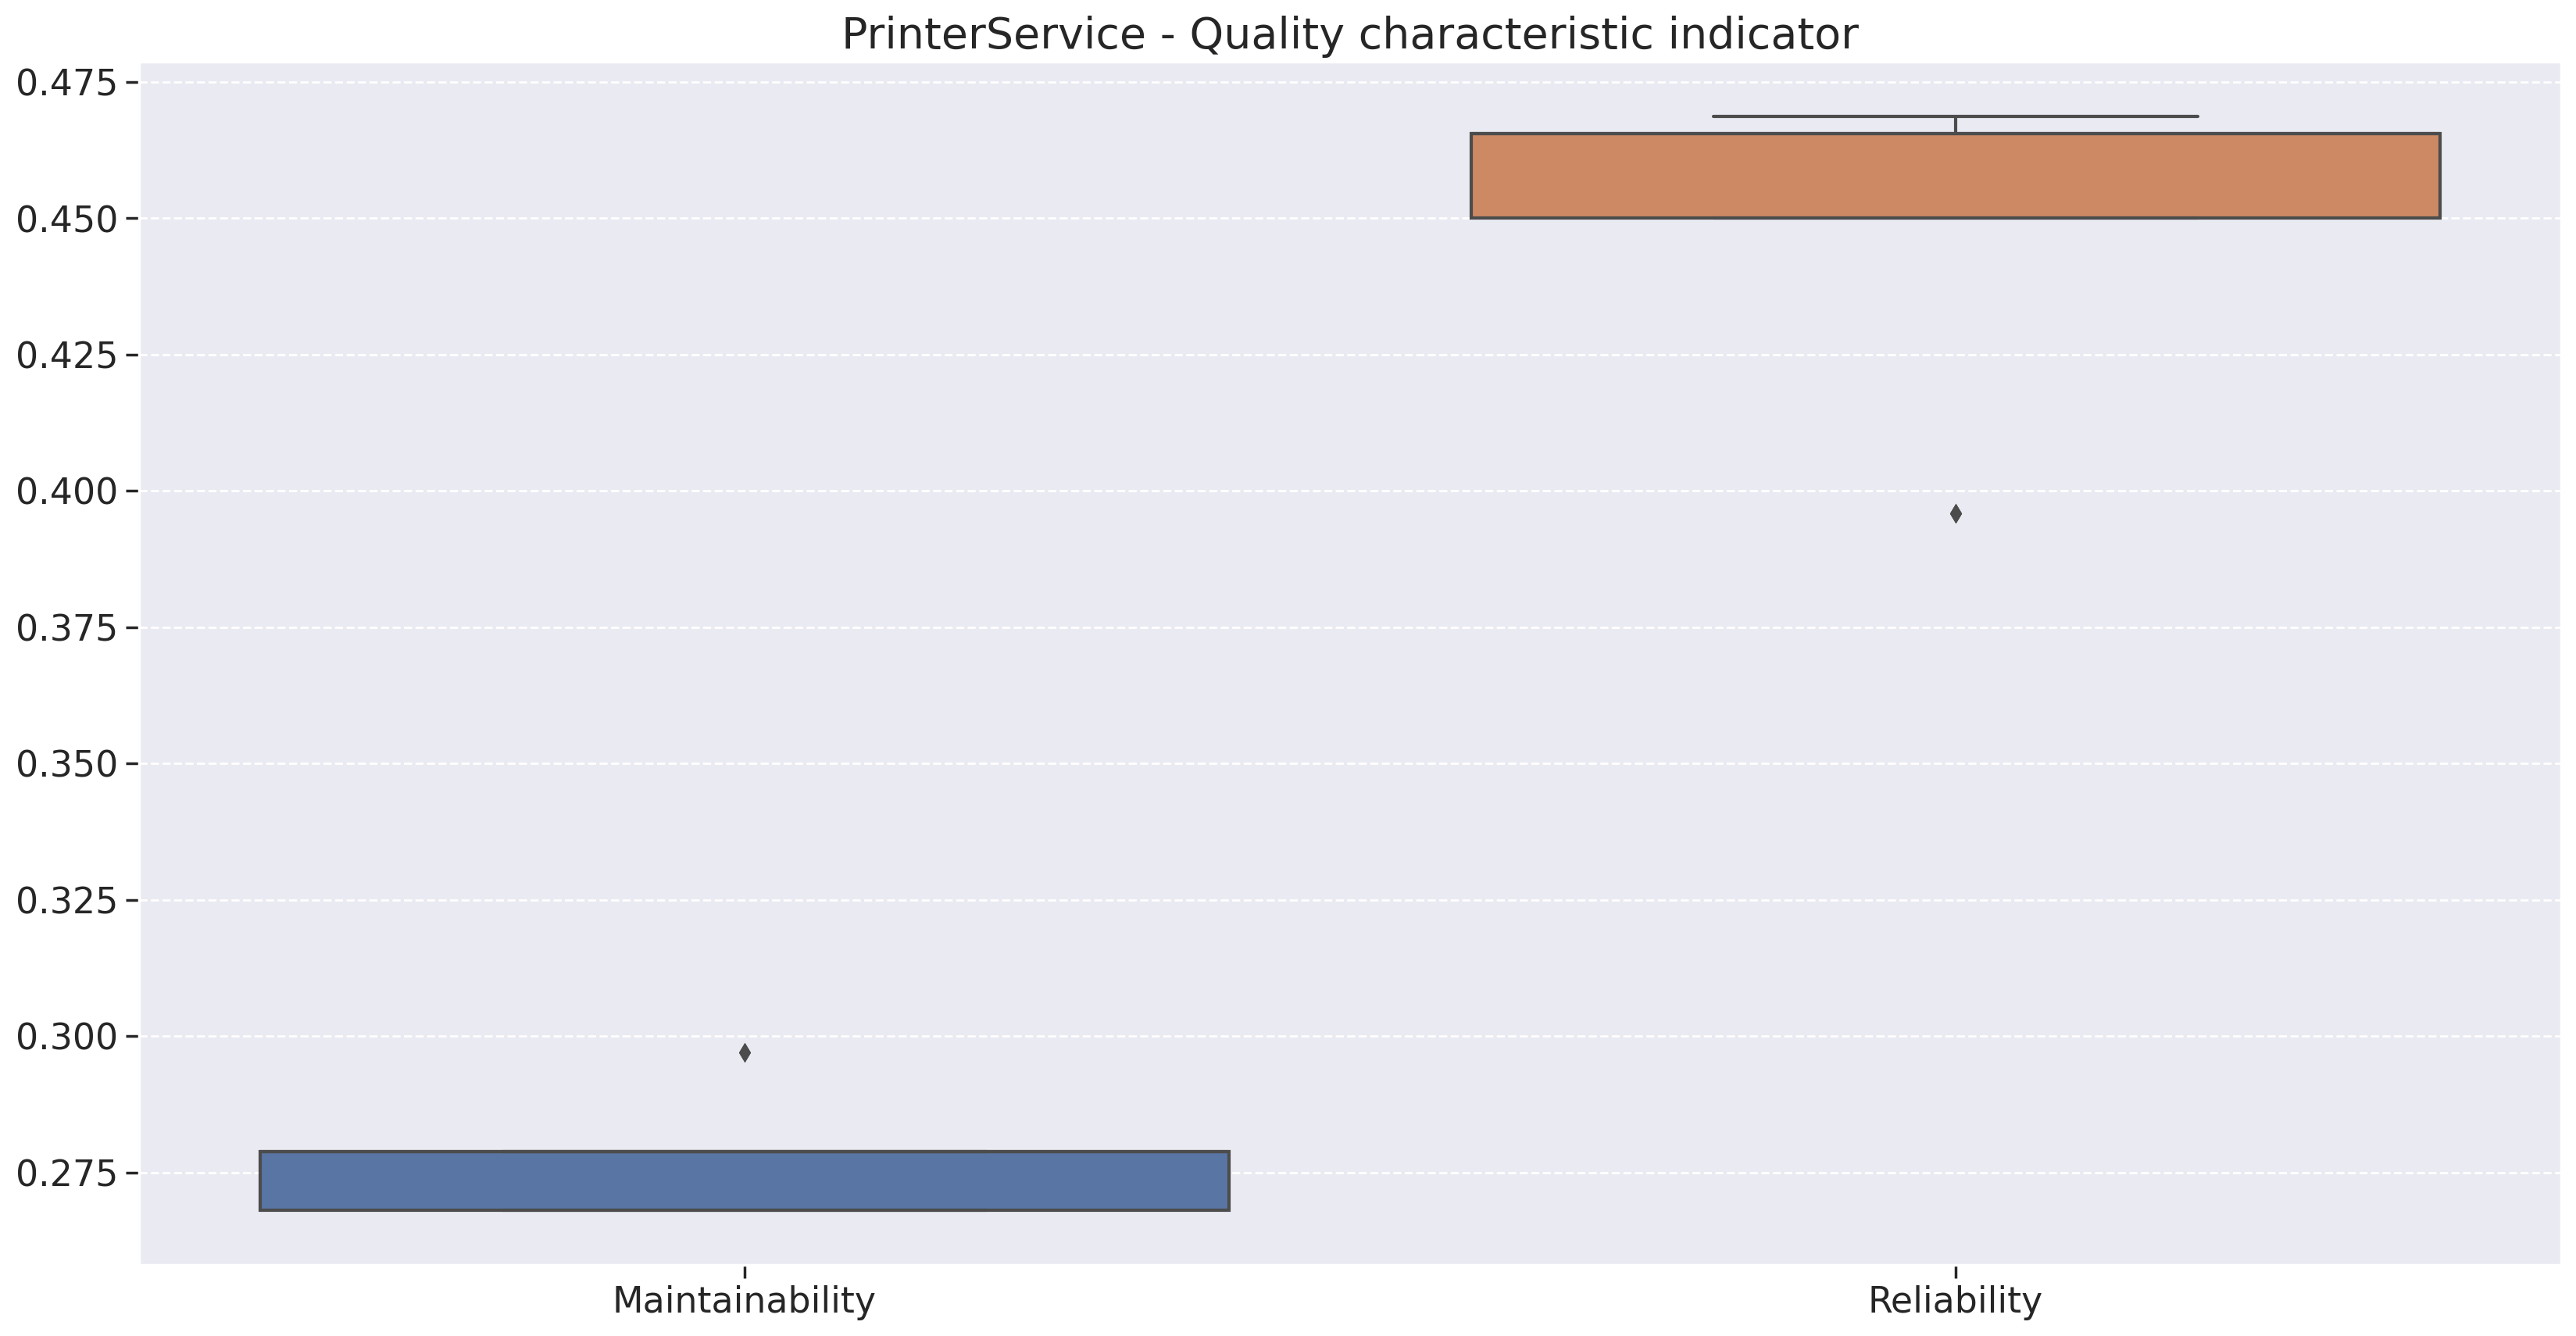

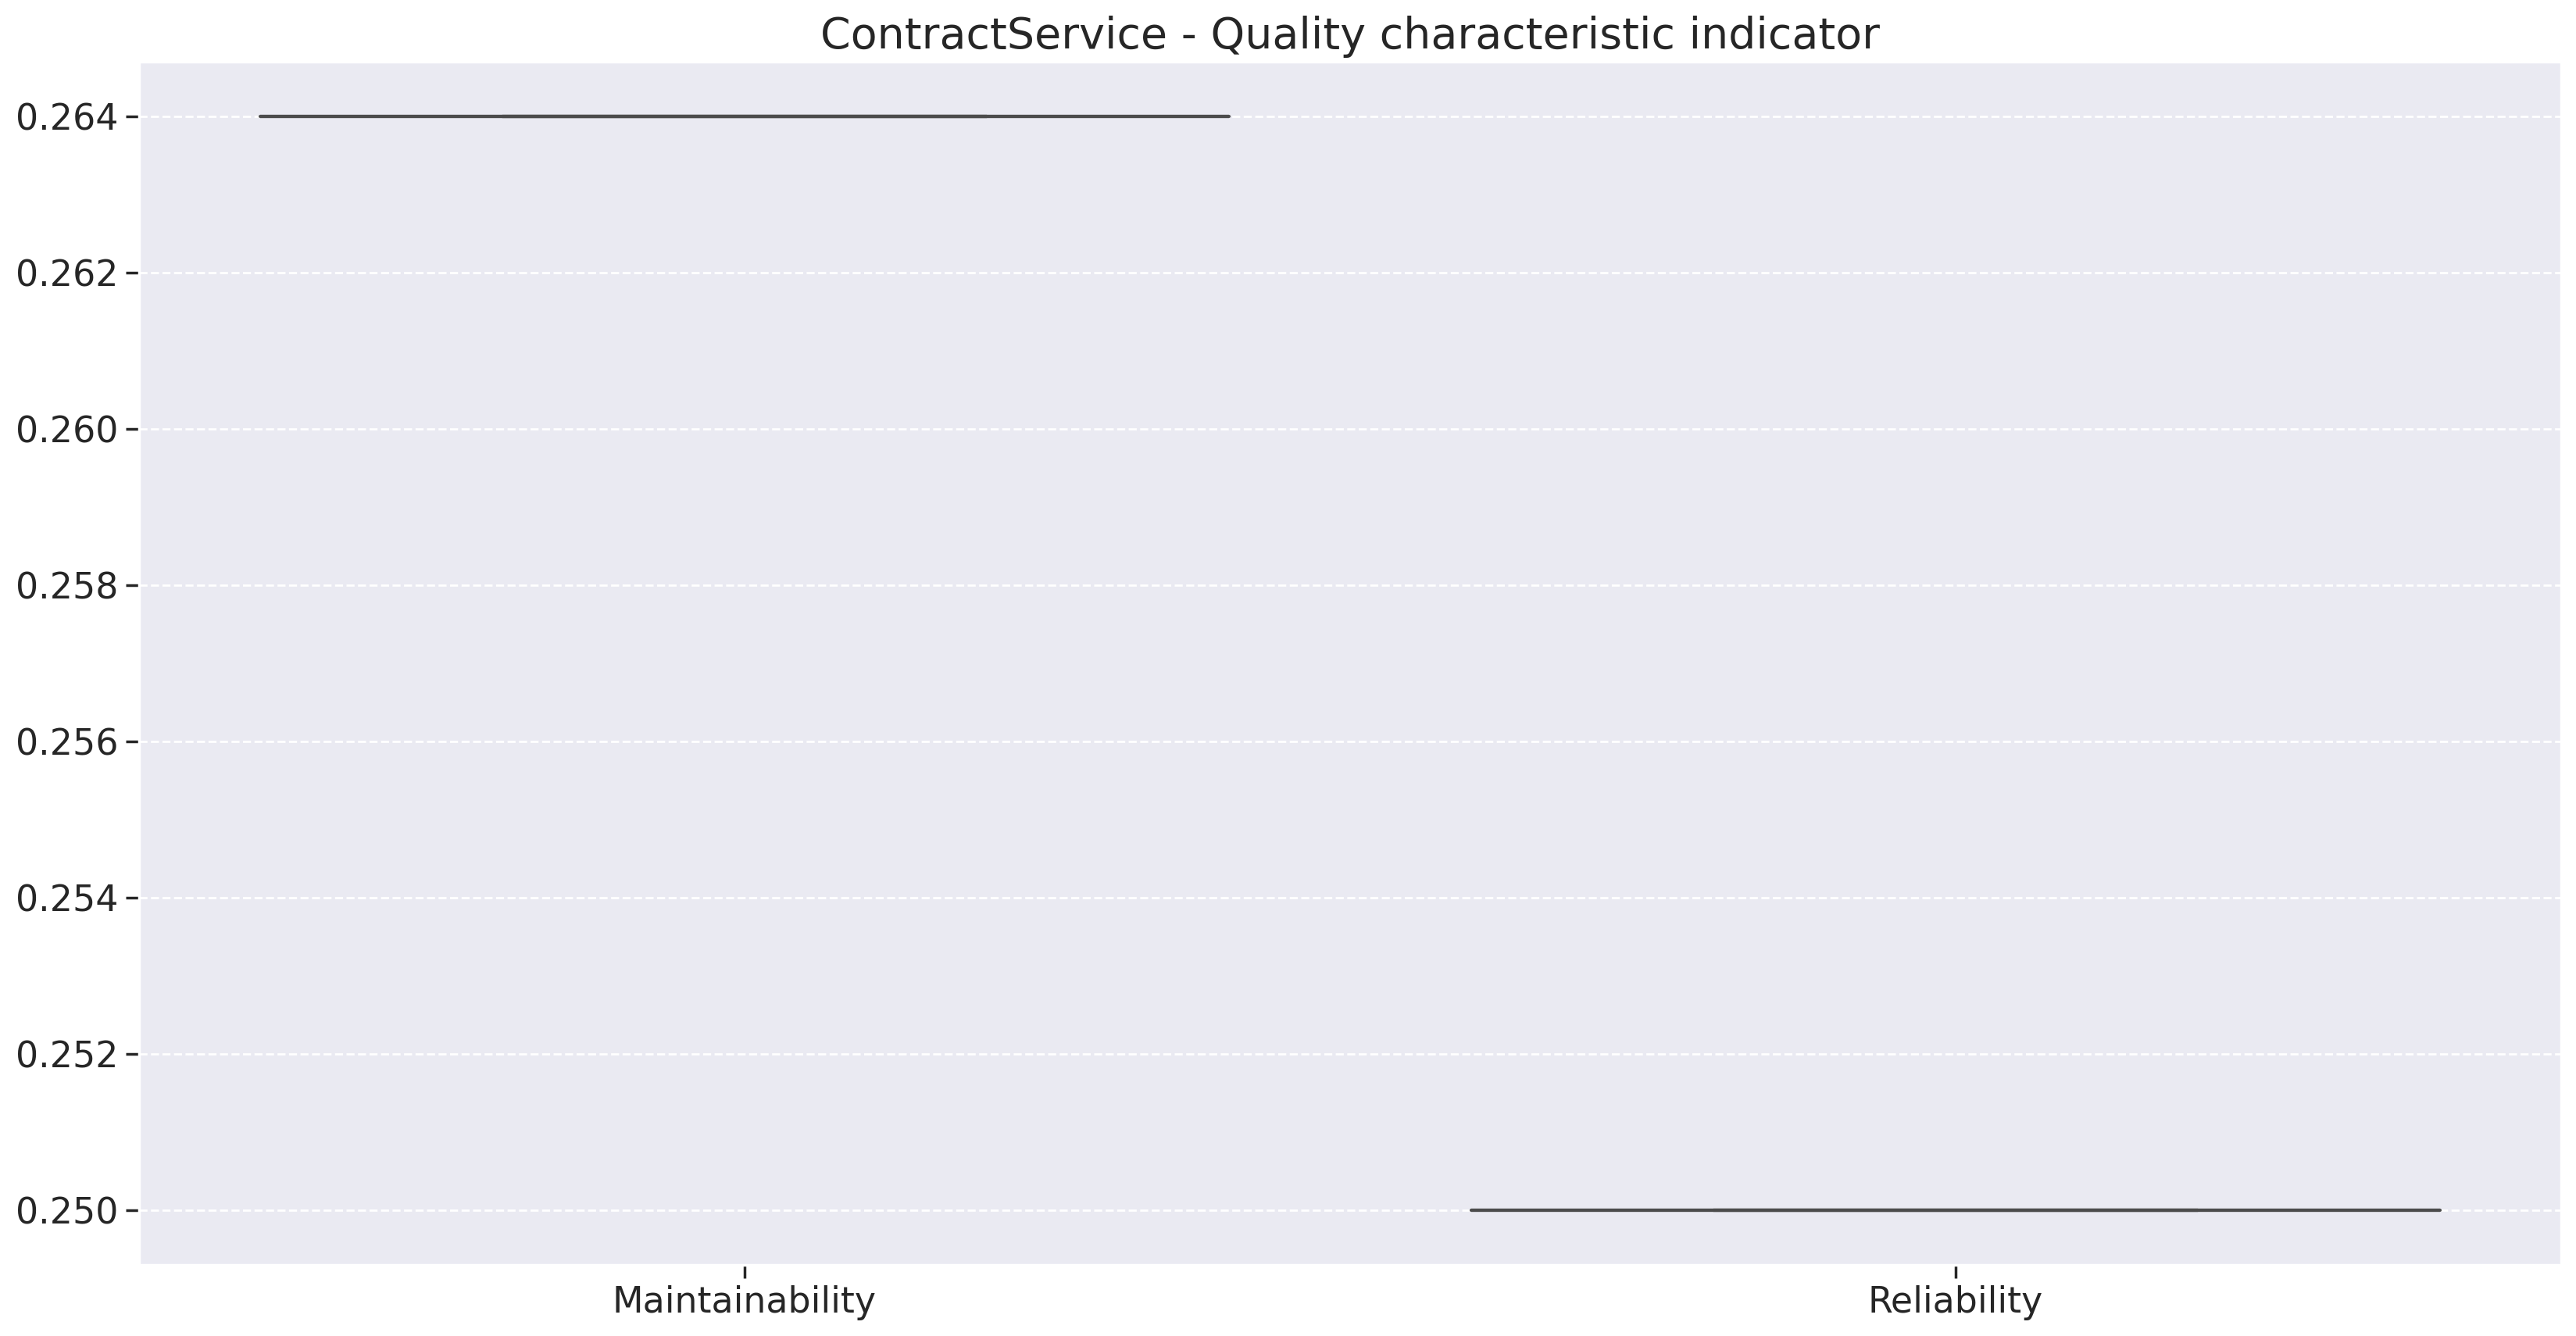

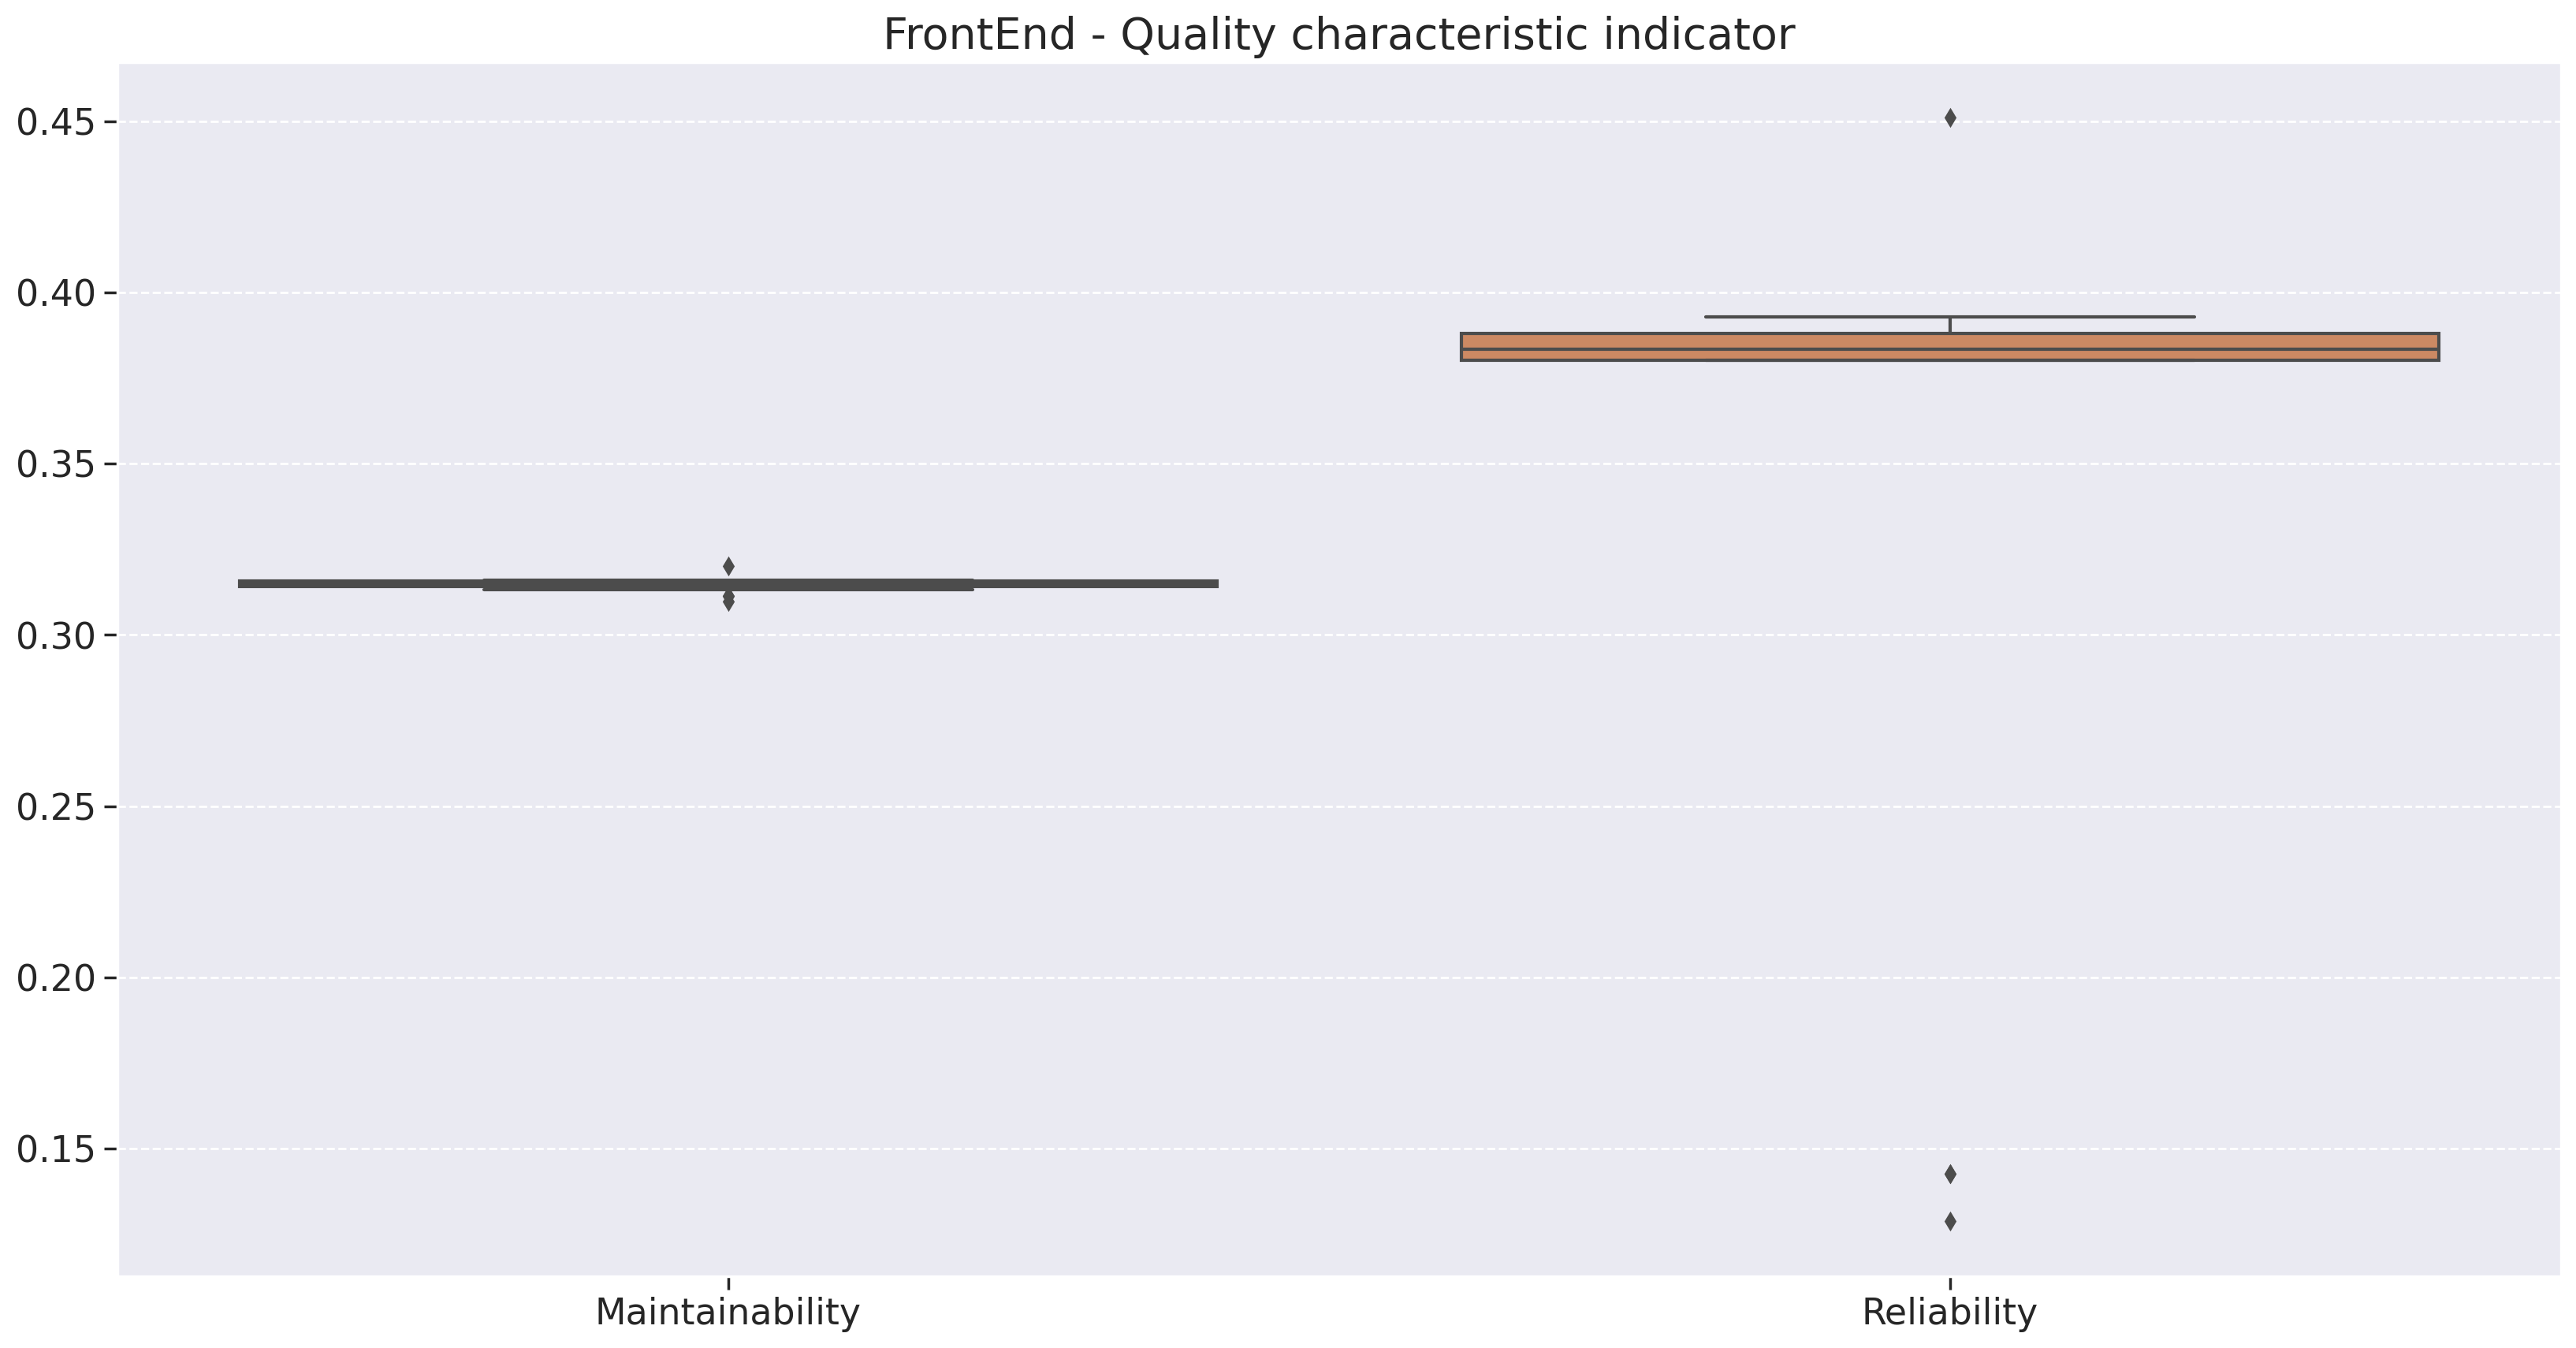

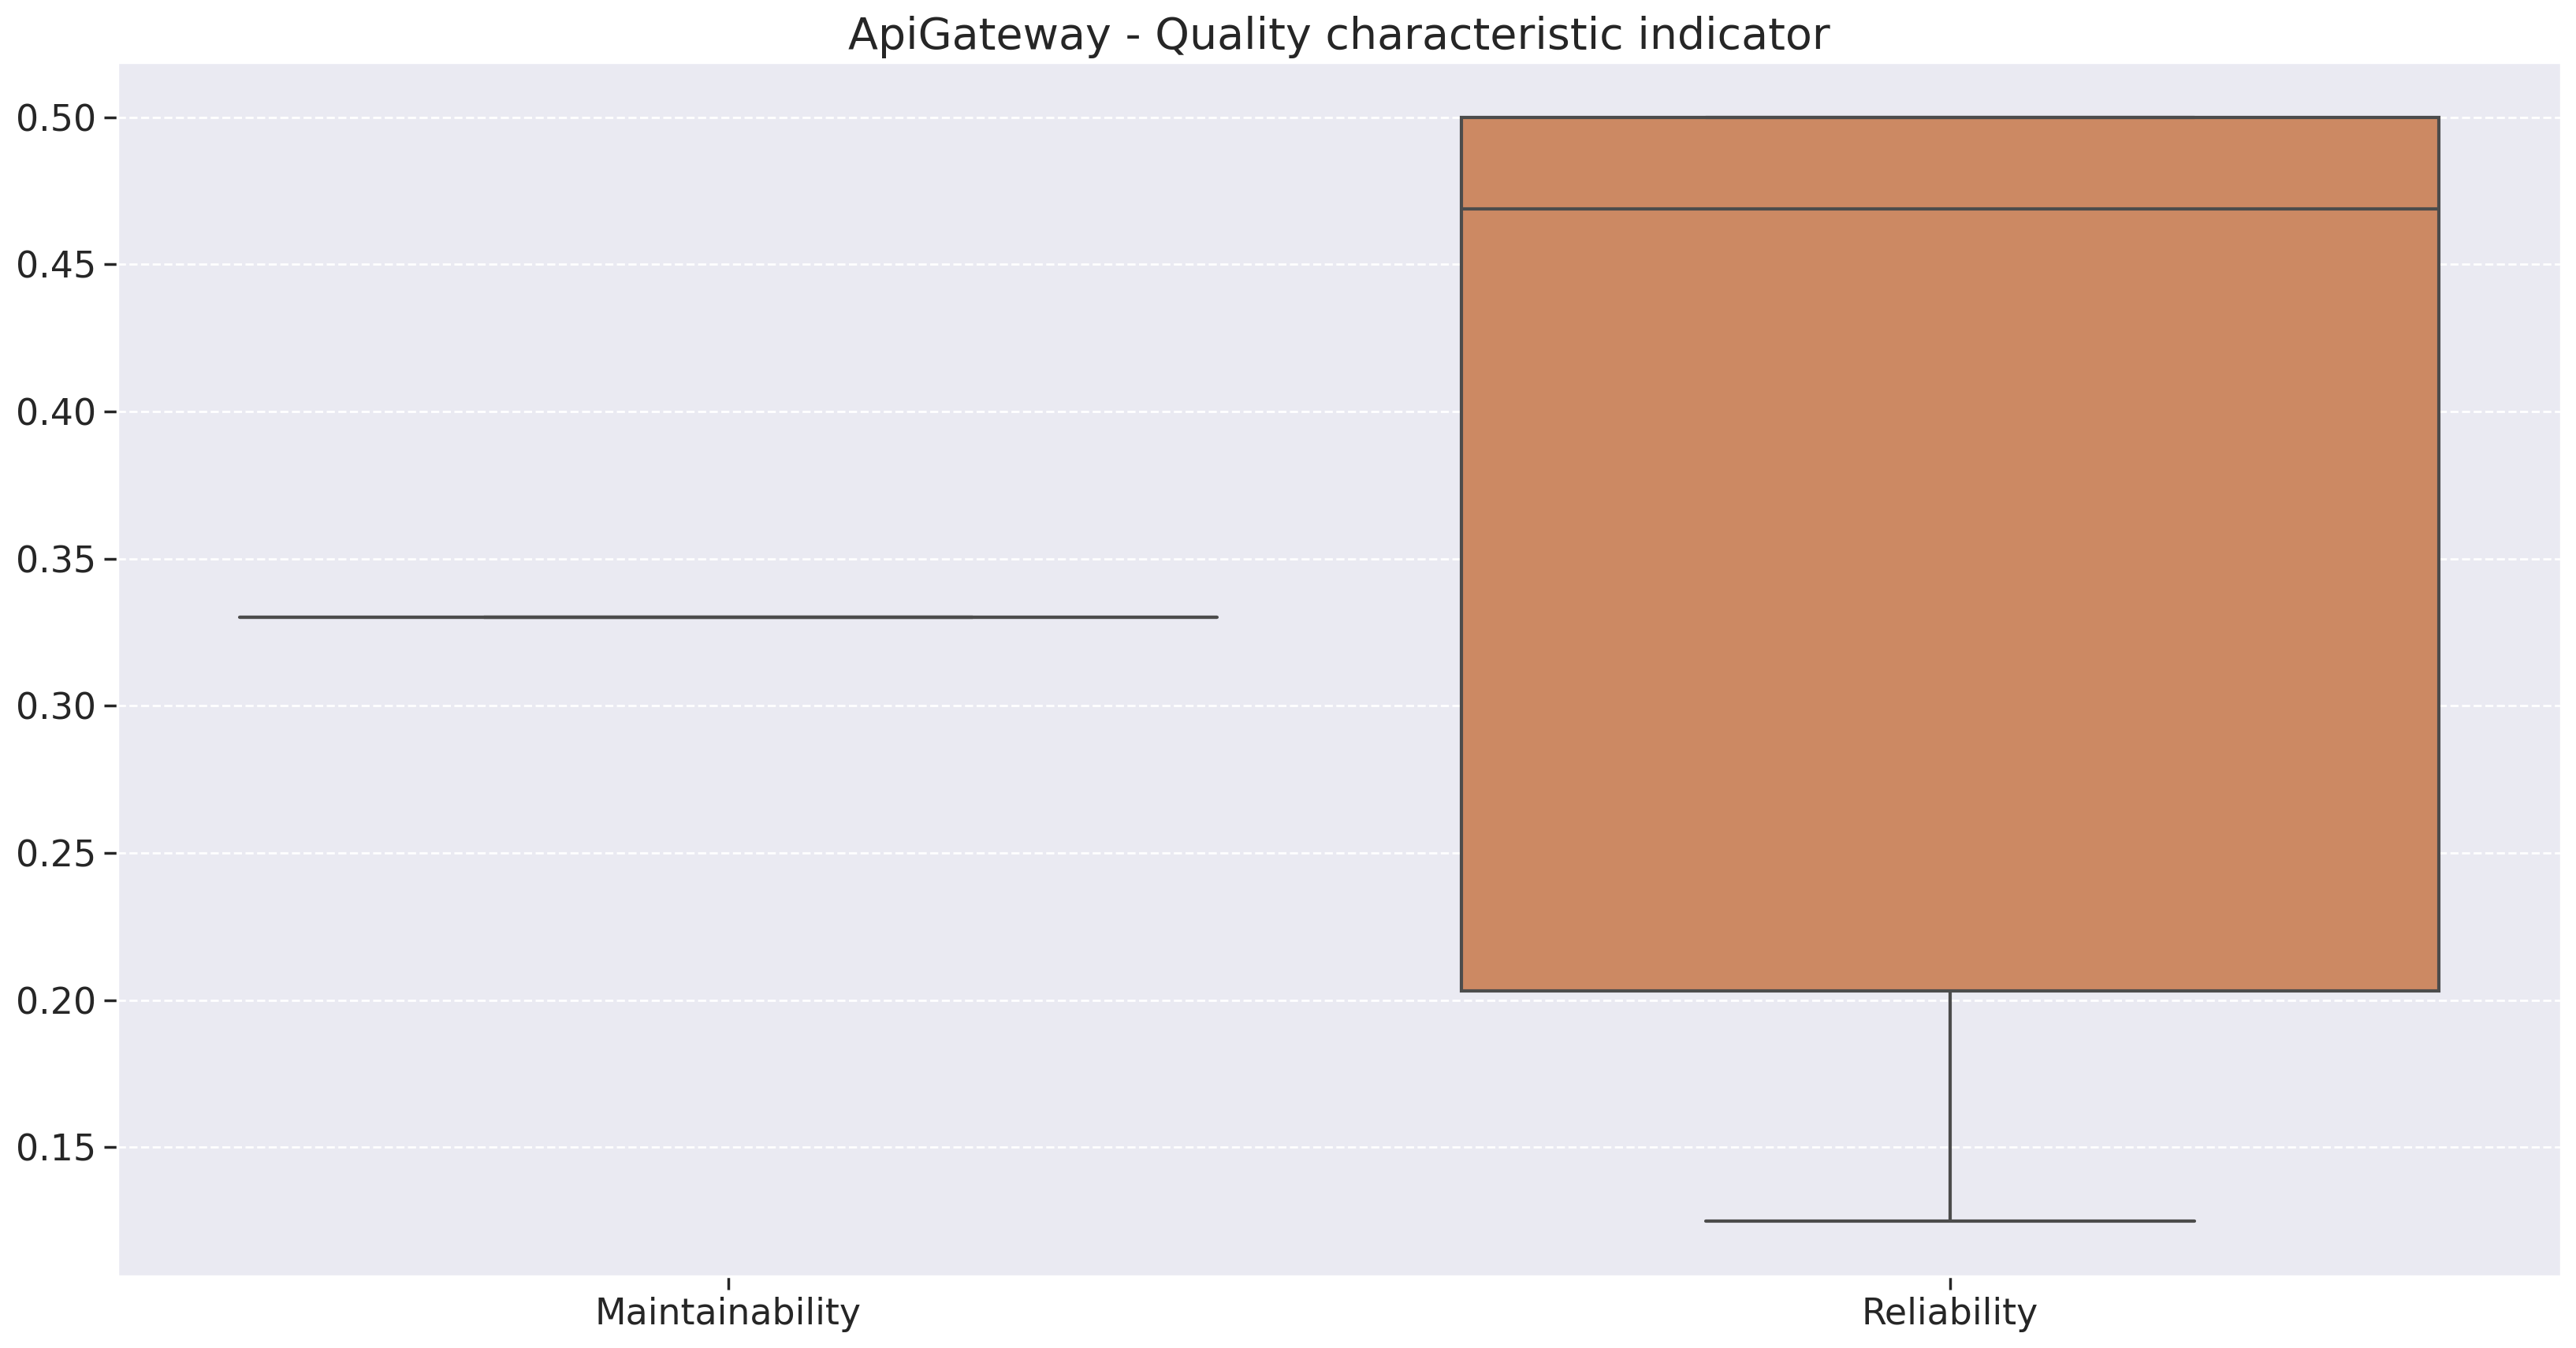

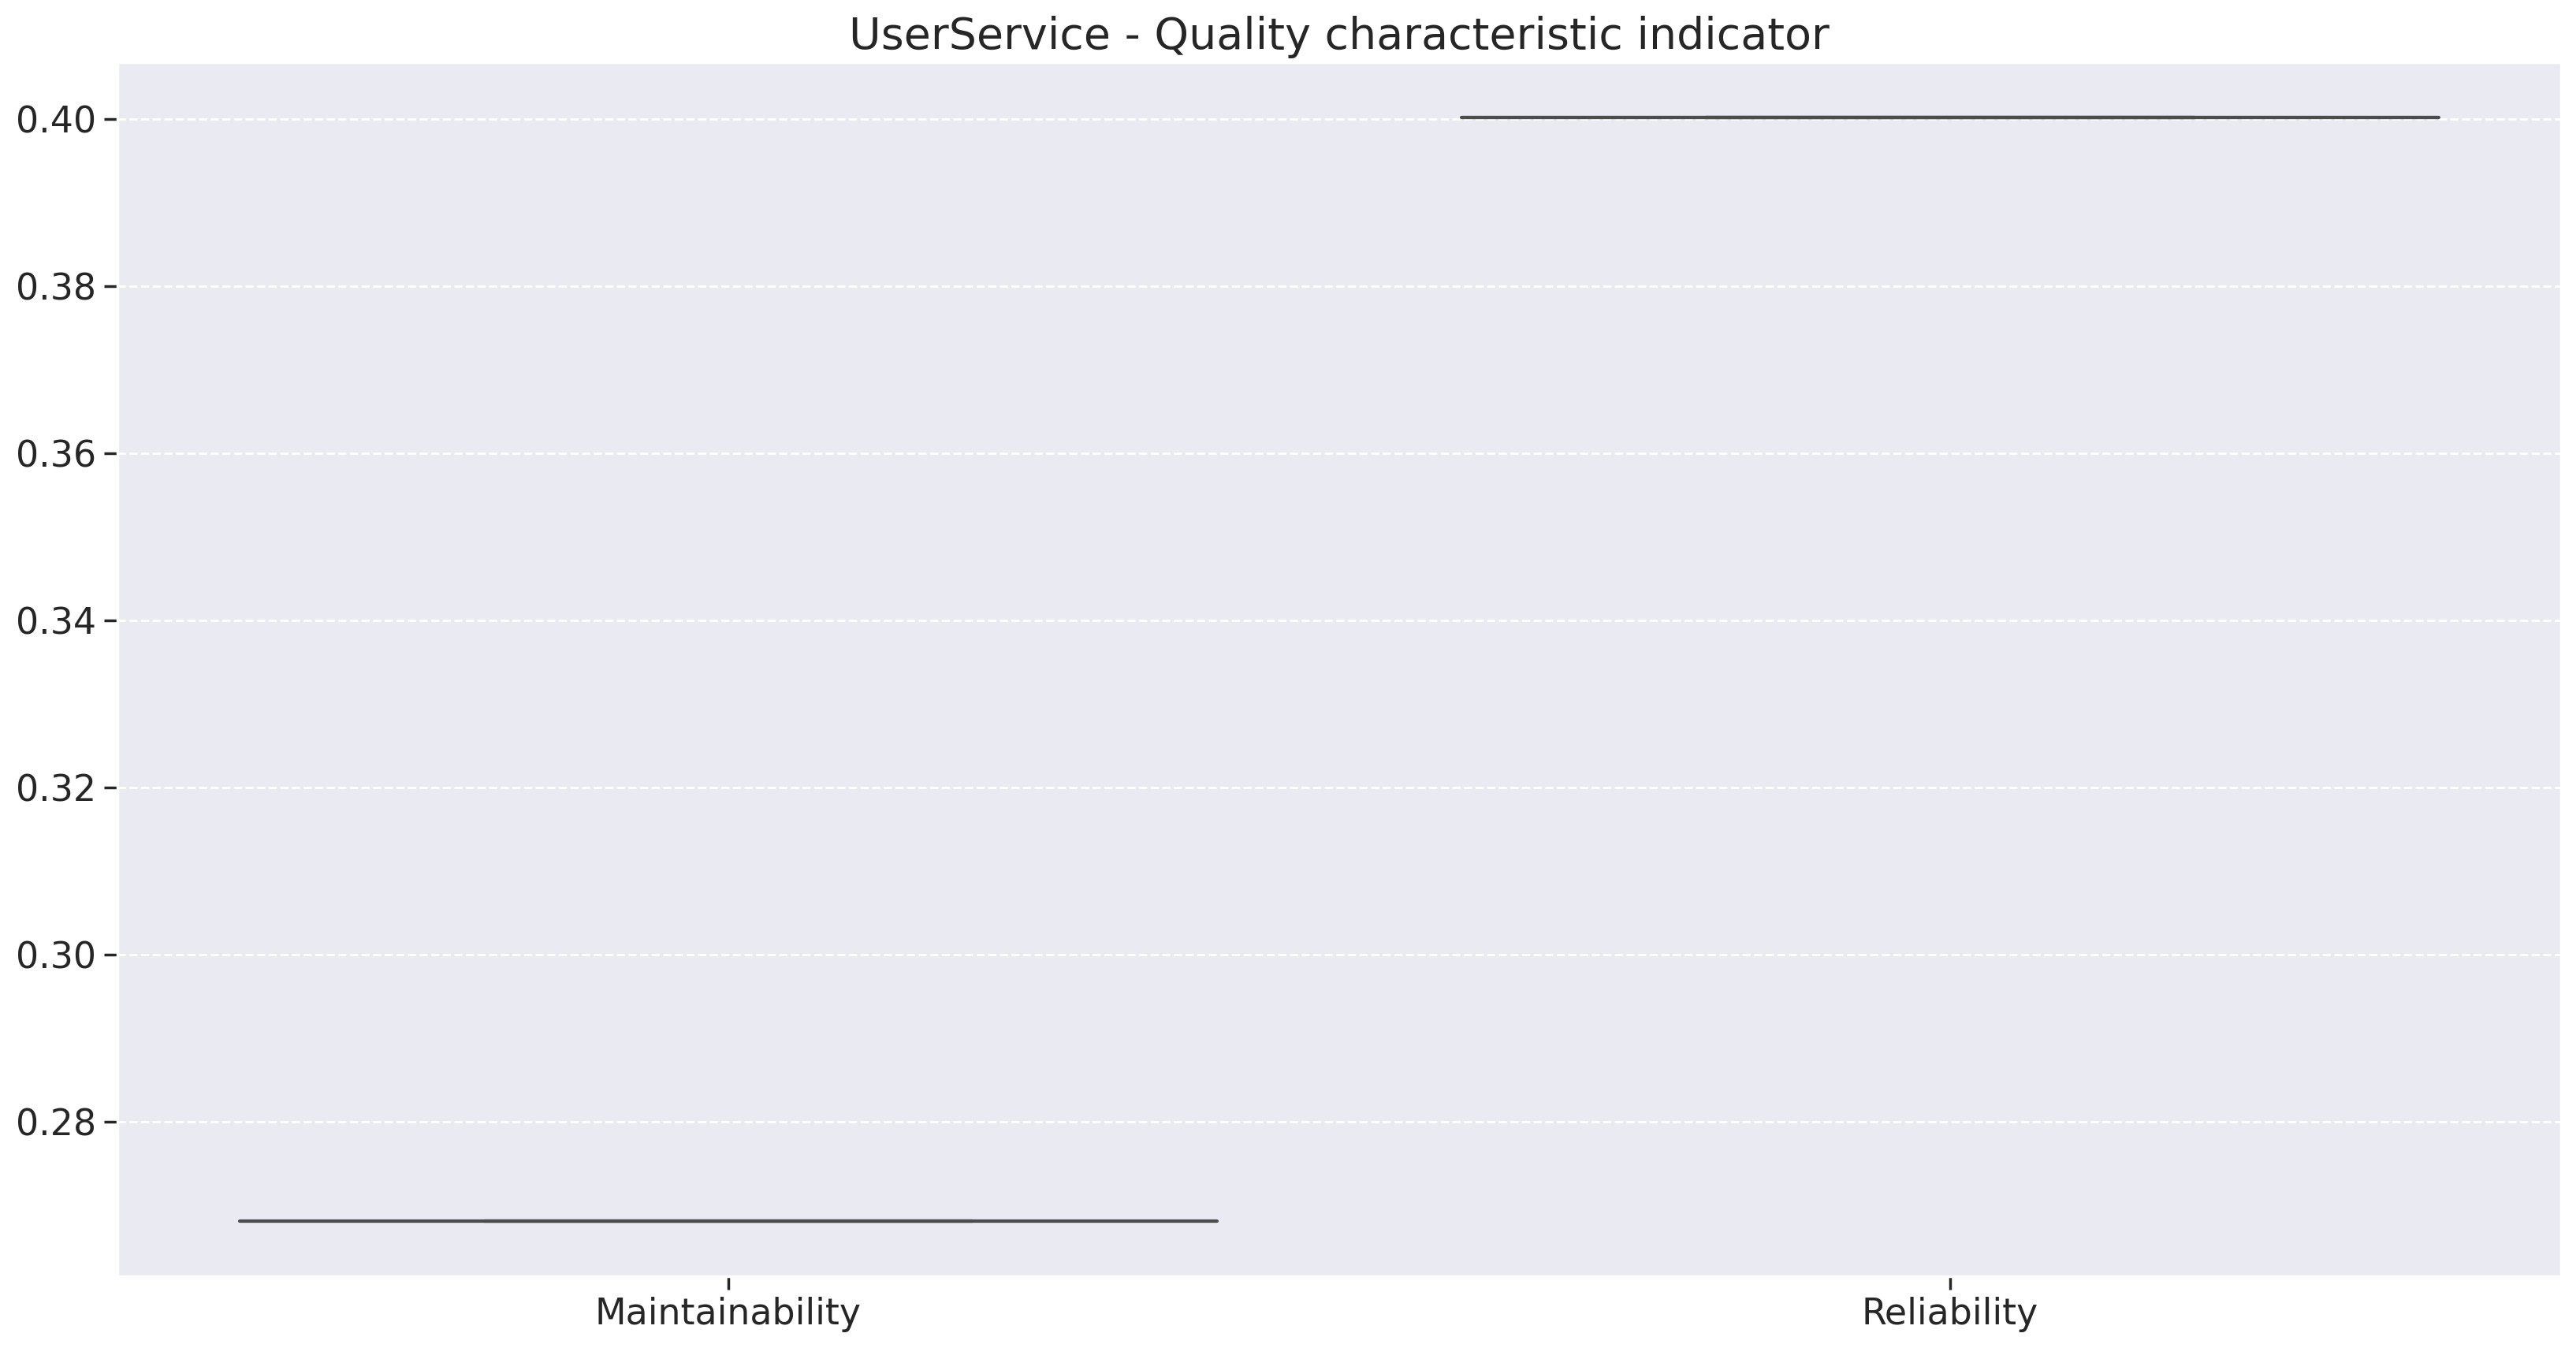

In [66]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

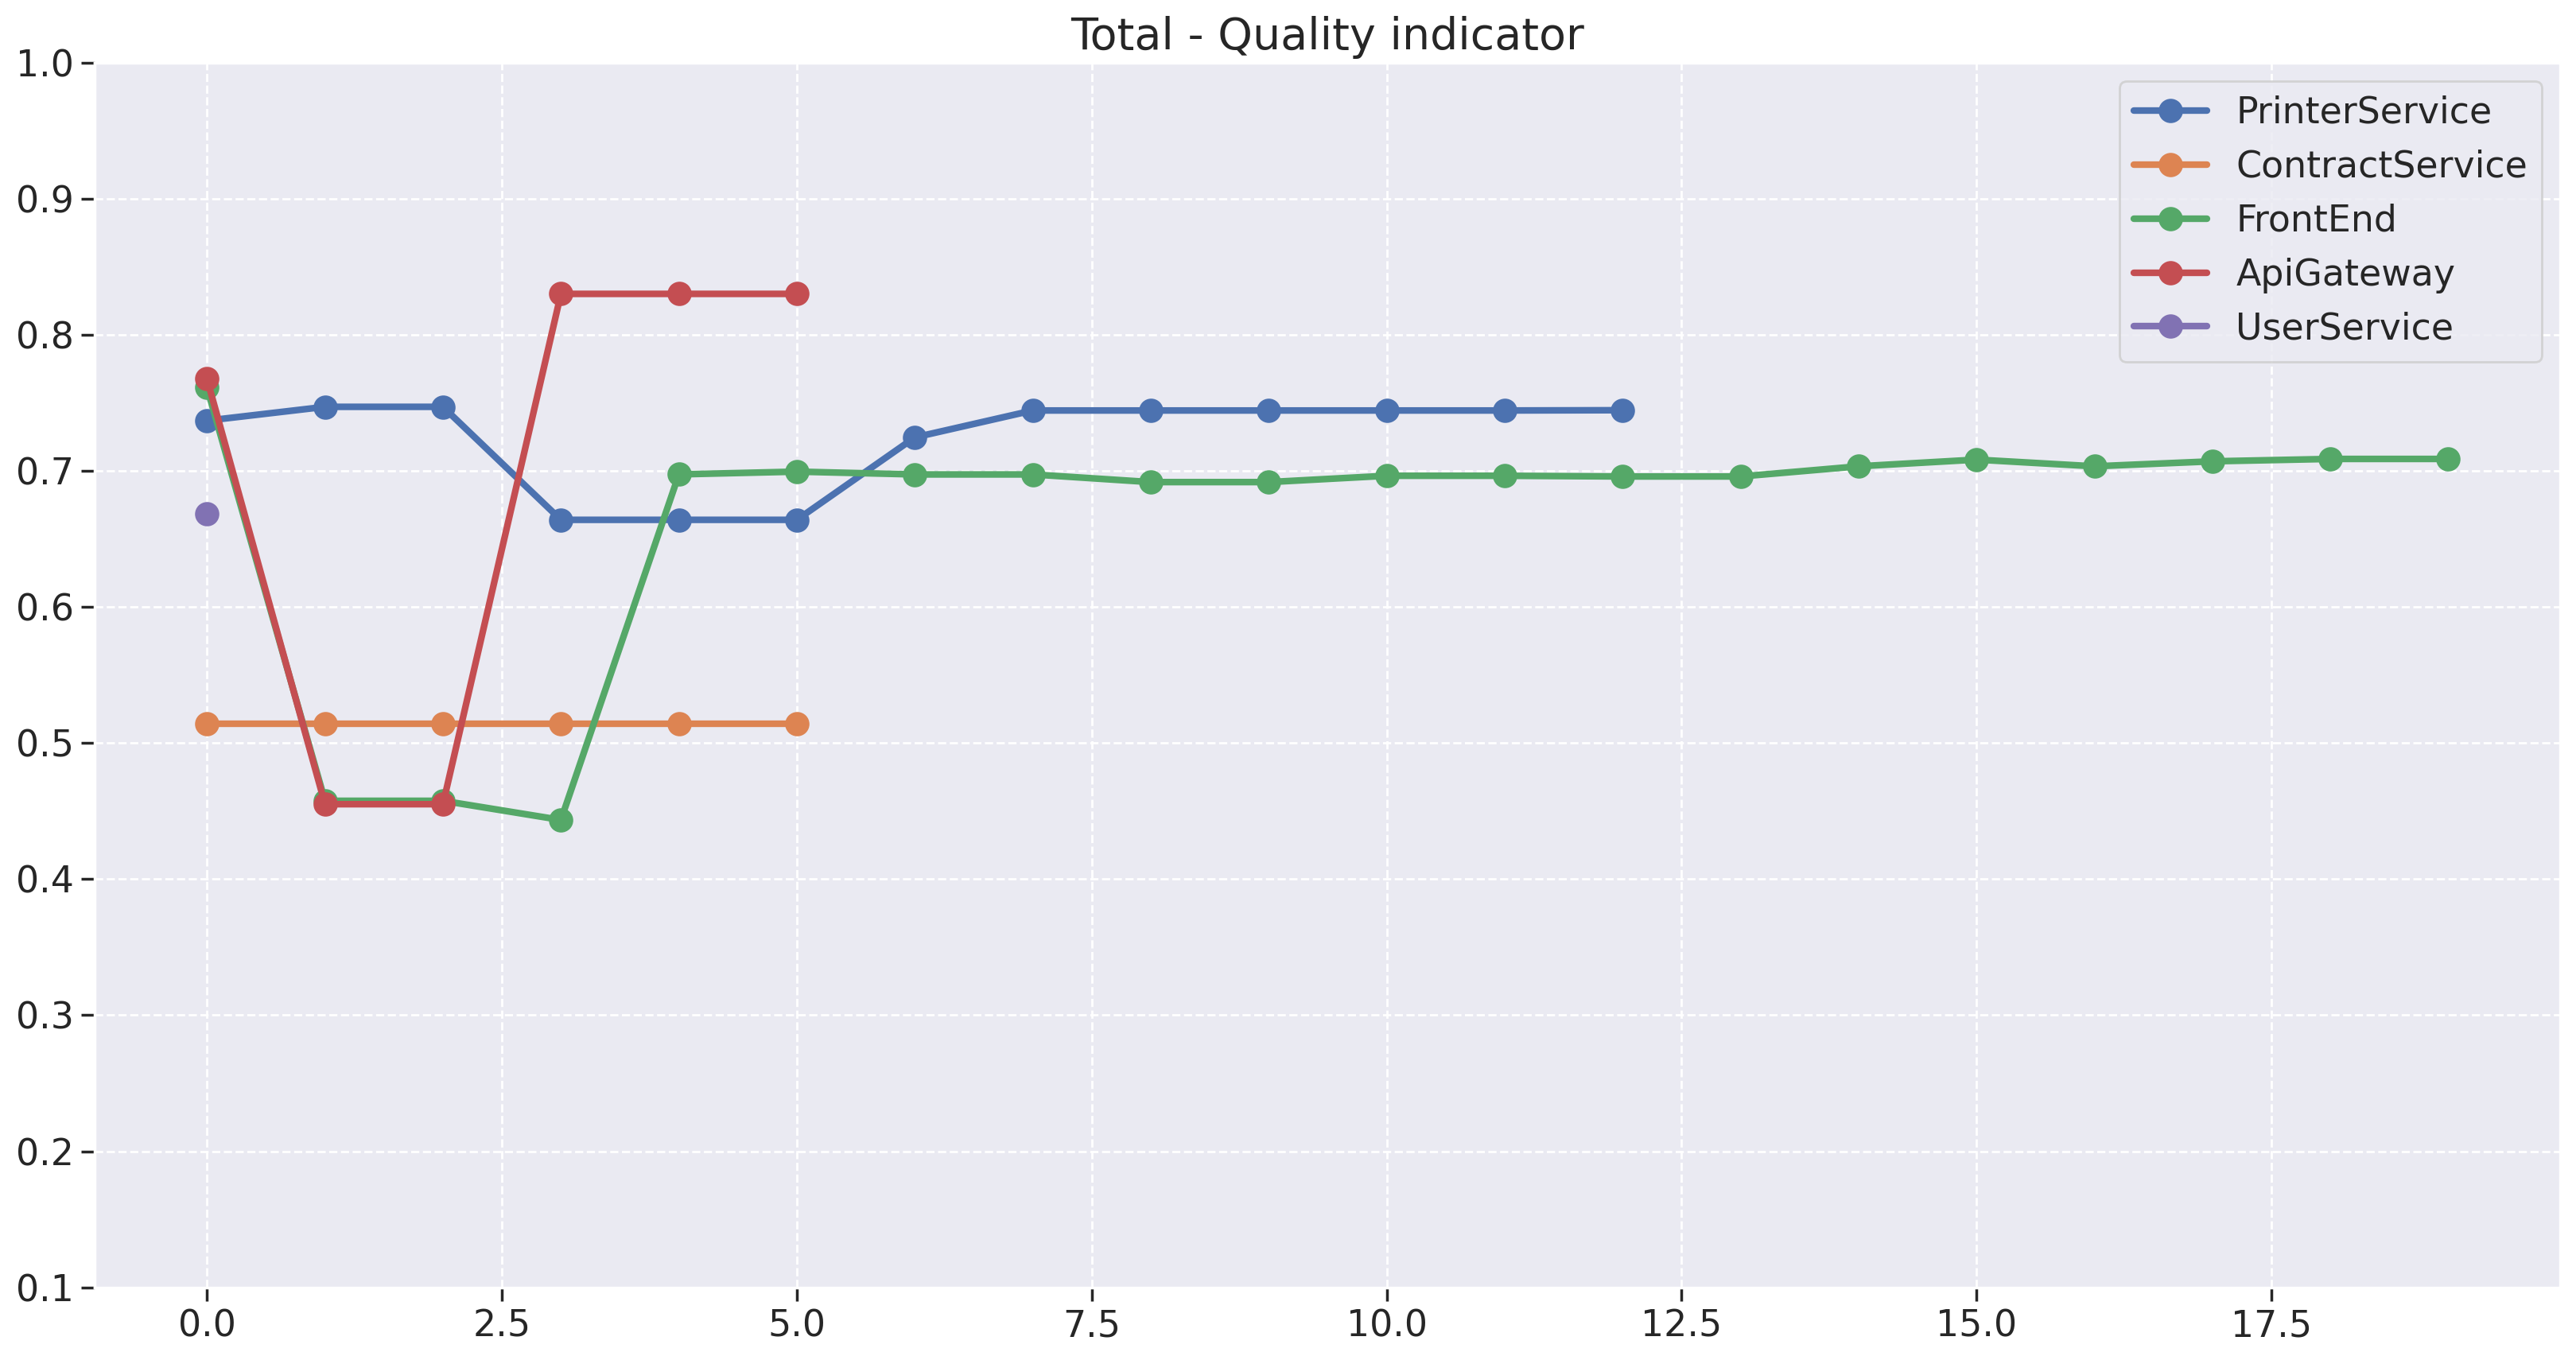

In [67]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [68]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

os.makedirs('./data', exist_ok=True)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2024.1-PrintGO--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2024.1-PrintGO--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.625000,0.000000,1.000000,1.000000,1.0,0.875000,fga-eps-mds-2024.1-PrintGo-PrinterService,07-22-2024-23-44-10,1603,0.536250,0.937500,0.268125,0.468750,0.736875
1,0.700000,0.200000,0.900000,1.000000,1.0,0.800000,fga-eps-mds-2024.1-PrintGo-PrinterService,07-31-2024-21-59-29,1740,0.594000,0.900000,0.297000,0.450000,0.747000
2,0.700000,0.200000,0.900000,1.000000,1.0,0.800000,fga-eps-mds-2024.1-PrintGo-PrinterService,08-02-2024-01-07-35,1740,0.594000,0.900000,0.297000,0.450000,0.747000
3,0.708333,0.000000,0.916667,1.000000,1.0,0.583333,fga-eps-mds-2024.1-PrintGo-PrinterService,08-15-2024-20-05-53,3681,0.536250,0.791667,0.268125,0.395833,0.663958
4,0.708333,0.000000,0.916667,1.000000,1.0,0.583333,fga-eps-mds-2024.1-PrintGo-PrinterService,08-18-2024-14-01-12,3683,0.536250,0.791667,0.268125,0.395833,0.663958
5,0.708333,0.000000,0.916667,1.000000,1.0,0.583333,fga-eps-mds-2024.1-PrintGo-PrinterService,08-19-2024-08-07-52,3916,0.536250,0.791667,0.268125,0.395833,0.663958
6,0.727273,0.000000,0.909091,1.000000,1.0,0.818182,fga-eps-mds-2024.1-PrintGo-PrinterService,08-21-2024-01-58-49,3693,0.540000,0.909091,0.270000,0.454545,0.724545
7,0.758621,0.000000,0.931034,1.000000,1.0,0.862069,fga-eps-mds-2024.1-PrintGo-PrinterService,08-22-2024-16-45-35,4789,0.557586,0.931034,0.278793,0.465517,0.744310
8,0.758621,0.000000,0.931034,1.000000,1.0,0.862069,fga-eps-mds-2024.1-PrintGo-PrinterService,08-27-2024-17-39-16,4789,0.557586,0.931034,0.278793,0.465517,0.744310
9,0.758621,0.000000,0.931034,1.000000,1.0,0.862069,fga-eps-mds-2024.1-PrintGo-PrinterService,08-29-2024-17-50-55,4786,0.557586,0.931034,0.278793,0.465517,0.744310




**1) No microsserviço de backend que apresentar o pior indicador de manutenibilidade indique qual(is) o(s) módulos/arquivos mais críticos e explique como seu time tratou esse problema.**

Embora os microsserviços do backend tenham níveis de manutenibilidade relativamente semelhantes, o ContractService se destacou como o de menor manutenibilidade. Isso se deve, em grande parte, à baixa quantidade de comentários nos arquivos, que fica abaixo de 10%.

É importante mencionar que outros microsserviços também apresentaram uma quantidade reduzida de comentários, o que prejudica a métrica de manutenibilidade. Além disso, fatores como complexidade e duplicação também têm impacto negativo nessa métrica.

Para aumentar a manutenibilidade dos microsserviços, será necessário incrementar a presença de comentários, com o objetivo de mantera densidade de comentários (linhas de comentário dividido pelo total de linhas de código) entre 10% e 30% por arquivo, conforme as indicado pelo Q-Rapids.

**2) No microsserviço que apresentar o pior indicador de confiabilidade, explique como seu time tratou esse problema.**

Em termos de confiabilidade, o serviço que apresentou o pior indicador foi o ContractService. Isso se deve à ausência de coleta de métricas relacionadas ao sucesso dos testes e ao tempo necessário para realizar o build dos testes, o que impactou negativamente a análise. Embora os testes tenham atingido 100% de sucesso e o tempo de build seja relativamente curto, a falta dessas métricas comprometeu a avaliação.

Ao analisar os demais serviços, constatou-se que o APIGateway apresentou o segundo pior indicador de confiabilidade, depois do ContractService. Esse desempenho inferior deveu-se principalmente à redução das métricas de cobertura de testes e à queda no número de testes bem-sucedidos.

Para melhorar a confiabilidade do serviço APIGateway, reestruturamos os testes implementados no semestre anterior, com o objetivo de alcançar uma cobertura próxima de 100%, além de ajustar os testes para garantir 100% de sucesso.

**3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento, do projeto relacionado ao seu time.**

Embora o projeto tenha sido uma continuação do desenvolvimento realizado no semestre anterior, foi necessário realizar uma reestruturação quase completa nos serviços PrinterService e FrontEnd, além da criação de um novo serviço de contratos. Mesmo com essas necessidades, conseguimos melhorar significativamente os indicadores de manutenibilidade e confiabilidade do produto.

No FrontEnd, foi preciso desenvolver uma série de novos componentes para garantir um estilo visual consistente em todo o projeto, algo que não havia sido implementado anteriormente. Além disso, aumentamos a cobertura de testes e a taxa de sucesso dos mesmos, resultando em uma melhoria substancial no indicador de confiabilidade.

Nos demais serviços do backend, alcançamos uma cobertura de testes superior a 80%, o que se traduziu em um aumento expressivo na confiabilidade desses serviços. O que gerou um aumento na qualidade do produto, com um código confiável e mais fácil de manter do que anteriormente.